In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

np.random.seed(1234)
tf.random.set_seed(1234)

In [4]:
# Set data type
# DTYPE='float32'
# tf.keras.backend.set_floatx(DTYPE)

In [5]:
sns.set(font_scale=1.6)

In [6]:
print (tf.__version__)

2.7.0


### Define PINN neural network

In [7]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    
    def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(1))

        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))

        model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))

        return model

    # Initialize the class
    def __init__(self, X_u, Y_u, X_r):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = self.init_model()
        
        self.iter = 1
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1+loss_2+loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1:]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        del tape
        
        return loss, g, g_u, g_r

        # Compute gradient projections.
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])
                
    def predict(self, x_star):
        mu, sigma = self.mu_x, self.sigma_x
        x_star_normalized = (x_star-mu)/sigma
        
        return self.model(x_star_normalized)

### Generate training data

In [8]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 5000                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([60000.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [9]:
N = 80000

### Train PINN without PCGrad

In [10]:
PINN_solver = PINN(x_u, y_u, x_r)
initial_weights = PINN_solver.model.get_weights()

In [11]:
optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 00005: loss = 0.18346442,4.7452335e-09
Iteration 00010: loss = 0.068424754,4.9039635e-09
Iteration 00015: loss = 0.020643411,5.7194187e-09
Iteration 00020: loss = 0.0067705954,6.5925416e-09
Iteration 00025: loss = 0.0028171672,7.254272e-09
Iteration 00030: loss = 0.0014879837,7.702817e-09
Iteration 00035: loss = 0.0009485364,7.998267e-09
Iteration 00040: loss = 0.0006923361,8.193094e-09
Iteration 00045: loss = 0.00055481546,8.32344e-09
Iteration 00050: loss = 0.00047347663,8.412756e-09
Iteration 00055: loss = 0.0004212712,8.476025e-09
Iteration 00060: loss = 0.00038521548,8.5227825e-09
Iteration 00065: loss = 0.00035857037,8.559086e-09
Iteration 00070: loss = 0.0003376441,8.588776e-09
Iteration 00075: loss = 0.00032031964,8.614282e-09
Iteration 00080: loss = 0.00030535503,8.637134e-09
Iteration 00085: loss = 0.00029201413,8.658292e-09
Iteration 00090: loss = 0.00027984477,8.678355e-09
Iteration 00095: loss = 0.00026856767,8.69769e-09
Iteration 00100: loss = 0.00025801166,8.71

Iteration 00865: loss = 1.2605228e-05,1.0115575e-08
Iteration 00870: loss = 1.2470155e-05,1.0120349e-08
Iteration 00875: loss = 1.233724e-05,1.0125098e-08
Iteration 00880: loss = 1.2206071e-05,1.0129822e-08
Iteration 00885: loss = 1.2077213e-05,1.0134524e-08
Iteration 00890: loss = 1.1950423e-05,1.01392015e-08
Iteration 00895: loss = 1.1824916e-05,1.0143855e-08
Iteration 00900: loss = 1.1702013e-05,1.0148485e-08
Iteration 00905: loss = 1.15805315e-05,1.015309e-08
Iteration 00910: loss = 1.1461222e-05,1.0157674e-08
Iteration 00915: loss = 1.1342906e-05,1.01622355e-08
Iteration 00920: loss = 1.1227089e-05,1.0166775e-08
Iteration 00925: loss = 1.1112606e-05,1.017129e-08
Iteration 00930: loss = 1.1000188e-05,1.01757855e-08
Iteration 00935: loss = 1.0888884e-05,1.01802575e-08
Iteration 00940: loss = 1.0779415e-05,1.0184709e-08
Iteration 00945: loss = 1.0671574e-05,1.0189139e-08
Iteration 00950: loss = 1.0565155e-05,1.0193547e-08
Iteration 00955: loss = 1.0460512e-05,1.0197935e-08
Iteration 

Iteration 01680: loss = 3.3822564e-06,1.0683024e-08
Iteration 01685: loss = 3.3611504e-06,1.06856515e-08
Iteration 01690: loss = 3.340251e-06,1.0688271e-08
Iteration 01695: loss = 3.3194558e-06,1.0690884e-08
Iteration 01700: loss = 3.2989658e-06,1.06934905e-08
Iteration 01705: loss = 3.2782734e-06,1.0696092e-08
Iteration 01710: loss = 3.2581877e-06,1.0698684e-08
Iteration 01715: loss = 3.2382002e-06,1.0701271e-08
Iteration 01720: loss = 3.2182088e-06,1.0703851e-08
Iteration 01725: loss = 3.1984164e-06,1.0706423e-08
Iteration 01730: loss = 3.1791212e-06,1.0708988e-08
Iteration 01735: loss = 3.1594202e-06,1.0711548e-08
Iteration 01740: loss = 3.140113e-06,1.0714102e-08
Iteration 01745: loss = 3.1212942e-06,1.0716649e-08
Iteration 01750: loss = 3.102269e-06,1.0719191e-08
Iteration 01755: loss = 3.083632e-06,1.0721725e-08
Iteration 01760: loss = 3.0647898e-06,1.0724253e-08
Iteration 01765: loss = 3.0463323e-06,1.0726774e-08
Iteration 01770: loss = 3.028157e-06,1.07292895e-08
Iteration 0177

Iteration 02500: loss = 1.4058822e-06,1.1044225e-08
Iteration 02505: loss = 1.3993053e-06,1.1046101e-08
Iteration 02510: loss = 1.3927526e-06,1.1047974e-08
Iteration 02515: loss = 1.386421e-06,1.1049845e-08
Iteration 02520: loss = 1.3800453e-06,1.1051712e-08
Iteration 02525: loss = 1.3736923e-06,1.1053576e-08
Iteration 02530: loss = 1.3673622e-06,1.1055439e-08
Iteration 02535: loss = 1.3610543e-06,1.1057296e-08
Iteration 02540: loss = 1.3548348e-06,1.1059152e-08
Iteration 02545: loss = 1.3485725e-06,1.10610054e-08
Iteration 02550: loss = 1.342331e-06,1.1062854e-08
Iteration 02555: loss = 1.3362414e-06,1.1064701e-08
Iteration 02560: loss = 1.3301081e-06,1.1066547e-08
Iteration 02565: loss = 1.3240614e-06,1.1068387e-08
Iteration 02570: loss = 1.3180357e-06,1.1070226e-08
Iteration 02575: loss = 1.3119021e-06,1.1072062e-08
Iteration 02580: loss = 1.3060472e-06,1.1073896e-08
Iteration 02585: loss = 1.3001483e-06,1.1075725e-08
Iteration 02590: loss = 1.2943339e-06,1.1077551e-08
Iteration 025

Iteration 03325: loss = 7.011793e-07,1.1320848e-08
Iteration 03330: loss = 6.984873e-07,1.132236e-08
Iteration 03335: loss = 6.9580364e-07,1.1323871e-08
Iteration 03340: loss = 6.9312733e-07,1.132538e-08
Iteration 03345: loss = 6.9045865e-07,1.1326888e-08
Iteration 03350: loss = 6.8779826e-07,1.1328394e-08
Iteration 03355: loss = 6.851447e-07,1.1329898e-08
Iteration 03360: loss = 6.824993e-07,1.13314e-08
Iteration 03365: loss = 6.7986144e-07,1.1332902e-08
Iteration 03370: loss = 6.773232e-07,1.1334402e-08
Iteration 03375: loss = 6.746082e-07,1.1335899e-08
Iteration 03380: loss = 6.721307e-07,1.1337395e-08
Iteration 03385: loss = 6.696143e-07,1.1338891e-08
Iteration 03390: loss = 6.670136e-07,1.1340383e-08
Iteration 03395: loss = 6.6451133e-07,1.1341875e-08
Iteration 03400: loss = 6.6192524e-07,1.13433645e-08
Iteration 03405: loss = 6.594375e-07,1.1344853e-08
Iteration 03410: loss = 6.5695684e-07,1.1346341e-08
Iteration 03415: loss = 6.543923e-07,1.1347826e-08
Iteration 03420: loss = 6.

Iteration 04135: loss = 3.8977217e-07,1.1548016e-08
Iteration 04140: loss = 3.884845e-07,1.1549323e-08
Iteration 04145: loss = 3.8712997e-07,1.155063e-08
Iteration 04150: loss = 3.857791e-07,1.1551935e-08
Iteration 04155: loss = 3.844315e-07,1.155324e-08
Iteration 04160: loss = 3.831567e-07,1.1554544e-08
Iteration 04165: loss = 3.8181574e-07,1.1555848e-08
Iteration 04170: loss = 3.8054722e-07,1.1557151e-08
Iteration 04175: loss = 3.7921305e-07,1.1558451e-08
Iteration 04180: loss = 3.7795084e-07,1.1559751e-08
Iteration 04185: loss = 3.766231e-07,1.1561051e-08
Iteration 04190: loss = 3.7536725e-07,1.15623475e-08
Iteration 04195: loss = 3.7404598e-07,1.1563646e-08
Iteration 04200: loss = 3.7289905e-07,1.1564942e-08
Iteration 04205: loss = 3.7165253e-07,1.1566238e-08
Iteration 04210: loss = 3.703408e-07,1.1567533e-08
Iteration 04215: loss = 3.6910015e-07,1.1568825e-08
Iteration 04220: loss = 3.6786278e-07,1.1570117e-08
Iteration 04225: loss = 3.665606e-07,1.1571409e-08
Iteration 04230: los

Iteration 04955: loss = 2.276799e-07,1.1751023e-08
Iteration 04960: loss = 2.2695762e-07,1.1752199e-08
Iteration 04965: loss = 2.2623708e-07,1.1753375e-08
Iteration 04970: loss = 2.2551812e-07,1.1754549e-08
Iteration 04975: loss = 2.2480076e-07,1.17557235e-08
Iteration 04980: loss = 2.2411167e-07,1.1756897e-08
Iteration 04985: loss = 2.2345041e-07,1.175807e-08
Iteration 04990: loss = 2.2273788e-07,1.17592425e-08
Iteration 04995: loss = 2.220268e-07,1.1760414e-08
Iteration 05000: loss = 2.2137016e-07,1.17615855e-08
Iteration 05005: loss = 2.2066222e-07,1.1762755e-08
Iteration 05010: loss = 2.1995602e-07,1.1763925e-08
Iteration 05015: loss = 2.1925119e-07,1.1765093e-08
Iteration 05020: loss = 2.1860053e-07,1.17662635e-08
Iteration 05025: loss = 2.1789877e-07,1.1767431e-08
Iteration 05030: loss = 2.1719866e-07,1.1768598e-08
Iteration 05035: loss = 2.1650025e-07,1.1769764e-08
Iteration 05040: loss = 2.1585545e-07,1.1770929e-08
Iteration 05045: loss = 2.1521203e-07,1.1772094e-08
Iteration 0

Iteration 05755: loss = 1.3957585e-07,1.1931741e-08
Iteration 05760: loss = 1.3914332e-07,1.1932827e-08
Iteration 05765: loss = 1.387116e-07,1.1933914e-08
Iteration 05770: loss = 1.3832265e-07,1.1934999e-08
Iteration 05775: loss = 1.3789271e-07,1.1936085e-08
Iteration 05780: loss = 1.3750535e-07,1.19371695e-08
Iteration 05785: loss = 1.3711879e-07,1.1938255e-08
Iteration 05790: loss = 1.3669153e-07,1.19393375e-08
Iteration 05795: loss = 1.363065e-07,1.194042e-08
Iteration 05800: loss = 1.3588105e-07,1.1941505e-08
Iteration 05805: loss = 1.3545642e-07,1.1942587e-08
Iteration 05810: loss = 1.350739e-07,1.194367e-08
Iteration 05815: loss = 1.3469227e-07,1.1944751e-08
Iteration 05820: loss = 1.3429083e-07,1.1945833e-08
Iteration 05825: loss = 1.339106e-07,1.1946913e-08
Iteration 05830: loss = 1.334903e-07,1.1947995e-08
Iteration 05835: loss = 1.3311175e-07,1.1949074e-08
Iteration 05840: loss = 1.3273399e-07,1.1950154e-08
Iteration 05845: loss = 1.323162e-07,1.1951231e-08
Iteration 05850: l

Iteration 06605: loss = 8.5108915e-08,1.2110308e-08
Iteration 06610: loss = 8.486398e-08,1.21113235e-08
Iteration 06615: loss = 8.465227e-08,1.211234e-08
Iteration 06620: loss = 8.440824e-08,1.2113354e-08
Iteration 06625: loss = 8.41648e-08,1.2114371e-08
Iteration 06630: loss = 8.388932e-08,1.2115386e-08
Iteration 06635: loss = 8.367926e-08,1.21164e-08
Iteration 06640: loss = 8.343729e-08,1.2117415e-08
Iteration 06645: loss = 8.3195715e-08,1.2118429e-08
Iteration 06650: loss = 8.298692e-08,1.21194415e-08
Iteration 06655: loss = 8.274626e-08,1.2120456e-08
Iteration 06660: loss = 8.250612e-08,1.212147e-08
Iteration 06665: loss = 8.2234266e-08,1.2122481e-08
Iteration 06670: loss = 8.202727e-08,1.2123494e-08
Iteration 06675: loss = 8.178853e-08,1.2124506e-08
Iteration 06680: loss = 8.155024e-08,1.2125517e-08
Iteration 06685: loss = 8.134446e-08,1.2126527e-08
Iteration 06690: loss = 8.110711e-08,1.2127537e-08
Iteration 06695: loss = 8.087019e-08,1.2128547e-08
Iteration 06700: loss = 8.06656

Iteration 07415: loss = 5.404245e-08,1.2270432e-08
Iteration 07420: loss = 5.391415e-08,1.2271393e-08
Iteration 07425: loss = 5.3760058e-08,1.2272356e-08
Iteration 07430: loss = 5.360631e-08,1.2273317e-08
Iteration 07435: loss = 5.3478754e-08,1.2274278e-08
Iteration 07440: loss = 5.332556e-08,1.2275239e-08
Iteration 07445: loss = 5.3146795e-08,1.2276198e-08
Iteration 07450: loss = 5.3019992e-08,1.2277159e-08
Iteration 07455: loss = 5.2867716e-08,1.2278117e-08
Iteration 07460: loss = 5.2715688e-08,1.2279077e-08
Iteration 07465: loss = 5.2589687e-08,1.2280037e-08
Iteration 07470: loss = 5.2438192e-08,1.2280995e-08
Iteration 07475: loss = 5.228703e-08,1.2281954e-08
Iteration 07480: loss = 5.216175e-08,1.22829125e-08
Iteration 07485: loss = 5.2011142e-08,1.2283871e-08
Iteration 07490: loss = 5.1860766e-08,1.2284828e-08
Iteration 07495: loss = 5.1736226e-08,1.2285785e-08
Iteration 07500: loss = 5.158645e-08,1.2286742e-08
Iteration 07505: loss = 5.1411543e-08,1.22877e-08
Iteration 07510: los

Iteration 08215: loss = 3.4931634e-08,1.2420407e-08
Iteration 08220: loss = 3.4858147e-08,1.2421319e-08
Iteration 08225: loss = 3.476387e-08,1.2422231e-08
Iteration 08230: loss = 3.4669746e-08,1.2423145e-08
Iteration 08235: loss = 3.457581e-08,1.2424056e-08
Iteration 08240: loss = 3.4482035e-08,1.2424969e-08
Iteration 08245: loss = 3.438844e-08,1.242588e-08
Iteration 08250: loss = 3.4295002e-08,1.242679e-08
Iteration 08255: loss = 3.4201758e-08,1.2427702e-08
Iteration 08260: loss = 3.410868e-08,1.2428613e-08
Iteration 08265: loss = 3.401577e-08,1.2429522e-08
Iteration 08270: loss = 3.3923026e-08,1.2430434e-08
Iteration 08275: loss = 3.385112e-08,1.2431343e-08
Iteration 08280: loss = 3.3738104e-08,1.24322534e-08
Iteration 08285: loss = 3.3666442e-08,1.2433162e-08
Iteration 08290: loss = 3.3574377e-08,1.243407e-08
Iteration 08295: loss = 3.346196e-08,1.2434981e-08
Iteration 08300: loss = 3.339075e-08,1.2435887e-08
Iteration 08305: loss = 3.3299187e-08,1.24367965e-08
Iteration 08310: loss

Iteration 09025: loss = 2.2693827e-08,1.2564394e-08
Iteration 09030: loss = 2.2623093e-08,1.2565258e-08
Iteration 09035: loss = 2.2569367e-08,1.2566122e-08
Iteration 09040: loss = 2.2515712e-08,1.2566985e-08
Iteration 09045: loss = 2.2462173e-08,1.2567847e-08
Iteration 09050: loss = 2.2391918e-08,1.2568709e-08
Iteration 09055: loss = 2.2338567e-08,1.2569571e-08
Iteration 09060: loss = 2.2285311e-08,1.2570433e-08
Iteration 09065: loss = 2.2215433e-08,1.2571293e-08
Iteration 09070: loss = 2.2162382e-08,1.2572155e-08
Iteration 09075: loss = 2.2109417e-08,1.2573016e-08
Iteration 09080: loss = 2.2056554e-08,1.2573878e-08
Iteration 09085: loss = 2.198714e-08,1.2574739e-08
Iteration 09090: loss = 2.1934488e-08,1.25755975e-08
Iteration 09095: loss = 2.1881911e-08,1.2576457e-08
Iteration 09100: loss = 2.1796296e-08,1.2577317e-08
Iteration 09105: loss = 2.1743958e-08,1.2578176e-08
Iteration 09110: loss = 2.169169e-08,1.2579035e-08
Iteration 09115: loss = 2.1639515e-08,1.2579893e-08
Iteration 091

Iteration 09870: loss = 1.459367e-08,1.2705801e-08
Iteration 09875: loss = 1.4553943e-08,1.2706609e-08
Iteration 09880: loss = 1.452779e-08,1.2707419e-08
Iteration 09885: loss = 1.4488182e-08,1.27082265e-08
Iteration 09890: loss = 1.4448653e-08,1.2709032e-08
Iteration 09895: loss = 1.4409189e-08,1.2709841e-08
Iteration 09900: loss = 1.4369806e-08,1.27106485e-08
Iteration 09905: loss = 1.4330481e-08,1.2711455e-08
Iteration 09910: loss = 1.4304628e-08,1.27122615e-08
Iteration 09915: loss = 1.4265445e-08,1.2713066e-08
Iteration 09920: loss = 1.4226322e-08,1.2713873e-08
Iteration 09925: loss = 1.4187279e-08,1.2714677e-08
Iteration 09930: loss = 1.4148291e-08,1.2715482e-08
Iteration 09935: loss = 1.4122706e-08,1.2716287e-08
Iteration 09940: loss = 1.4083849e-08,1.2717092e-08
Iteration 09945: loss = 1.4045059e-08,1.2717896e-08
Iteration 09950: loss = 1.4006345e-08,1.2718699e-08
Iteration 09955: loss = 1.3967696e-08,1.2719502e-08
Iteration 09960: loss = 1.39423575e-08,1.2720303e-08
Iteration 

Iteration 10705: loss = 9.532967e-09,1.28355735e-08
Iteration 10710: loss = 9.503e-09,1.2836317e-08
Iteration 10715: loss = 9.4731005e-09,1.28370585e-08
Iteration 10720: loss = 9.465062e-09,1.2837801e-08
Iteration 10725: loss = 9.435233e-09,1.2838542e-08
Iteration 10730: loss = 9.4054675e-09,1.2839283e-08
Iteration 10735: loss = 9.3866195e-09,1.2840023e-08
Iteration 10740: loss = 9.356953e-09,1.2840765e-08
Iteration 10745: loss = 9.33818e-09,1.2841505e-08
Iteration 10750: loss = 9.31943e-09,1.2842244e-08
Iteration 10755: loss = 9.2899e-09,1.28429845e-08
Iteration 10760: loss = 9.260431e-09,1.28437225e-08
Iteration 10765: loss = 9.241803e-09,1.284446e-08
Iteration 10770: loss = 9.223193e-09,1.2845198e-08
Iteration 10775: loss = 9.193866e-09,1.2845934e-08
Iteration 10780: loss = 9.17533e-09,1.2846672e-08
Iteration 10785: loss = 9.1461e-09,1.28474085e-08
Iteration 10790: loss = 9.116921e-09,1.2848145e-08
Iteration 10795: loss = 9.1092e-09,1.2848879e-08
Iteration 10800: loss = 9.080101e-09

Iteration 11515: loss = 6.3493406e-09,1.2949746e-08
Iteration 11520: loss = 6.3351453e-09,1.2950409e-08
Iteration 11525: loss = 6.3209717e-09,1.2951072e-08
Iteration 11530: loss = 6.306825e-09,1.2951734e-08
Iteration 11535: loss = 6.2838055e-09,1.2952396e-08
Iteration 11540: loss = 6.2786008e-09,1.2953056e-08
Iteration 11545: loss = 6.2556467e-09,1.2953716e-08
Iteration 11550: loss = 6.2416023e-09,1.2954376e-08
Iteration 11555: loss = 6.2275816e-09,1.2955036e-08
Iteration 11560: loss = 6.2135803e-09,1.2955693e-08
Iteration 11565: loss = 6.1996057e-09,1.29563515e-08
Iteration 11570: loss = 6.1856493e-09,1.2957009e-08
Iteration 11575: loss = 6.1629137e-09,1.2957667e-08
Iteration 11580: loss = 6.157807e-09,1.2958322e-08
Iteration 11585: loss = 6.1351373e-09,1.2958979e-08
Iteration 11590: loss = 6.1212835e-09,1.2959634e-08
Iteration 11595: loss = 6.1074554e-09,1.2960288e-08
Iteration 11600: loss = 6.0848975e-09,1.2960943e-08
Iteration 11605: loss = 6.079859e-09,1.2961596e-08
Iteration 1161

Iteration 12355: loss = 4.214423e-09,1.3052574e-08
Iteration 12360: loss = 4.203759e-09,1.305313e-08
Iteration 12365: loss = 4.193112e-09,1.3053684e-08
Iteration 12370: loss = 4.182482e-09,1.3054239e-08
Iteration 12375: loss = 4.179115e-09,1.3054793e-08
Iteration 12380: loss = 4.168513e-09,1.3055344e-08
Iteration 12385: loss = 4.157928e-09,1.3055896e-08
Iteration 12390: loss = 4.1473602e-09,1.3056448e-08
Iteration 12395: loss = 4.136814e-09,1.3056998e-08
Iteration 12400: loss = 4.133487e-09,1.305755e-08
Iteration 12405: loss = 4.1157713e-09,1.3058097e-08
Iteration 12410: loss = 4.112464e-09,1.3058646e-08
Iteration 12415: loss = 4.0948023e-09,1.3059194e-08
Iteration 12420: loss = 4.0915102e-09,1.305974e-08
Iteration 12425: loss = 4.073905e-09,1.3060287e-08
Iteration 12430: loss = 4.0706296e-09,1.3060831e-08
Iteration 12435: loss = 4.0602175e-09,1.3061376e-08
Iteration 12440: loss = 4.0498214e-09,1.306192e-08
Iteration 12445: loss = 4.039443e-09,1.3062463e-08
Iteration 12450: loss = 4.02

Iteration 13160: loss = 2.8769642e-09,1.3131716e-08
Iteration 13165: loss = 2.8747256e-09,1.3132137e-08
Iteration 13170: loss = 2.8724931e-09,1.3132557e-08
Iteration 13175: loss = 2.8582712e-09,1.31329765e-08
Iteration 13180: loss = 2.8560505e-09,1.3133393e-08
Iteration 13185: loss = 2.8538338e-09,1.3133809e-08
Iteration 13190: loss = 2.8396665e-09,1.31342235e-08
Iteration 13195: loss = 2.8374634e-09,1.313464e-08
Iteration 13200: loss = 2.8292997e-09,1.3135054e-08
Iteration 13205: loss = 2.8211533e-09,1.3135466e-08
Iteration 13210: loss = 2.8189673e-09,1.3135877e-08
Iteration 13215: loss = 2.8108398e-09,1.31362885e-08
Iteration 13220: loss = 2.802729e-09,1.3136697e-08
Iteration 13225: loss = 2.7946312e-09,1.31371065e-08
Iteration 13230: loss = 2.7924651e-09,1.3137514e-08
Iteration 13235: loss = 2.7843896e-09,1.3137921e-08
Iteration 13240: loss = 2.7763287e-09,1.3138326e-08
Iteration 13245: loss = 2.7741802e-09,1.3138731e-08
Iteration 13250: loss = 2.7602507e-09,1.3139136e-08
Iteration 

Iteration 14015: loss = 1.9533288e-09,1.3188394e-08
Iteration 14020: loss = 1.951884e-09,1.3188627e-08
Iteration 14025: loss = 1.9504436e-09,1.3188858e-08
Iteration 14030: loss = 1.9440638e-09,1.3189088e-08
Iteration 14035: loss = 1.9376993e-09,1.3189318e-08
Iteration 14040: loss = 1.936269e-09,1.3189545e-08
Iteration 14045: loss = 1.9299213e-09,1.318977e-08
Iteration 14050: loss = 1.9235864e-09,1.3189997e-08
Iteration 14055: loss = 1.922167e-09,1.319022e-08
Iteration 14060: loss = 1.9207518e-09,1.31904425e-08
Iteration 14065: loss = 1.9144373e-09,1.3190665e-08
Iteration 14070: loss = 1.9081352e-09,1.3190885e-08
Iteration 14075: loss = 1.9067314e-09,1.3191103e-08
Iteration 14080: loss = 1.900446e-09,1.3191321e-08
Iteration 14085: loss = 1.8941746e-09,1.3191537e-08
Iteration 14090: loss = 1.8927802e-09,1.3191752e-08
Iteration 14095: loss = 1.886525e-09,1.3191965e-08
Iteration 14100: loss = 1.8851376e-09,1.3192176e-08
Iteration 14105: loss = 1.878899e-09,1.31923885e-08
Iteration 14110: l

Iteration 14810: loss = 1.3905884e-09,1.3208324e-08
Iteration 14815: loss = 1.3854605e-09,1.3208333e-08
Iteration 14820: loss = 1.3845e-09,1.3208339e-08
Iteration 14825: loss = 1.3835435e-09,1.3208345e-08
Iteration 14830: loss = 1.3784325e-09,1.3208347e-08
Iteration 14835: loss = 1.3774785e-09,1.3208349e-08
Iteration 14840: loss = 1.3723825e-09,1.3208349e-08
Iteration 14845: loss = 1.3714335e-09,1.3208347e-08
Iteration 14850: loss = 1.3704882e-09,1.3208345e-08
Iteration 14855: loss = 1.3654088e-09,1.3208341e-08
Iteration 14860: loss = 1.3603426e-09,1.3208334e-08
Iteration 14865: loss = 1.3594034e-09,1.3208326e-08
Iteration 14870: loss = 1.3584677e-09,1.3208316e-08
Iteration 14875: loss = 1.3534165e-09,1.32083064e-08
Iteration 14880: loss = 1.3483775e-09,1.3208295e-08
Iteration 14885: loss = 1.3474485e-09,1.320828e-08
Iteration 14890: loss = 1.346522e-09,1.3208265e-08
Iteration 14895: loss = 1.3455971e-09,1.3208246e-08
Iteration 14900: loss = 1.3405775e-09,1.3208227e-08
Iteration 14905:

Iteration 15605: loss = 1.0136288e-09,1.3188275e-08
Iteration 15610: loss = 1.0094396e-09,1.3188004e-08
Iteration 15615: loss = 1.0088e-09,1.318773e-08
Iteration 15620: loss = 1.0081622e-09,1.3187453e-08
Iteration 15625: loss = 1.0039867e-09,1.3187176e-08
Iteration 15630: loss = 1.0033524e-09,1.3186896e-08
Iteration 15635: loss = 1.0027182e-09,1.3186616e-08
Iteration 15640: loss = 9.985579e-10,1.3186332e-08
Iteration 15645: loss = 9.97928e-10,1.3186049e-08
Iteration 15650: loss = 9.973002e-10,1.318576e-08
Iteration 15655: loss = 9.931533e-10,1.3185471e-08
Iteration 15660: loss = 9.92528e-10,1.3185181e-08
Iteration 15665: loss = 9.883944e-10,1.3184888e-08
Iteration 15670: loss = 9.87773e-10,1.3184593e-08
Iteration 15675: loss = 9.871531e-10,1.31842945e-08
Iteration 15680: loss = 9.830335e-10,1.3183995e-08
Iteration 15685: loss = 9.824166e-10,1.3183695e-08
Iteration 15690: loss = 9.783093e-10,1.3183392e-08
Iteration 15695: loss = 9.776956e-10,1.31830875e-08
Iteration 15700: loss = 9.7708

Iteration 16415: loss = 7.5362805e-10,1.3117228e-08
Iteration 16420: loss = 7.532073e-10,1.3116608e-08
Iteration 16425: loss = 7.527879e-10,1.3115986e-08
Iteration 16430: loss = 7.523699e-10,1.3115361e-08
Iteration 16435: loss = 7.5195233e-10,1.3114734e-08
Iteration 16440: loss = 7.5153567e-10,1.3114107e-08
Iteration 16445: loss = 7.480734e-10,1.3113477e-08
Iteration 16450: loss = 7.44622e-10,1.3112845e-08
Iteration 16455: loss = 7.442092e-10,1.311221e-08
Iteration 16460: loss = 7.437983e-10,1.3111571e-08
Iteration 16465: loss = 7.433872e-10,1.3110931e-08
Iteration 16470: loss = 7.4297796e-10,1.3110286e-08
Iteration 16475: loss = 7.425691e-10,1.3109642e-08
Iteration 16480: loss = 7.421605e-10,1.3108996e-08
Iteration 16485: loss = 7.357084e-10,1.3108347e-08
Iteration 16490: loss = 7.353032e-10,1.3107694e-08
Iteration 16495: loss = 7.348992e-10,1.3107039e-08
Iteration 16500: loss = 7.3449574e-10,1.3106381e-08
Iteration 16505: loss = 7.3409373e-10,1.3105722e-08
Iteration 16510: loss = 7.3

Iteration 17250: loss = 5.824476e-10,1.2979123e-08
Iteration 17255: loss = 5.8218e-10,1.2978071e-08
Iteration 17260: loss = 5.819136e-10,1.2977019e-08
Iteration 17265: loss = 5.816471e-10,1.2975962e-08
Iteration 17270: loss = 5.787135e-10,1.2974905e-08
Iteration 17275: loss = 5.784482e-10,1.2973843e-08
Iteration 17280: loss = 5.755267e-10,1.2972778e-08
Iteration 17285: loss = 5.7526434e-10,1.2971708e-08
Iteration 17290: loss = 5.7500316e-10,1.2970636e-08
Iteration 17295: loss = 5.747423e-10,1.29695605e-08
Iteration 17300: loss = 5.7448196e-10,1.2968483e-08
Iteration 17305: loss = 5.742218e-10,1.2967403e-08
Iteration 17310: loss = 5.7396204e-10,1.2966322e-08
Iteration 17315: loss = 5.710552e-10,1.2965238e-08
Iteration 17320: loss = 5.7079724e-10,1.2964149e-08
Iteration 17325: loss = 5.7054045e-10,1.2963057e-08
Iteration 17330: loss = 5.70284e-10,1.2961964e-08
Iteration 17335: loss = 5.6738986e-10,1.2960866e-08
Iteration 17340: loss = 5.6713517e-10,1.2959766e-08
Iteration 17345: loss = 5

Iteration 18065: loss = 4.7420196e-10,1.2767932e-08
Iteration 18070: loss = 4.716456e-10,1.2766372e-08
Iteration 18075: loss = 4.714818e-10,1.2764809e-08
Iteration 18080: loss = 4.713188e-10,1.2763242e-08
Iteration 18085: loss = 4.711563e-10,1.27616735e-08
Iteration 18090: loss = 4.709941e-10,1.27601e-08
Iteration 18095: loss = 4.708323e-10,1.2758523e-08
Iteration 18100: loss = 4.706708e-10,1.2756945e-08
Iteration 18105: loss = 4.705098e-10,1.2755363e-08
Iteration 18110: loss = 4.7034865e-10,1.27537785e-08
Iteration 18115: loss = 4.7018806e-10,1.275219e-08
Iteration 18120: loss = 4.676452e-10,1.27506e-08
Iteration 18125: loss = 4.6511275e-10,1.2749004e-08
Iteration 18130: loss = 4.649553e-10,1.2747402e-08
Iteration 18135: loss = 4.6479856e-10,1.2745797e-08
Iteration 18140: loss = 4.6464269e-10,1.2744188e-08
Iteration 18145: loss = 4.6448675e-10,1.2742576e-08
Iteration 18150: loss = 4.6433124e-10,1.2740961e-08
Iteration 18155: loss = 4.64176e-10,1.2739344e-08
Iteration 18160: loss = 4.6

Iteration 18870: loss = 4.056555e-10,1.2470142e-08
Iteration 18875: loss = 4.0556591e-10,1.2467976e-08
Iteration 18880: loss = 4.0547674e-10,1.2465806e-08
Iteration 18885: loss = 4.0538758e-10,1.2463634e-08
Iteration 18890: loss = 4.0529916e-10,1.2461458e-08
Iteration 18895: loss = 4.052109e-10,1.2459276e-08
Iteration 18900: loss = 4.051227e-10,1.2457091e-08
Iteration 18905: loss = 4.0503434e-10,1.2454905e-08
Iteration 18910: loss = 4.0494638e-10,1.2452713e-08
Iteration 18915: loss = 4.0485826e-10,1.2450521e-08
Iteration 18920: loss = 4.0477025e-10,1.2448323e-08
Iteration 18925: loss = 4.0468176e-10,1.2446124e-08
Iteration 18930: loss = 4.0240034e-10,1.2443919e-08
Iteration 18935: loss = 4.0231343e-10,1.2441709e-08
Iteration 18940: loss = 4.0222725e-10,1.2439494e-08
Iteration 18945: loss = 4.0214174e-10,1.2437275e-08
Iteration 18950: loss = 4.0205692e-10,1.2435051e-08
Iteration 18955: loss = 4.0197165e-10,1.2432824e-08
Iteration 18960: loss = 4.0188697e-10,1.24305926e-08
Iteration 1896

Iteration 19675: loss = 3.677786e-10,1.2067225e-08
Iteration 19680: loss = 3.677447e-10,1.2064359e-08
Iteration 19685: loss = 3.6771156e-10,1.2061483e-08
Iteration 19690: loss = 3.6767903e-10,1.2058605e-08
Iteration 19695: loss = 3.6764636e-10,1.2055722e-08
Iteration 19700: loss = 3.6761416e-10,1.2052833e-08
Iteration 19705: loss = 3.6758188e-10,1.20499415e-08
Iteration 19710: loss = 3.6754988e-10,1.2047045e-08
Iteration 19715: loss = 3.6751768e-10,1.2044145e-08
Iteration 19720: loss = 3.6748551e-10,1.2041242e-08
Iteration 19725: loss = 3.6745348e-10,1.2038333e-08
Iteration 19730: loss = 3.674212e-10,1.20354215e-08
Iteration 19735: loss = 3.6738923e-10,1.2032505e-08
Iteration 19740: loss = 3.6735737e-10,1.2029587e-08
Iteration 19745: loss = 3.673253e-10,1.2026662e-08
Iteration 19750: loss = 3.6729322e-10,1.2023735e-08
Iteration 19755: loss = 3.672613e-10,1.2020802e-08
Iteration 19760: loss = 3.6722922e-10,1.2017868e-08
Iteration 19765: loss = 3.6719736e-10,1.2014929e-08
Iteration 19770

Iteration 20515: loss = 3.5294997e-10,1.1521699e-08
Iteration 20520: loss = 3.5295677e-10,1.1518056e-08
Iteration 20525: loss = 3.5296363e-10,1.1514411e-08
Iteration 20530: loss = 3.529701e-10,1.1510759e-08
Iteration 20535: loss = 3.5297734e-10,1.1507105e-08
Iteration 20540: loss = 3.5298445e-10,1.1503447e-08
Iteration 20545: loss = 3.5299152e-10,1.1499783e-08
Iteration 20550: loss = 3.529984e-10,1.1496116e-08
Iteration 20555: loss = 3.5300587e-10,1.1492444e-08
Iteration 20560: loss = 3.5301315e-10,1.1488767e-08
Iteration 20565: loss = 3.5302042e-10,1.1485088e-08
Iteration 20570: loss = 3.5302775e-10,1.1481404e-08
Iteration 20575: loss = 3.5303516e-10,1.14777166e-08
Iteration 20580: loss = 3.530429e-10,1.1474025e-08
Iteration 20585: loss = 3.5305037e-10,1.1470328e-08
Iteration 20590: loss = 3.53058e-10,1.1466627e-08
Iteration 20595: loss = 3.530658e-10,1.1462923e-08
Iteration 20600: loss = 3.5307346e-10,1.1459212e-08
Iteration 20605: loss = 3.5308112e-10,1.14555e-08
Iteration 20610: lo

Iteration 21320: loss = 3.5330225e-10,1.08826015e-08
Iteration 21325: loss = 3.5332337e-10,1.0878327e-08
Iteration 21330: loss = 3.5334427e-10,1.08740466e-08
Iteration 21335: loss = 3.5336525e-10,1.0869763e-08
Iteration 21340: loss = 3.5338632e-10,1.08654765e-08
Iteration 21345: loss = 3.5340655e-10,1.0861189e-08
Iteration 21350: loss = 3.5342582e-10,1.0856899e-08
Iteration 21355: loss = 3.5344513e-10,1.0852608e-08
Iteration 21360: loss = 3.5346417e-10,1.0848314e-08
Iteration 21365: loss = 3.5348272e-10,1.0844016e-08
Iteration 21370: loss = 3.5350167e-10,1.0839716e-08
Iteration 21375: loss = 3.5352057e-10,1.0835412e-08
Iteration 21380: loss = 3.5353934e-10,1.0831105e-08
Iteration 21385: loss = 3.5355832e-10,1.0826795e-08
Iteration 21390: loss = 3.5357742e-10,1.0822481e-08
Iteration 21395: loss = 3.5359624e-10,1.0818164e-08
Iteration 21400: loss = 3.536156e-10,1.0813845e-08
Iteration 21405: loss = 3.5363487e-10,1.08095195e-08
Iteration 21410: loss = 3.5365433e-10,1.0805192e-08
Iteration

Iteration 22120: loss = 3.5842218e-10,1.0162793e-08
Iteration 22125: loss = 3.5842673e-10,1.0158142e-08
Iteration 22130: loss = 3.5842992e-10,1.01534905e-08
Iteration 22135: loss = 3.584332e-10,1.0148836e-08
Iteration 22140: loss = 3.5843592e-10,1.0144183e-08
Iteration 22145: loss = 3.5843842e-10,1.0139529e-08
Iteration 22150: loss = 3.5642855e-10,1.0134871e-08
Iteration 22155: loss = 3.564363e-10,1.01302e-08
Iteration 22160: loss = 3.5644698e-10,1.0125517e-08
Iteration 22165: loss = 3.5645945e-10,1.0120832e-08
Iteration 22170: loss = 3.5647296e-10,1.0116141e-08
Iteration 22175: loss = 3.564873e-10,1.0111448e-08
Iteration 22180: loss = 3.5650205e-10,1.0106749e-08
Iteration 22185: loss = 3.565168e-10,1.010205e-08
Iteration 22190: loss = 3.5653183e-10,1.0097349e-08
Iteration 22195: loss = 3.5654665e-10,1.0092647e-08
Iteration 22200: loss = 3.5656175e-10,1.0087941e-08
Iteration 22205: loss = 3.565769e-10,1.0083235e-08
Iteration 22210: loss = 3.565921e-10,1.00785265e-08
Iteration 22215: lo

Iteration 22990: loss = 3.5760403e-10,9.333581e-09
Iteration 22995: loss = 3.5760261e-10,9.328781e-09
Iteration 23000: loss = 3.576012e-10,9.323982e-09
Iteration 23005: loss = 3.575996e-10,9.319183e-09
Iteration 23010: loss = 3.5759798e-10,9.314384e-09
Iteration 23015: loss = 3.5759587e-10,9.309585e-09
Iteration 23020: loss = 3.5759384e-10,9.304786e-09
Iteration 23025: loss = 3.5759182e-10,9.299989e-09
Iteration 23030: loss = 3.5758954e-10,9.295191e-09
Iteration 23035: loss = 3.5758707e-10,9.290394e-09
Iteration 23040: loss = 3.5758463e-10,9.285598e-09
Iteration 23045: loss = 3.5758166e-10,9.280802e-09
Iteration 23050: loss = 3.5757877e-10,9.2760075e-09
Iteration 23055: loss = 3.5757586e-10,9.271211e-09
Iteration 23060: loss = 3.5757253e-10,9.266417e-09
Iteration 23065: loss = 3.5756945e-10,9.2616235e-09
Iteration 23070: loss = 3.5756562e-10,9.25683e-09
Iteration 23075: loss = 3.575621e-10,9.2520365e-09
Iteration 23080: loss = 3.5755857e-10,9.247245e-09
Iteration 23085: loss = 3.575546

Iteration 23800: loss = 3.5784475e-10,8.567591e-09
Iteration 23805: loss = 3.5780642e-10,8.563027e-09
Iteration 23810: loss = 3.5776782e-10,8.558466e-09
Iteration 23815: loss = 3.5772876e-10,8.553908e-09
Iteration 23820: loss = 3.5768952e-10,8.549352e-09
Iteration 23825: loss = 3.5765027e-10,8.544799e-09
Iteration 23830: loss = 3.5761083e-10,8.540248e-09
Iteration 23835: loss = 3.5757253e-10,8.535695e-09
Iteration 23840: loss = 3.5753756e-10,8.531137e-09
Iteration 23845: loss = 3.5750478e-10,8.526573e-09
Iteration 23850: loss = 3.5747316e-10,8.522011e-09
Iteration 23855: loss = 3.5744238e-10,8.517446e-09
Iteration 23860: loss = 3.5741218e-10,8.512884e-09
Iteration 23865: loss = 3.573818e-10,8.508323e-09
Iteration 23870: loss = 3.57352e-10,8.503764e-09
Iteration 23875: loss = 3.573217e-10,8.499207e-09
Iteration 23880: loss = 3.5528125e-10,8.494643e-09
Iteration 23885: loss = 3.5526404e-10,8.4900575e-09
Iteration 23890: loss = 3.5525252e-10,8.48546e-09
Iteration 23895: loss = 3.5524483e-

Iteration 24660: loss = 3.517634e-10,7.811923e-09
Iteration 24665: loss = 3.5377087e-10,7.807744e-09
Iteration 24670: loss = 3.5375405e-10,7.803596e-09
Iteration 24675: loss = 3.5372702e-10,7.799478e-09
Iteration 24680: loss = 3.5369394e-10,7.7953795e-09
Iteration 24685: loss = 3.53657e-10,7.791294e-09
Iteration 24690: loss = 3.5361766e-10,7.787218e-09
Iteration 24695: loss = 3.5357658e-10,7.78315e-09
Iteration 24700: loss = 3.5353498e-10,7.779088e-09
Iteration 24705: loss = 3.5349212e-10,7.7750295e-09
Iteration 24710: loss = 3.5344938e-10,7.7709785e-09
Iteration 24715: loss = 3.5340605e-10,7.766932e-09
Iteration 24720: loss = 3.533626e-10,7.762888e-09
Iteration 24725: loss = 3.5331835e-10,7.7588505e-09
Iteration 24730: loss = 3.5327422e-10,7.7548155e-09
Iteration 24735: loss = 3.5323014e-10,7.750785e-09
Iteration 24740: loss = 3.531855e-10,7.746759e-09
Iteration 24745: loss = 3.53141e-10,7.742738e-09
Iteration 24750: loss = 3.5309755e-10,7.738716e-09
Iteration 24755: loss = 3.5305917e

Iteration 25525: loss = 3.4808098e-10,7.160471e-09
Iteration 25530: loss = 3.4801872e-10,7.15716e-09
Iteration 25535: loss = 3.4795936e-10,7.1538455e-09
Iteration 25540: loss = 3.4790182e-10,7.1505326e-09
Iteration 25545: loss = 3.4784478e-10,7.1472206e-09
Iteration 25550: loss = 3.4778827e-10,7.143914e-09
Iteration 25555: loss = 3.4773182e-10,7.1406108e-09
Iteration 25560: loss = 3.476749e-10,7.137314e-09
Iteration 25565: loss = 3.4560754e-10,7.1340147e-09
Iteration 25570: loss = 3.4557043e-10,7.130675e-09
Iteration 25575: loss = 3.4554473e-10,7.1273107e-09
Iteration 25580: loss = 3.4552586e-10,7.1239326e-09
Iteration 25585: loss = 3.4551004e-10,7.1205504e-09
Iteration 25590: loss = 3.4549597e-10,7.11717e-09
Iteration 25595: loss = 3.4548198e-10,7.1137927e-09
Iteration 25600: loss = 3.4546768e-10,7.1104216e-09
Iteration 25605: loss = 3.4545347e-10,7.1070545e-09
Iteration 25610: loss = 3.4544437e-10,7.1036785e-09
Iteration 25615: loss = 3.4543826e-10,7.1002986e-09
Iteration 25620: loss

Iteration 26395: loss = 3.378666e-10,6.642066e-09
Iteration 26400: loss = 3.3782632e-10,6.6395005e-09
Iteration 26405: loss = 3.3778416e-10,6.636943e-09
Iteration 26410: loss = 3.3774095e-10,6.6343944e-09
Iteration 26415: loss = 3.3769584e-10,6.631854e-09
Iteration 26420: loss = 3.3764966e-10,6.629323e-09
Iteration 26425: loss = 3.376016e-10,6.6267996e-09
Iteration 26430: loss = 3.3755243e-10,6.624284e-09
Iteration 26435: loss = 3.3750625e-10,6.621766e-09
Iteration 26440: loss = 3.374664e-10,6.619234e-09
Iteration 26445: loss = 3.3742933e-10,6.616699e-09
Iteration 26450: loss = 3.37394e-10,6.614165e-09
Iteration 26455: loss = 3.3735845e-10,6.6116352e-09
Iteration 26460: loss = 3.3932435e-10,6.609115e-09
Iteration 26465: loss = 3.372622e-10,6.606656e-09
Iteration 26470: loss = 3.3720163e-10,6.604206e-09
Iteration 26475: loss = 3.3714923e-10,6.6017387e-09
Iteration 26480: loss = 3.3710093e-10,6.599265e-09
Iteration 26485: loss = 3.370548e-10,6.596791e-09
Iteration 26490: loss = 3.3700934

Iteration 27205: loss = 3.281356e-10,6.2791488e-09
Iteration 27210: loss = 3.2808423e-10,6.2772703e-09
Iteration 27215: loss = 3.280318e-10,6.2754006e-09
Iteration 27220: loss = 3.2797817e-10,6.2735372e-09
Iteration 27225: loss = 3.2792327e-10,6.271681e-09
Iteration 27230: loss = 3.2786637e-10,6.269834e-09
Iteration 27235: loss = 3.2780867e-10,6.2679932e-09
Iteration 27240: loss = 3.277487e-10,6.266161e-09
Iteration 27245: loss = 3.2768763e-10,6.2643357e-09
Iteration 27250: loss = 3.2762518e-10,6.2625176e-09
Iteration 27255: loss = 3.2756128e-10,6.260708e-09
Iteration 27260: loss = 3.274967e-10,6.2589036e-09
Iteration 27265: loss = 3.274395e-10,6.257083e-09
Iteration 27270: loss = 3.273886e-10,6.255247e-09
Iteration 27275: loss = 3.2734082e-10,6.2534085e-09
Iteration 27280: loss = 3.2533767e-10,6.2515184e-09
Iteration 27285: loss = 3.2534356e-10,6.2495387e-09
Iteration 27290: loss = 3.2536826e-10,6.2475123e-09
Iteration 27295: loss = 3.2540237e-10,6.2454637e-09
Iteration 27300: loss = 

Iteration 28065: loss = 3.154804e-10,5.994084e-09
Iteration 28070: loss = 3.154594e-10,5.992667e-09
Iteration 28075: loss = 3.1543476e-10,5.9912617e-09
Iteration 28080: loss = 3.1540692e-10,5.9898686e-09
Iteration 28085: loss = 3.1537603e-10,5.988487e-09
Iteration 28090: loss = 3.153439e-10,5.9871104e-09
Iteration 28095: loss = 3.1532008e-10,5.985714e-09
Iteration 28100: loss = 3.1530165e-10,5.9843064e-09
Iteration 28105: loss = 3.1528444e-10,5.9828973e-09
Iteration 28110: loss = 3.1526662e-10,5.9814913e-09
Iteration 28115: loss = 3.152478e-10,5.980093e-09
Iteration 28120: loss = 3.152261e-10,5.978704e-09
Iteration 28125: loss = 3.1520195e-10,5.977325e-09
Iteration 28130: loss = 3.1517475e-10,5.9759566e-09
Iteration 28135: loss = 3.151447e-10,5.9745977e-09
Iteration 28140: loss = 3.151117e-10,5.9732495e-09
Iteration 28145: loss = 3.1507555e-10,5.9719136e-09
Iteration 28150: loss = 3.150373e-10,5.9705854e-09
Iteration 28155: loss = 3.1499614e-10,5.969268e-09
Iteration 28160: loss = 3.14

Iteration 28910: loss = 3.0506384e-10,5.7918466e-09
Iteration 28915: loss = 3.0315153e-10,5.7907674e-09
Iteration 28920: loss = 3.031486e-10,5.7896896e-09
Iteration 28925: loss = 3.0505956e-10,5.7886007e-09
Iteration 28930: loss = 3.0314182e-10,5.7875433e-09
Iteration 28935: loss = 3.0505665e-10,5.786447e-09
Iteration 28940: loss = 3.0314193e-10,5.785385e-09
Iteration 28945: loss = 3.0314304e-10,5.7843064e-09
Iteration 28950: loss = 3.0505207e-10,5.783232e-09
Iteration 28955: loss = 3.031373e-10,5.7821756e-09
Iteration 28960: loss = 3.0313863e-10,5.781102e-09
Iteration 28965: loss = 3.0313202e-10,5.780051e-09
Iteration 28970: loss = 3.0312708e-10,5.7789995e-09
Iteration 28975: loss = 3.0312344e-10,5.7779443e-09
Iteration 28980: loss = 3.0311811e-10,5.7768963e-09
Iteration 28985: loss = 3.0311034e-10,5.775856e-09
Iteration 28990: loss = 3.0310002e-10,5.774826e-09
Iteration 28995: loss = 3.0308614e-10,5.7738063e-09
Iteration 29000: loss = 3.0306888e-10,5.7727987e-09
Iteration 29005: loss

Iteration 29755: loss = 2.9398403e-10,5.642155e-09
Iteration 29760: loss = 2.939834e-10,5.6413456e-09
Iteration 29765: loss = 2.920996e-10,5.6405702e-09
Iteration 29770: loss = 2.939775e-10,5.639743e-09
Iteration 29775: loss = 2.9209543e-10,5.638965e-09
Iteration 29780: loss = 2.9396965e-10,5.6381504e-09
Iteration 29785: loss = 2.920948e-10,5.6373564e-09
Iteration 29790: loss = 2.939642e-10,5.636558e-09
Iteration 29795: loss = 2.9396194e-10,5.635761e-09
Iteration 29800: loss = 2.9208794e-10,5.634969e-09
Iteration 29805: loss = 2.9208427e-10,5.6341807e-09
Iteration 29810: loss = 2.9208222e-10,5.6333875e-09
Iteration 29815: loss = 2.9207917e-10,5.6325993e-09
Iteration 29820: loss = 2.92079e-10,5.6318044e-09
Iteration 29825: loss = 2.9207384e-10,5.6310245e-09
Iteration 29830: loss = 2.9207434e-10,5.6302305e-09
Iteration 29835: loss = 2.9206965e-10,5.629453e-09
Iteration 29840: loss = 2.9206665e-10,5.6286704e-09
Iteration 29845: loss = 2.9206362e-10,5.6278897e-09
Iteration 29850: loss = 2.

Iteration 30615: loss = 2.8494618e-10,5.529757e-09
Iteration 30620: loss = 2.8310024e-10,5.52915e-09
Iteration 30625: loss = 2.8309657e-10,5.528545e-09
Iteration 30630: loss = 2.8494204e-10,5.5279235e-09
Iteration 30635: loss = 2.8309172e-10,5.5273315e-09
Iteration 30640: loss = 2.830932e-10,5.526715e-09
Iteration 30645: loss = 2.8493666e-10,5.526102e-09
Iteration 30650: loss = 2.8308775e-10,5.5255094e-09
Iteration 30655: loss = 2.8308886e-10,5.524896e-09
Iteration 30660: loss = 2.830873e-10,5.5242917e-09
Iteration 30665: loss = 2.830853e-10,5.523691e-09
Iteration 30670: loss = 2.830818e-10,5.5230935e-09
Iteration 30675: loss = 2.8307925e-10,5.5224945e-09
Iteration 30680: loss = 2.830792e-10,5.5218905e-09
Iteration 30685: loss = 2.8307853e-10,5.5212874e-09
Iteration 30690: loss = 2.8307587e-10,5.5206923e-09
Iteration 30695: loss = 2.8307093e-10,5.5201044e-09
Iteration 30700: loss = 2.8306227e-10,5.519526e-09
Iteration 30705: loss = 2.830505e-10,5.5189586e-09
Iteration 30710: loss = 2.8

Iteration 31475: loss = 2.7439737e-10,5.4448077e-09
Iteration 31480: loss = 2.7622332e-10,5.444294e-09
Iteration 31485: loss = 2.762164e-10,5.4438307e-09
Iteration 31490: loss = 2.762154e-10,5.443353e-09
Iteration 31495: loss = 2.7621436e-10,5.442875e-09
Iteration 31500: loss = 2.7621375e-10,5.4423976e-09
Iteration 31505: loss = 2.7621225e-10,5.441923e-09
Iteration 31510: loss = 2.743958e-10,5.4414504e-09
Iteration 31515: loss = 2.7439664e-10,5.44097e-09
Iteration 31520: loss = 2.7439606e-10,5.4404943e-09
Iteration 31525: loss = 2.7439165e-10,5.44003e-09
Iteration 31530: loss = 2.7621255e-10,5.439537e-09
Iteration 31535: loss = 2.7438904e-10,5.4390856e-09
Iteration 31540: loss = 2.7620883e-10,5.4385962e-09
Iteration 31545: loss = 2.7439295e-10,5.4381273e-09
Iteration 31550: loss = 2.7620767e-10,5.4376526e-09
Iteration 31555: loss = 2.743912e-10,5.437185e-09
Iteration 31560: loss = 2.7438982e-10,5.436717e-09
Iteration 31565: loss = 2.743872e-10,5.4362523e-09
Iteration 31570: loss = 2.76

Iteration 32320: loss = 2.6872518e-10,5.3769496e-09
Iteration 32325: loss = 2.6871413e-10,5.3765867e-09
Iteration 32330: loss = 2.6870103e-10,5.3762297e-09
Iteration 32335: loss = 2.6868466e-10,5.375882e-09
Iteration 32340: loss = 2.6866634e-10,5.37554e-09
Iteration 32345: loss = 2.686452e-10,5.3752065e-09
Iteration 32350: loss = 2.6862212e-10,5.374879e-09
Iteration 32355: loss = 2.6859684e-10,5.3745577e-09
Iteration 32360: loss = 2.6856958e-10,5.3742424e-09
Iteration 32365: loss = 2.685402e-10,5.3739324e-09
Iteration 32370: loss = 2.6850894e-10,5.3736278e-09
Iteration 32375: loss = 2.6847632e-10,5.3733284e-09
Iteration 32380: loss = 2.6844205e-10,5.3730336e-09
Iteration 32385: loss = 2.6840624e-10,5.3727423e-09
Iteration 32390: loss = 2.6836944e-10,5.372456e-09
Iteration 32395: loss = 2.6833136e-10,5.372172e-09
Iteration 32400: loss = 2.682917e-10,5.3718936e-09
Iteration 32405: loss = 2.6825248e-10,5.3716143e-09
Iteration 32410: loss = 2.682213e-10,5.3713136e-09
Iteration 32415: loss 

Iteration 33150: loss = 2.6287436e-10,5.3232037e-09
Iteration 33155: loss = 2.6287494e-10,5.322869e-09
Iteration 33160: loss = 2.6109953e-10,5.3225597e-09
Iteration 33165: loss = 2.6109362e-10,5.322243e-09
Iteration 33170: loss = 2.6108785e-10,5.321927e-09
Iteration 33175: loss = 2.610789e-10,5.3216187e-09
Iteration 33180: loss = 2.628469e-10,5.3212843e-09
Iteration 33185: loss = 2.6106736e-10,5.3209877e-09
Iteration 33190: loss = 2.6105965e-10,5.320677e-09
Iteration 33195: loss = 2.6282687e-10,5.320345e-09
Iteration 33200: loss = 2.6104383e-10,5.320059e-09
Iteration 33205: loss = 2.6281283e-10,5.319723e-09
Iteration 33210: loss = 2.610344e-10,5.319425e-09
Iteration 33215: loss = 2.6102867e-10,5.3191105e-09
Iteration 33220: loss = 2.6102112e-10,5.3188023e-09
Iteration 33225: loss = 2.6278266e-10,5.3184865e-09
Iteration 33230: loss = 2.6277694e-10,5.3181735e-09
Iteration 33235: loss = 2.6100136e-10,5.317869e-09
Iteration 33240: loss = 2.609936e-10,5.3175615e-09
Iteration 33245: loss = 2

Iteration 33975: loss = 2.5709498e-10,5.2779034e-09
Iteration 33980: loss = 2.570771e-10,5.27766e-09
Iteration 33985: loss = 2.5705785e-10,5.2774203e-09
Iteration 33990: loss = 2.5703684e-10,5.277185e-09
Iteration 33995: loss = 2.570143e-10,5.2769544e-09
Iteration 34000: loss = 2.5699057e-10,5.2767275e-09
Iteration 34005: loss = 2.569653e-10,5.2765046e-09
Iteration 34010: loss = 2.569386e-10,5.276286e-09
Iteration 34015: loss = 2.569112e-10,5.2760694e-09
Iteration 34020: loss = 2.5688235e-10,5.275856e-09
Iteration 34025: loss = 2.5685273e-10,5.275647e-09
Iteration 34030: loss = 2.5682131e-10,5.275442e-09
Iteration 34035: loss = 2.5678953e-10,5.2752376e-09
Iteration 34040: loss = 2.5675742e-10,5.275036e-09
Iteration 34045: loss = 2.5672423e-10,5.2748357e-09
Iteration 34050: loss = 2.5669358e-10,5.274629e-09
Iteration 34055: loss = 2.5668037e-10,5.274375e-09
Iteration 34060: loss = 2.5667854e-10,5.274091e-09
Iteration 34065: loss = 2.5668248e-10,5.273791e-09
Iteration 34070: loss = 2.566

Iteration 34825: loss = 2.51924e-10,5.235279e-09
Iteration 34830: loss = 2.5191507e-10,5.235039e-09
Iteration 34835: loss = 2.5190405e-10,5.2348037e-09
Iteration 34840: loss = 2.5189117e-10,5.234575e-09
Iteration 34845: loss = 2.518766e-10,5.2343507e-09
Iteration 34850: loss = 2.5186683e-10,5.2341127e-09
Iteration 34855: loss = 2.5186409e-10,5.233856e-09
Iteration 34860: loss = 2.5186386e-10,5.233593e-09
Iteration 34865: loss = 2.5186456e-10,5.233328e-09
Iteration 34870: loss = 2.5186456e-10,5.2330646e-09
Iteration 34875: loss = 2.518624e-10,5.232807e-09
Iteration 34880: loss = 2.5185878e-10,5.232554e-09
Iteration 34885: loss = 2.518532e-10,5.2323053e-09
Iteration 34890: loss = 2.518451e-10,5.2320646e-09
Iteration 34895: loss = 2.5183508e-10,5.2318283e-09
Iteration 34900: loss = 2.5182362e-10,5.231597e-09
Iteration 34905: loss = 2.5180943e-10,5.2313736e-09
Iteration 34910: loss = 2.5179397e-10,5.2311533e-09
Iteration 34915: loss = 2.5177674e-10,5.2309375e-09
Iteration 34920: loss = 2.5

Iteration 35675: loss = 2.4826022e-10,5.197271e-09
Iteration 35680: loss = 2.482505e-10,5.197051e-09
Iteration 35685: loss = 2.4824084e-10,5.196832e-09
Iteration 35690: loss = 2.4822863e-10,5.19662e-09
Iteration 35695: loss = 2.4821808e-10,5.196403e-09
Iteration 35700: loss = 2.4820732e-10,5.196187e-09
Iteration 35705: loss = 2.4819585e-10,5.1959734e-09
Iteration 35710: loss = 2.4818483e-10,5.1957576e-09
Iteration 35715: loss = 2.4817437e-10,5.1955404e-09
Iteration 35720: loss = 2.4816157e-10,5.19533e-09
Iteration 35725: loss = 2.4814928e-10,5.195119e-09
Iteration 35730: loss = 2.4813626e-10,5.1949094e-09
Iteration 35735: loss = 2.4812324e-10,5.1947e-09
Iteration 35740: loss = 2.4810887e-10,5.1944946e-09
Iteration 35745: loss = 2.480939e-10,5.1942903e-09
Iteration 35750: loss = 2.4807686e-10,5.1940923e-09
Iteration 35755: loss = 2.4805882e-10,5.193897e-09
Iteration 35760: loss = 2.480398e-10,5.1937046e-09
Iteration 35765: loss = 2.4801997e-10,5.193514e-09
Iteration 35770: loss = 2.4799

Iteration 36490: loss = 2.448849e-10,5.1627342e-09
Iteration 36495: loss = 2.448872e-10,5.162494e-09
Iteration 36500: loss = 2.448889e-10,5.162255e-09
Iteration 36505: loss = 2.4489125e-10,5.162014e-09
Iteration 36510: loss = 2.431825e-10,5.161777e-09
Iteration 36515: loss = 2.4318436e-10,5.161538e-09
Iteration 36520: loss = 2.4318586e-10,5.1613e-09
Iteration 36525: loss = 2.4490002e-10,5.161055e-09
Iteration 36530: loss = 2.4318786e-10,5.1608264e-09
Iteration 36535: loss = 2.4319283e-10,5.1605795e-09
Iteration 36540: loss = 2.4490665e-10,5.1603353e-09
Iteration 36545: loss = 2.431964e-10,5.1601026e-09
Iteration 36550: loss = 2.4320004e-10,5.1598583e-09
Iteration 36555: loss = 2.4320224e-10,5.1596194e-09
Iteration 36560: loss = 2.4491573e-10,5.1593765e-09
Iteration 36565: loss = 2.4491745e-10,5.159138e-09
Iteration 36570: loss = 2.4320848e-10,5.1589018e-09
Iteration 36575: loss = 2.4321026e-10,5.1586637e-09
Iteration 36580: loss = 2.432132e-10,5.158422e-09
Iteration 36585: loss = 2.449

Iteration 37355: loss = 2.4041594e-10,5.1258318e-09
Iteration 37360: loss = 2.4041233e-10,5.125615e-09
Iteration 37365: loss = 2.4040767e-10,5.1254014e-09
Iteration 37370: loss = 2.404013e-10,5.1251923e-09
Iteration 37375: loss = 2.4039323e-10,5.1249875e-09
Iteration 37380: loss = 2.4038413e-10,5.124787e-09
Iteration 37385: loss = 2.4037336e-10,5.1245888e-09
Iteration 37390: loss = 2.4036154e-10,5.124396e-09
Iteration 37395: loss = 2.4034782e-10,5.124207e-09
Iteration 37400: loss = 2.4033311e-10,5.124021e-09
Iteration 37405: loss = 2.4031707e-10,5.123838e-09
Iteration 37410: loss = 2.4030064e-10,5.123657e-09
Iteration 37415: loss = 2.4028302e-10,5.1234794e-09
Iteration 37420: loss = 2.4026456e-10,5.1233036e-09
Iteration 37425: loss = 2.4024432e-10,5.123132e-09
Iteration 37430: loss = 2.402237e-10,5.1229616e-09
Iteration 37435: loss = 2.4020286e-10,5.1227937e-09
Iteration 37440: loss = 2.4018101e-10,5.1226277e-09
Iteration 37445: loss = 2.401661e-10,5.1224416e-09
Iteration 37450: loss =

Iteration 38170: loss = 2.368346e-10,5.0944498e-09
Iteration 38175: loss = 2.3851687e-10,5.094252e-09
Iteration 38180: loss = 2.3850444e-10,5.094063e-09
Iteration 38185: loss = 2.3849359e-10,5.0938707e-09
Iteration 38190: loss = 2.3848057e-10,5.0936837e-09
Iteration 38195: loss = 2.3677477e-10,5.0935016e-09
Iteration 38200: loss = 2.3676358e-10,5.0933098e-09
Iteration 38205: loss = 2.3844884e-10,5.093104e-09
Iteration 38210: loss = 2.3673832e-10,5.092935e-09
Iteration 38215: loss = 2.3842592e-10,5.092722e-09
Iteration 38220: loss = 2.367174e-10,5.0925473e-09
Iteration 38225: loss = 2.384003e-10,5.092348e-09
Iteration 38230: loss = 2.383885e-10,5.0921574e-09
Iteration 38235: loss = 2.3668448e-10,5.091971e-09
Iteration 38240: loss = 2.36673e-10,5.0917803e-09
Iteration 38245: loss = 2.366617e-10,5.0915894e-09
Iteration 38250: loss = 2.3834149e-10,5.0913984e-09
Iteration 38255: loss = 2.3833005e-10,5.0912075e-09
Iteration 38260: loss = 2.3662633e-10,5.091019e-09
Iteration 38265: loss = 2.3

Iteration 39000: loss = 2.3362706e-10,5.0618647e-09
Iteration 39005: loss = 2.3531685e-10,5.061622e-09
Iteration 39010: loss = 2.3363161e-10,5.0614104e-09
Iteration 39015: loss = 2.3532046e-10,5.0611693e-09
Iteration 39020: loss = 2.3532062e-10,5.060948e-09
Iteration 39025: loss = 2.3532262e-10,5.060721e-09
Iteration 39030: loss = 2.3532773e-10,5.0604863e-09
Iteration 39035: loss = 2.3364316e-10,5.060274e-09
Iteration 39040: loss = 2.3364635e-10,5.060043e-09
Iteration 39045: loss = 2.3533567e-10,5.059801e-09
Iteration 39050: loss = 2.3365135e-10,5.0595874e-09
Iteration 39055: loss = 2.3534036e-10,5.059346e-09
Iteration 39060: loss = 2.3534222e-10,5.05912e-09
Iteration 39065: loss = 2.3534297e-10,5.0588973e-09
Iteration 39070: loss = 2.3534596e-10,5.058668e-09
Iteration 39075: loss = 2.3534735e-10,5.058443e-09
Iteration 39080: loss = 2.3534955e-10,5.0582156e-09
Iteration 39085: loss = 2.353521e-10,5.0579874e-09
Iteration 39090: loss = 2.3367122e-10,5.057765e-09
Iteration 39095: loss = 2

Iteration 39840: loss = 2.3098902e-10,5.0274016e-09
Iteration 39845: loss = 2.3099077e-10,5.027175e-09
Iteration 39850: loss = 2.309956e-10,5.0269406e-09
Iteration 39855: loss = 2.3099817e-10,5.0267124e-09
Iteration 39860: loss = 2.3099926e-10,5.026488e-09
Iteration 39865: loss = 2.3100295e-10,5.0262563e-09
Iteration 39870: loss = 2.3267815e-10,5.0260267e-09
Iteration 39875: loss = 2.3100777e-10,5.0258007e-09
Iteration 39880: loss = 2.3268348e-10,5.02557e-09
Iteration 39885: loss = 2.310118e-10,5.025347e-09
Iteration 39890: loss = 2.3101408e-10,5.02512e-09
Iteration 39895: loss = 2.3101132e-10,5.024906e-09
Iteration 39900: loss = 2.31017e-10,5.024669e-09
Iteration 39905: loss = 2.3269676e-10,5.024426e-09
Iteration 39910: loss = 2.3101798e-10,5.0242237e-09
Iteration 39915: loss = 2.3101919e-10,5.0239994e-09
Iteration 39920: loss = 2.3102457e-10,5.0237627e-09
Iteration 39925: loss = 2.3103154e-10,5.0235216e-09
Iteration 39930: loss = 2.3103643e-10,5.0232876e-09
Iteration 39935: loss = 2.

Iteration 40695: loss = 2.2837439e-10,4.992076e-09
Iteration 40700: loss = 2.2837983e-10,4.991838e-09
Iteration 40705: loss = 2.3004638e-10,4.9916045e-09
Iteration 40710: loss = 2.2838599e-10,4.9913753e-09
Iteration 40715: loss = 2.2838802e-10,4.991147e-09
Iteration 40720: loss = 2.2838852e-10,4.990922e-09
Iteration 40725: loss = 2.3005749e-10,4.9906808e-09
Iteration 40730: loss = 2.2839218e-10,4.9904654e-09
Iteration 40735: loss = 2.3006323e-10,4.99022e-09
Iteration 40740: loss = 2.2839873e-10,4.9900013e-09
Iteration 40745: loss = 2.2840536e-10,4.9897597e-09
Iteration 40750: loss = 2.2840556e-10,4.989537e-09
Iteration 40755: loss = 2.3007506e-10,4.989294e-09
Iteration 40760: loss = 2.284067e-10,4.9890865e-09
Iteration 40765: loss = 2.2841369e-10,4.988844e-09
Iteration 40770: loss = 2.2841974e-10,4.988604e-09
Iteration 40775: loss = 2.2841788e-10,4.9883857e-09
Iteration 40780: loss = 2.2842306e-10,4.9881486e-09
Iteration 40785: loss = 2.2842526e-10,4.9879194e-09
Iteration 40790: loss =

Iteration 41495: loss = 2.2689212e-10,4.9603046e-09
Iteration 41500: loss = 2.2687187e-10,4.9601345e-09
Iteration 41505: loss = 2.268515e-10,4.9599658e-09
Iteration 41510: loss = 2.2683122e-10,4.9597966e-09
Iteration 41515: loss = 2.268108e-10,4.959628e-09
Iteration 41520: loss = 2.2679042e-10,4.9594595e-09
Iteration 41525: loss = 2.2676988e-10,4.95929e-09
Iteration 41530: loss = 2.2674901e-10,4.9591224e-09
Iteration 41535: loss = 2.2672954e-10,4.9589506e-09
Iteration 41540: loss = 2.2671988e-10,4.958752e-09
Iteration 41545: loss = 2.267168e-10,4.9585345e-09
Iteration 41550: loss = 2.2671688e-10,4.958309e-09
Iteration 41555: loss = 2.2671776e-10,4.9580806e-09
Iteration 41560: loss = 2.2671864e-10,4.9578524e-09
Iteration 41565: loss = 2.2671935e-10,4.957624e-09
Iteration 41570: loss = 2.2671849e-10,4.9574e-09
Iteration 41575: loss = 2.2671685e-10,4.9571787e-09
Iteration 41580: loss = 2.2671447e-10,4.9569597e-09
Iteration 41585: loss = 2.2671047e-10,4.9567443e-09
Iteration 41590: loss = 

Iteration 42310: loss = 2.2431573e-10,4.925784e-09
Iteration 42315: loss = 2.2430836e-10,4.925574e-09
Iteration 42320: loss = 2.242999e-10,4.925368e-09
Iteration 42325: loss = 2.2428992e-10,4.9251656e-09
Iteration 42330: loss = 2.242796e-10,4.924966e-09
Iteration 42335: loss = 2.2426801e-10,4.924768e-09
Iteration 42340: loss = 2.2425568e-10,4.924573e-09
Iteration 42345: loss = 2.2424286e-10,4.924379e-09
Iteration 42350: loss = 2.2422943e-10,4.924187e-09
Iteration 42355: loss = 2.242152e-10,4.9239968e-09
Iteration 42360: loss = 2.242007e-10,4.923807e-09
Iteration 42365: loss = 2.2418535e-10,4.9236206e-09
Iteration 42370: loss = 2.2416963e-10,4.923434e-09
Iteration 42375: loss = 2.2415349e-10,4.9232494e-09
Iteration 42380: loss = 2.2413633e-10,4.9230677e-09
Iteration 42385: loss = 2.2411838e-10,4.922888e-09
Iteration 42390: loss = 2.2410028e-10,4.9227085e-09
Iteration 42395: loss = 2.2408214e-10,4.922529e-09
Iteration 42400: loss = 2.240631e-10,4.9223523e-09
Iteration 42405: loss = 2.240

Iteration 43125: loss = 2.2172848e-10,4.8906483e-09
Iteration 43130: loss = 2.2170989e-10,4.890467e-09
Iteration 43135: loss = 2.2169096e-10,4.8902864e-09
Iteration 43140: loss = 2.216719e-10,4.890105e-09
Iteration 43145: loss = 2.2165286e-10,4.889925e-09
Iteration 43150: loss = 2.2163349e-10,4.8897446e-09
Iteration 43155: loss = 2.2161413e-10,4.8895643e-09
Iteration 43160: loss = 2.2159428e-10,4.8893867e-09
Iteration 43165: loss = 2.2157413e-10,4.889208e-09
Iteration 43170: loss = 2.2155415e-10,4.88903e-09
Iteration 43175: loss = 2.2153397e-10,4.888852e-09
Iteration 43180: loss = 2.2151925e-10,4.8886584e-09
Iteration 43185: loss = 2.2151357e-10,4.8884403e-09
Iteration 43190: loss = 2.2151282e-10,4.888208e-09
Iteration 43195: loss = 2.2151514e-10,4.8879674e-09
Iteration 43200: loss = 2.2151793e-10,4.8877253e-09
Iteration 43205: loss = 2.2152058e-10,4.887483e-09
Iteration 43210: loss = 2.2152213e-10,4.8872444e-09
Iteration 43215: loss = 2.2152234e-10,4.88701e-09
Iteration 43220: loss = 

Iteration 43950: loss = 2.2058566e-10,4.8548205e-09
Iteration 43955: loss = 2.2057454e-10,4.854612e-09
Iteration 43960: loss = 2.2056228e-10,4.8544075e-09
Iteration 43965: loss = 2.2055131e-10,4.8541975e-09
Iteration 43970: loss = 2.2054059e-10,4.8539897e-09
Iteration 43975: loss = 2.1889328e-10,4.853786e-09
Iteration 43980: loss = 2.1888241e-10,4.853577e-09
Iteration 43985: loss = 2.188688e-10,4.853376e-09
Iteration 43990: loss = 2.2049655e-10,4.8531548e-09
Iteration 43995: loss = 2.1884748e-10,4.8529576e-09
Iteration 44000: loss = 2.1883788e-10,4.852745e-09
Iteration 44005: loss = 2.2046227e-10,4.852533e-09
Iteration 44010: loss = 2.1881567e-10,4.8523283e-09
Iteration 44015: loss = 2.1880316e-10,4.852123e-09
Iteration 44020: loss = 2.1879093e-10,4.851918e-09
Iteration 44025: loss = 2.2041859e-10,4.851696e-09
Iteration 44030: loss = 2.2040768e-10,4.851487e-09
Iteration 44035: loss = 2.1875868e-10,4.851289e-09
Iteration 44040: loss = 2.187478e-10,4.85108e-09
Iteration 44045: loss = 2.2

Iteration 44765: loss = 2.1761869e-10,4.8191136e-09
Iteration 44770: loss = 2.1760144e-10,4.818917e-09
Iteration 44775: loss = 2.1758362e-10,4.8187214e-09
Iteration 44780: loss = 2.1756578e-10,4.818527e-09
Iteration 44785: loss = 2.1754792e-10,4.818332e-09
Iteration 44790: loss = 2.1752995e-10,4.8181374e-09
Iteration 44795: loss = 2.175118e-10,4.817944e-09
Iteration 44800: loss = 2.1749265e-10,4.8177524e-09
Iteration 44805: loss = 2.174736e-10,4.817561e-09
Iteration 44810: loss = 2.1745443e-10,4.8173696e-09
Iteration 44815: loss = 2.1581276e-10,4.817172e-09
Iteration 44820: loss = 2.1744977e-10,4.8168927e-09
Iteration 44825: loss = 2.1745278e-10,4.8166386e-09
Iteration 44830: loss = 2.1582237e-10,4.8164086e-09
Iteration 44835: loss = 2.1745822e-10,4.8161315e-09
Iteration 44840: loss = 2.1745529e-10,4.8158952e-09
Iteration 44845: loss = 2.1746027e-10,4.815636e-09
Iteration 44850: loss = 2.1746065e-10,4.815388e-09
Iteration 44855: loss = 2.1746634e-10,4.815127e-09
Iteration 44860: loss =

Iteration 45595: loss = 2.1493618e-10,4.780905e-09
Iteration 45600: loss = 2.1492347e-10,4.7806896e-09
Iteration 45605: loss = 2.149102e-10,4.7804756e-09
Iteration 45610: loss = 2.1328905e-10,4.7802406e-09
Iteration 45615: loss = 2.1492136e-10,4.7799413e-09
Iteration 45620: loss = 2.1492359e-10,4.7796833e-09
Iteration 45625: loss = 2.1491697e-10,4.7794506e-09
Iteration 45630: loss = 2.1492025e-10,4.77919e-09
Iteration 45635: loss = 2.1493195e-10,4.7789053e-09
Iteration 45640: loss = 2.1492857e-10,4.778663e-09
Iteration 45645: loss = 2.1330904e-10,4.7784234e-09
Iteration 45650: loss = 2.149374e-10,4.7781348e-09
Iteration 45655: loss = 2.1493318e-10,4.7778945e-09
Iteration 45660: loss = 2.1493558e-10,4.777636e-09
Iteration 45665: loss = 2.1493773e-10,4.777378e-09
Iteration 45670: loss = 2.1494041e-10,4.7771183e-09
Iteration 45675: loss = 2.1494477e-10,4.7768545e-09
Iteration 45680: loss = 2.1494617e-10,4.7765982e-09
Iteration 45685: loss = 2.1333098e-10,4.7763455e-09
Iteration 45690: los

Iteration 46405: loss = 2.1274503e-10,4.7412794e-09
Iteration 46410: loss = 2.1273938e-10,4.7410373e-09
Iteration 46415: loss = 2.1273296e-10,4.740797e-09
Iteration 46420: loss = 2.1272399e-10,4.740564e-09
Iteration 46425: loss = 2.1271453e-10,4.7403326e-09
Iteration 46430: loss = 2.1270467e-10,4.7401025e-09
Iteration 46435: loss = 2.1269349e-10,4.7398756e-09
Iteration 46440: loss = 2.1268153e-10,4.739651e-09
Iteration 46445: loss = 2.1266931e-10,4.739427e-09
Iteration 46450: loss = 2.1265678e-10,4.739204e-09
Iteration 46455: loss = 2.1264385e-10,4.7389825e-09
Iteration 46460: loss = 2.1262929e-10,4.7387654e-09
Iteration 46465: loss = 2.1261447e-10,4.738548e-09
Iteration 46470: loss = 2.1259942e-10,4.7383324e-09
Iteration 46475: loss = 2.1258456e-10,4.738116e-09
Iteration 46480: loss = 2.1256895e-10,4.7379007e-09
Iteration 46485: loss = 2.1255336e-10,4.737686e-09
Iteration 46490: loss = 2.1253764e-10,4.737472e-09
Iteration 46495: loss = 2.1252018e-10,4.737262e-09
Iteration 46500: loss 

Iteration 47215: loss = 2.099161e-10,4.70238e-09
Iteration 47220: loss = 2.115282e-10,4.7020965e-09
Iteration 47225: loss = 2.0992251e-10,4.7018305e-09
Iteration 47230: loss = 2.0992778e-10,4.7015507e-09
Iteration 47235: loss = 2.0992778e-10,4.7012856e-09
Iteration 47240: loss = 2.0992934e-10,4.7010156e-09
Iteration 47245: loss = 2.0993435e-10,4.7007367e-09
Iteration 47250: loss = 2.0993934e-10,4.700457e-09
Iteration 47255: loss = 2.0993791e-10,4.7001953e-09
Iteration 47260: loss = 2.0993547e-10,4.699937e-09
Iteration 47265: loss = 2.0993403e-10,4.6996753e-09
Iteration 47270: loss = 2.0993314e-10,4.6994124e-09
Iteration 47275: loss = 2.0993202e-10,4.6991495e-09
Iteration 47280: loss = 2.0993074e-10,4.698888e-09
Iteration 47285: loss = 2.0992884e-10,4.6986273e-09
Iteration 47290: loss = 2.0992556e-10,4.698371e-09
Iteration 47295: loss = 2.0992051e-10,4.6981192e-09
Iteration 47300: loss = 2.099152e-10,4.69787e-09
Iteration 47305: loss = 2.0990802e-10,4.6976236e-09
Iteration 47310: loss =

Iteration 48015: loss = 2.0744477e-10,4.6618647e-09
Iteration 48020: loss = 2.0904652e-10,4.6615765e-09
Iteration 48025: loss = 2.0745063e-10,4.661303e-09
Iteration 48030: loss = 2.0745418e-10,4.6610205e-09
Iteration 48035: loss = 2.0745762e-10,4.6607376e-09
Iteration 48040: loss = 2.0745888e-10,4.660462e-09
Iteration 48045: loss = 2.0906239e-10,4.6601683e-09
Iteration 48050: loss = 2.0746534e-10,4.659898e-09
Iteration 48055: loss = 2.074701e-10,4.659611e-09
Iteration 48060: loss = 2.0747166e-10,4.6593334e-09
Iteration 48065: loss = 2.0907442e-10,4.659043e-09
Iteration 48070: loss = 2.07478e-10,4.6587703e-09
Iteration 48075: loss = 2.0748148e-10,4.658487e-09
Iteration 48080: loss = 2.0747966e-10,4.6582196e-09
Iteration 48085: loss = 2.0748868e-10,4.657921e-09
Iteration 48090: loss = 2.074904e-10,4.657643e-09
Iteration 48095: loss = 2.0749015e-10,4.657371e-09
Iteration 48100: loss = 2.0749792e-10,4.6570756e-09
Iteration 48105: loss = 2.0749753e-10,4.6568034e-09
Iteration 48110: loss = 2

Iteration 48845: loss = 2.050275e-10,4.6183377e-09
Iteration 48850: loss = 2.0662376e-10,4.61803e-09
Iteration 48855: loss = 2.0503277e-10,4.617762e-09
Iteration 48860: loss = 2.0662903e-10,4.6174544e-09
Iteration 48865: loss = 2.0504336e-10,4.6171706e-09
Iteration 48870: loss = 2.0504405e-10,4.6168878e-09
Iteration 48875: loss = 2.0504233e-10,4.616612e-09
Iteration 48880: loss = 2.0504058e-10,4.616337e-09
Iteration 48885: loss = 2.0503843e-10,4.616062e-09
Iteration 48890: loss = 2.0503597e-10,4.6157886e-09
Iteration 48895: loss = 2.0503256e-10,4.615518e-09
Iteration 48900: loss = 2.0502756e-10,4.6152504e-09
Iteration 48905: loss = 2.0502212e-10,4.614985e-09
Iteration 48910: loss = 2.0501593e-10,4.614722e-09
Iteration 48915: loss = 2.0500772e-10,4.6144635e-09
Iteration 48920: loss = 2.049989e-10,4.614208e-09
Iteration 48925: loss = 2.0498943e-10,4.6139537e-09
Iteration 48930: loss = 2.0497858e-10,4.613703e-09
Iteration 48935: loss = 2.0496697e-10,4.613455e-09
Iteration 48940: loss = 2.

Iteration 49655: loss = 2.0372005e-10,4.575983e-09
Iteration 49660: loss = 2.0371778e-10,4.5757007e-09
Iteration 49665: loss = 2.0369612e-10,4.5754733e-09
Iteration 49670: loss = 2.03689e-10,4.575205e-09
Iteration 49675: loss = 2.0368478e-10,4.5749284e-09
Iteration 49680: loss = 2.0208428e-10,4.574706e-09
Iteration 49685: loss = 2.0366085e-10,4.574419e-09
Iteration 49690: loss = 2.0365082e-10,4.5741593e-09
Iteration 49695: loss = 2.0363555e-10,4.5739132e-09
Iteration 49700: loss = 2.0204743e-10,4.5736552e-09
Iteration 49705: loss = 2.0361728e-10,4.573388e-09
Iteration 49710: loss = 2.0360724e-10,4.5731277e-09
Iteration 49715: loss = 2.0359668e-10,4.5728688e-09
Iteration 49720: loss = 2.020079e-10,4.572612e-09
Iteration 49725: loss = 2.0199774e-10,4.5723523e-09
Iteration 49730: loss = 2.035666e-10,4.5720867e-09
Iteration 49735: loss = 2.0355646e-10,4.571827e-09
Iteration 49740: loss = 2.0354918e-10,4.5715587e-09
Iteration 49745: loss = 2.019578e-10,4.571309e-09
Iteration 49750: loss = 2

Iteration 50485: loss = 2.0124946e-10,4.5299196e-09
Iteration 50490: loss = 2.0124985e-10,4.529622e-09
Iteration 50495: loss = 2.0124967e-10,4.5293254e-09
Iteration 50500: loss = 2.0124861e-10,4.5290314e-09
Iteration 50505: loss = 2.0124585e-10,4.528741e-09
Iteration 50510: loss = 2.0124286e-10,4.528453e-09
Iteration 50515: loss = 2.0123846e-10,4.528168e-09
Iteration 50520: loss = 2.0123275e-10,4.5278865e-09
Iteration 50525: loss = 2.012266e-10,4.5276067e-09
Iteration 50530: loss = 2.0121882e-10,4.5273314e-09
Iteration 50535: loss = 2.0121033e-10,4.527058e-09
Iteration 50540: loss = 2.0120133e-10,4.5267856e-09
Iteration 50545: loss = 2.0119151e-10,4.5265156e-09
Iteration 50550: loss = 2.0118017e-10,4.5262496e-09
Iteration 50555: loss = 2.011687e-10,4.525984e-09
Iteration 50560: loss = 2.0115519e-10,4.525725e-09
Iteration 50565: loss = 2.0114138e-10,4.5254667e-09
Iteration 50570: loss = 2.011265e-10,4.5252118e-09
Iteration 50575: loss = 2.0111095e-10,4.5249586e-09
Iteration 50580: loss 

Iteration 51310: loss = 1.9880585e-10,4.4826733e-09
Iteration 51315: loss = 1.9879555e-10,4.4823967e-09
Iteration 51320: loss = 1.9878599e-10,4.4821182e-09
Iteration 51325: loss = 1.9877609e-10,4.48184e-09
Iteration 51330: loss = 1.9876421e-10,4.481567e-09
Iteration 51335: loss = 1.9875283e-10,4.481294e-09
Iteration 51340: loss = 1.9874137e-10,4.48102e-09
Iteration 51345: loss = 1.9872975e-10,4.480746e-09
Iteration 51350: loss = 1.9871821e-10,4.4804733e-09
Iteration 51355: loss = 1.987062e-10,4.4802007e-09
Iteration 51360: loss = 1.9869413e-10,4.479929e-09
Iteration 51365: loss = 1.9868147e-10,4.4796575e-09
Iteration 51370: loss = 1.9866836e-10,4.4793893e-09
Iteration 51375: loss = 1.9865389e-10,4.4791237e-09
Iteration 51380: loss = 1.9863942e-10,4.478858e-09
Iteration 51385: loss = 1.9862467e-10,4.4785935e-09
Iteration 51390: loss = 1.9860981e-10,4.478329e-09
Iteration 51395: loss = 1.985947e-10,4.478065e-09
Iteration 51400: loss = 1.9857904e-10,4.477803e-09
Iteration 51405: loss = 1.

Iteration 52120: loss = 1.96282e-10,4.435152e-09
Iteration 52125: loss = 1.9627248e-10,4.434864e-09
Iteration 52130: loss = 1.962635e-10,4.4345754e-09
Iteration 52135: loss = 1.9625408e-10,4.434287e-09
Iteration 52140: loss = 1.962447e-10,4.433999e-09
Iteration 52145: loss = 1.9623837e-10,4.4337023e-09
Iteration 52150: loss = 1.9622835e-10,4.433416e-09
Iteration 52155: loss = 1.9621886e-10,4.4331276e-09
Iteration 52160: loss = 1.9777045e-10,4.4328328e-09
Iteration 52165: loss = 1.9619852e-10,4.432555e-09
Iteration 52170: loss = 1.9619102e-10,4.432261e-09
Iteration 52175: loss = 1.9618035e-10,4.4319766e-09
Iteration 52180: loss = 1.9773104e-10,4.431683e-09
Iteration 52185: loss = 1.9616174e-10,4.4313992e-09
Iteration 52190: loss = 1.9614982e-10,4.431117e-09
Iteration 52195: loss = 1.9613995e-10,4.43083e-09
Iteration 52200: loss = 1.9613135e-10,4.4305386e-09
Iteration 52205: loss = 1.9612016e-10,4.4302553e-09
Iteration 52210: loss = 1.9610974e-10,4.429969e-09
Iteration 52215: loss = 1.96

Iteration 52985: loss = 1.9502698e-10,4.383433e-09
Iteration 52990: loss = 1.9347757e-10,4.383109e-09
Iteration 52995: loss = 1.9503273e-10,4.382767e-09
Iteration 53000: loss = 1.934803e-10,4.382452e-09
Iteration 53005: loss = 1.9348563e-10,4.3821107e-09
Iteration 53010: loss = 1.9349304e-10,4.3817647e-09
Iteration 53015: loss = 1.9349587e-10,4.381432e-09
Iteration 53020: loss = 1.9349562e-10,4.3811075e-09
Iteration 53025: loss = 1.9350106e-10,4.380766e-09
Iteration 53030: loss = 1.9350781e-10,4.380422e-09
Iteration 53035: loss = 1.9350745e-10,4.380097e-09
Iteration 53040: loss = 1.9350976e-10,4.3797654e-09
Iteration 53045: loss = 1.9351332e-10,4.3794293e-09
Iteration 53050: loss = 1.9351724e-10,4.379093e-09
Iteration 53055: loss = 1.935206e-10,4.3787574e-09
Iteration 53060: loss = 1.9352336e-10,4.378424e-09
Iteration 53065: loss = 1.935244e-10,4.3780948e-09
Iteration 53070: loss = 1.9352453e-10,4.3777697e-09
Iteration 53075: loss = 1.9352168e-10,4.3774517e-09
Iteration 53080: loss = 1

Iteration 53785: loss = 1.9117469e-10,4.3329376e-09
Iteration 53790: loss = 1.9117734e-10,4.332596e-09
Iteration 53795: loss = 1.9273032e-10,4.332223e-09
Iteration 53800: loss = 1.9118312e-10,4.3319113e-09
Iteration 53805: loss = 1.911903e-10,4.3315564e-09
Iteration 53810: loss = 1.9273871e-10,4.3311963e-09
Iteration 53815: loss = 1.9119038e-10,4.330887e-09
Iteration 53820: loss = 1.911964e-10,4.3305364e-09
Iteration 53825: loss = 1.9275008e-10,4.3301607e-09
Iteration 53830: loss = 1.9120788e-10,4.3298334e-09
Iteration 53835: loss = 1.9121356e-10,4.329483e-09
Iteration 53840: loss = 1.9122075e-10,4.329128e-09
Iteration 53845: loss = 1.9122316e-10,4.3287858e-09
Iteration 53850: loss = 1.9122309e-10,4.3284523e-09
Iteration 53855: loss = 1.9122876e-10,4.3281005e-09
Iteration 53860: loss = 1.9123479e-10,4.3277497e-09
Iteration 53865: loss = 1.9123514e-10,4.327413e-09
Iteration 53870: loss = 1.9123929e-10,4.3270667e-09
Iteration 53875: loss = 1.9124503e-10,4.3267154e-09
Iteration 53880: los

Iteration 54610: loss = 1.8888592e-10,4.2792245e-09
Iteration 54615: loss = 1.8887747e-10,4.2789052e-09
Iteration 54620: loss = 1.8886671e-10,4.2785926e-09
Iteration 54625: loss = 1.8885493e-10,4.2782826e-09
Iteration 54630: loss = 1.8884137e-10,4.2779775e-09
Iteration 54635: loss = 1.9036829e-10,4.2776427e-09
Iteration 54640: loss = 1.8882494e-10,4.2773376e-09
Iteration 54645: loss = 1.9034686e-10,4.2770156e-09
Iteration 54650: loss = 1.8880043e-10,4.2767185e-09
Iteration 54655: loss = 1.8879448e-10,4.276392e-09
Iteration 54660: loss = 1.8878436e-10,4.2760777e-09
Iteration 54665: loss = 1.887732e-10,4.2757655e-09
Iteration 54670: loss = 1.902974e-10,4.275438e-09
Iteration 54675: loss = 1.8875039e-10,4.275142e-09
Iteration 54680: loss = 1.8874219e-10,4.2748214e-09
Iteration 54685: loss = 1.8873354e-10,4.2745016e-09
Iteration 54690: loss = 1.8871825e-10,4.2742014e-09
Iteration 54695: loss = 1.887099e-10,4.2738812e-09
Iteration 54700: loss = 1.9023667e-10,4.273545e-09
Iteration 54705: lo

Iteration 55410: loss = 1.8732543e-10,4.2279775e-09
Iteration 55415: loss = 1.8578945e-10,4.227668e-09
Iteration 55420: loss = 1.8730488e-10,4.22733e-09
Iteration 55425: loss = 1.8577066e-10,4.227016e-09
Iteration 55430: loss = 1.872862e-10,4.2266772e-09
Iteration 55435: loss = 1.8575123e-10,4.2263646e-09
Iteration 55440: loss = 1.8726574e-10,4.226029e-09
Iteration 55445: loss = 1.857317e-10,4.225714e-09
Iteration 55450: loss = 1.8724566e-10,4.225379e-09
Iteration 55455: loss = 1.8723711e-10,4.22505e-09
Iteration 55460: loss = 1.8722539e-10,4.22473e-09
Iteration 55465: loss = 1.8721712e-10,4.2244004e-09
Iteration 55470: loss = 1.872073e-10,4.224075e-09
Iteration 55475: loss = 1.8719731e-10,4.2237494e-09
Iteration 55480: loss = 1.8718917e-10,4.2234185e-09
Iteration 55485: loss = 1.871814e-10,4.223087e-09
Iteration 55490: loss = 1.8717039e-10,4.2227644e-09
Iteration 55495: loss = 1.8563738e-10,4.2224473e-09
Iteration 55500: loss = 1.8715324e-10,4.2221058e-09
Iteration 55505: loss = 1.871

Iteration 56210: loss = 1.8484947e-10,4.1734327e-09
Iteration 56215: loss = 1.8484099e-10,4.173094e-09
Iteration 56220: loss = 1.84829e-10,4.1727652e-09
Iteration 56225: loss = 1.8481872e-10,4.1724326e-09
Iteration 56230: loss = 1.8480845e-10,4.172099e-09
Iteration 56235: loss = 1.8479844e-10,4.1717656e-09
Iteration 56240: loss = 1.847879e-10,4.171432e-09
Iteration 56245: loss = 1.8477629e-10,4.1711026e-09
Iteration 56250: loss = 1.8476437e-10,4.1707735e-09
Iteration 56255: loss = 1.8475203e-10,4.1704453e-09
Iteration 56260: loss = 1.8473932e-10,4.170119e-09
Iteration 56265: loss = 1.8472646e-10,4.1697925e-09
Iteration 56270: loss = 1.8473374e-10,4.1694084e-09
Iteration 56275: loss = 1.84737e-10,4.1690336e-09
Iteration 56280: loss = 1.8322484e-10,4.1686734e-09
Iteration 56285: loss = 1.8474412e-10,4.1682853e-09
Iteration 56290: loss = 1.8323382e-10,4.16792e-09
Iteration 56295: loss = 1.847532e-10,4.1675317e-09
Iteration 56300: loss = 1.832408e-10,4.167171e-09
Iteration 56305: loss = 1.

Iteration 57025: loss = 1.8252216e-10,4.1157944e-09
Iteration 57030: loss = 1.8101838e-10,4.115428e-09
Iteration 57035: loss = 1.825257e-10,4.115037e-09
Iteration 57040: loss = 1.8253131e-10,4.114648e-09
Iteration 57045: loss = 1.8102934e-10,4.114276e-09
Iteration 57050: loss = 1.8253905e-10,4.1138795e-09
Iteration 57055: loss = 1.8254233e-10,4.1134953e-09
Iteration 57060: loss = 1.8104178e-10,4.1131187e-09
Iteration 57065: loss = 1.8254935e-10,4.112728e-09
Iteration 57070: loss = 1.8255399e-10,4.1123416e-09
Iteration 57075: loss = 1.825598e-10,4.1119503e-09
Iteration 57080: loss = 1.8105861e-10,4.1115746e-09
Iteration 57085: loss = 1.8106194e-10,4.111191e-09
Iteration 57090: loss = 1.8106701e-10,4.1108033e-09
Iteration 57095: loss = 1.8257423e-10,4.1104125e-09
Iteration 57100: loss = 1.825784e-10,4.110026e-09
Iteration 57105: loss = 1.810792e-10,4.1096455e-09
Iteration 57110: loss = 1.8258596e-10,4.109256e-09
Iteration 57115: loss = 1.8108796e-10,4.108871e-09
Iteration 57120: loss = 1

Iteration 57840: loss = 1.80041e-10,4.0569885e-09
Iteration 57845: loss = 1.8003299e-10,4.0566297e-09
Iteration 57850: loss = 1.800232e-10,4.056275e-09
Iteration 57855: loss = 1.8001219e-10,4.0559227e-09
Iteration 57860: loss = 1.8000042e-10,4.0555745e-09
Iteration 57865: loss = 1.799872e-10,4.055229e-09
Iteration 57870: loss = 1.7997376e-10,4.0548844e-09
Iteration 57875: loss = 1.7995988e-10,4.0545407e-09
Iteration 57880: loss = 1.7995211e-10,4.0541797e-09
Iteration 57885: loss = 1.7994171e-10,4.053826e-09
Iteration 57890: loss = 1.7993236e-10,4.0534687e-09
Iteration 57895: loss = 1.7992367e-10,4.0531103e-09
Iteration 57900: loss = 1.7841874e-10,4.0527635e-09
Iteration 57905: loss = 1.7990336e-10,4.052401e-09
Iteration 57910: loss = 1.7989284e-10,4.0520485e-09
Iteration 57915: loss = 1.7988411e-10,4.0516888e-09
Iteration 57920: loss = 1.7837992e-10,4.0513397e-09
Iteration 57925: loss = 1.7987013e-10,4.050961e-09
Iteration 57930: loss = 1.7985956e-10,4.050608e-09
Iteration 57935: loss 

Iteration 58645: loss = 1.7724792e-10,3.998242e-09
Iteration 58650: loss = 1.7724881e-10,3.997846e-09
Iteration 58655: loss = 1.772487e-10,3.9974526e-09
Iteration 58660: loss = 1.772482e-10,3.997061e-09
Iteration 58665: loss = 1.7724681e-10,3.9966706e-09
Iteration 58670: loss = 1.7724393e-10,3.9962846e-09
Iteration 58675: loss = 1.7724032e-10,3.9959005e-09
Iteration 58680: loss = 1.7723545e-10,3.995521e-09
Iteration 58685: loss = 1.7722825e-10,3.995148e-09
Iteration 58690: loss = 1.7722036e-10,3.994777e-09
Iteration 58695: loss = 1.7721143e-10,3.9944092e-09
Iteration 58700: loss = 1.7720152e-10,3.994044e-09
Iteration 58705: loss = 1.771912e-10,3.9936796e-09
Iteration 58710: loss = 1.7718049e-10,3.9933172e-09
Iteration 58715: loss = 1.771681e-10,3.9929584e-09
Iteration 58720: loss = 1.7715551e-10,3.992601e-09
Iteration 58725: loss = 1.7714284e-10,3.9922434e-09
Iteration 58730: loss = 1.7712981e-10,3.9918873e-09
Iteration 58735: loss = 1.7711503e-10,3.9915355e-09
Iteration 58740: loss = 

Iteration 59475: loss = 1.7493455e-10,3.934454e-09
Iteration 59480: loss = 1.7346023e-10,3.934053e-09
Iteration 59485: loss = 1.7494095e-10,3.9336268e-09
Iteration 59490: loss = 1.7346913e-10,3.933218e-09
Iteration 59495: loss = 1.749547e-10,3.9327777e-09
Iteration 59500: loss = 1.7347802e-10,3.9323838e-09
Iteration 59505: loss = 1.7495627e-10,3.931964e-09
Iteration 59510: loss = 1.7496125e-10,3.931545e-09
Iteration 59515: loss = 1.7496606e-10,3.931126e-09
Iteration 59520: loss = 1.7349645e-10,3.9307113e-09
Iteration 59525: loss = 1.7497481e-10,3.9302916e-09
Iteration 59530: loss = 1.7498142e-10,3.929867e-09
Iteration 59535: loss = 1.735093e-10,3.9294585e-09
Iteration 59540: loss = 1.7498801e-10,3.929038e-09
Iteration 59545: loss = 1.749954e-10,3.9286108e-09
Iteration 59550: loss = 1.7352003e-10,3.9282124e-09
Iteration 59555: loss = 1.7500441e-10,3.927774e-09
Iteration 59560: loss = 1.7352948e-10,3.927375e-09
Iteration 59565: loss = 1.7501217e-10,3.9269414e-09
Iteration 59570: loss = 1

Iteration 60320: loss = 1.7114349e-10,3.86775e-09
Iteration 60325: loss = 1.7260178e-10,3.867351e-09
Iteration 60330: loss = 1.7112513e-10,3.8669747e-09
Iteration 60335: loss = 1.7111527e-10,3.866588e-09
Iteration 60340: loss = 1.725703e-10,3.8661976e-09
Iteration 60345: loss = 1.7256206e-10,3.8658072e-09
Iteration 60350: loss = 1.7255147e-10,3.8654226e-09
Iteration 60355: loss = 1.7254165e-10,3.8650363e-09
Iteration 60360: loss = 1.7253354e-10,3.864645e-09
Iteration 60365: loss = 1.7105746e-10,3.8642654e-09
Iteration 60370: loss = 1.7251421e-10,3.86387e-09
Iteration 60375: loss = 1.7250186e-10,3.8634904e-09
Iteration 60380: loss = 1.7102797e-10,3.8631045e-09
Iteration 60385: loss = 1.7248425e-10,3.8627115e-09
Iteration 60390: loss = 1.7247477e-10,3.862323e-09
Iteration 60395: loss = 1.7246575e-10,3.8619334e-09
Iteration 60400: loss = 1.7245504e-10,3.861549e-09
Iteration 60405: loss = 1.7244534e-10,3.8611625e-09
Iteration 60410: loss = 1.7243346e-10,3.860781e-09
Iteration 60415: loss =

Iteration 61175: loss = 1.6978159e-10,3.79986e-09
Iteration 61180: loss = 1.6977901e-10,3.7994408e-09
Iteration 61185: loss = 1.6977508e-10,3.7990264e-09
Iteration 61190: loss = 1.6977068e-10,3.7986134e-09
Iteration 61195: loss = 1.6976365e-10,3.798207e-09
Iteration 61200: loss = 1.697557e-10,3.7978056e-09
Iteration 61205: loss = 1.6829281e-10,3.7974046e-09
Iteration 61210: loss = 1.6975761e-10,3.7969468e-09
Iteration 61215: loss = 1.6976272e-10,3.7965044e-09
Iteration 61220: loss = 1.6830802e-10,3.79608e-09
Iteration 61225: loss = 1.6976959e-10,3.7956314e-09
Iteration 61230: loss = 1.683182e-10,3.7951966e-09
Iteration 61235: loss = 1.683228e-10,3.7947565e-09
Iteration 61240: loss = 1.6978602e-10,3.7943026e-09
Iteration 61245: loss = 1.683309e-10,3.7938785e-09
Iteration 61250: loss = 1.697958e-10,3.79342e-09
Iteration 61255: loss = 1.6979806e-10,3.7929855e-09
Iteration 61260: loss = 1.683469e-10,3.79255e-09
Iteration 61265: loss = 1.6835218e-10,3.7921066e-09
Iteration 61270: loss = 1.6

Iteration 61975: loss = 1.6633551e-10,3.7325045e-09
Iteration 61980: loss = 1.6634166e-10,3.7320507e-09
Iteration 61985: loss = 1.663461e-10,3.731601e-09
Iteration 61990: loss = 1.6634993e-10,3.731154e-09
Iteration 61995: loss = 1.6635625e-10,3.730699e-09
Iteration 62000: loss = 1.6780788e-10,3.7302423e-09
Iteration 62005: loss = 1.663672e-10,3.7297934e-09
Iteration 62010: loss = 1.6637185e-10,3.7293435e-09
Iteration 62015: loss = 1.6637759e-10,3.728891e-09
Iteration 62020: loss = 1.663822e-10,3.7284407e-09
Iteration 62025: loss = 1.6638524e-10,3.727995e-09
Iteration 62030: loss = 1.6639289e-10,3.7275356e-09
Iteration 62035: loss = 1.6639641e-10,3.727089e-09
Iteration 62040: loss = 1.664014e-10,3.7266368e-09
Iteration 62045: loss = 1.6640873e-10,3.726179e-09
Iteration 62050: loss = 1.6641033e-10,3.725737e-09
Iteration 62055: loss = 1.6641151e-10,3.7252965e-09
Iteration 62060: loss = 1.664145e-10,3.7248504e-09
Iteration 62065: loss = 1.6641744e-10,3.7244043e-09
Iteration 62070: loss = 1

Iteration 62795: loss = 1.6371197e-10,3.6636303e-09
Iteration 62800: loss = 1.6514155e-10,3.6632009e-09
Iteration 62805: loss = 1.651305e-10,3.6627874e-09
Iteration 62810: loss = 1.6512124e-10,3.6623675e-09
Iteration 62815: loss = 1.6367435e-10,3.6619552e-09
Iteration 62820: loss = 1.6510215e-10,3.6615304e-09
Iteration 62825: loss = 1.6365397e-10,3.6611219e-09
Iteration 62830: loss = 1.6508307e-10,3.660693e-09
Iteration 62835: loss = 1.6363512e-10,3.6602836e-09
Iteration 62840: loss = 1.6506367e-10,3.6598564e-09
Iteration 62845: loss = 1.6361464e-10,3.6594496e-09
Iteration 62850: loss = 1.6360631e-10,3.6590269e-09
Iteration 62855: loss = 1.6359525e-10,3.6586127e-09
Iteration 62860: loss = 1.6502405e-10,3.6581835e-09
Iteration 62865: loss = 1.6501332e-10,3.6577683e-09
Iteration 62870: loss = 1.6500336e-10,3.6573509e-09
Iteration 62875: loss = 1.6499441e-10,3.6569294e-09
Iteration 62880: loss = 1.6498468e-10,3.6565106e-09
Iteration 62885: loss = 1.6353535e-10,3.6561045e-09
Iteration 6289

Iteration 63620: loss = 1.613711e-10,3.5917929e-09
Iteration 63625: loss = 1.6137497e-10,3.5913241e-09
Iteration 63630: loss = 1.6138153e-10,3.590848e-09
Iteration 63635: loss = 1.6138606e-10,3.5903773e-09
Iteration 63640: loss = 1.6139196e-10,3.589903e-09
Iteration 63645: loss = 1.6139894e-10,3.5894248e-09
Iteration 63650: loss = 1.614004e-10,3.5889638e-09
Iteration 63655: loss = 1.6141112e-10,3.5884744e-09
Iteration 63660: loss = 1.6141101e-10,3.5880174e-09
Iteration 63665: loss = 1.61414e-10,3.5875514e-09
Iteration 63670: loss = 1.6142358e-10,3.5870653e-09
Iteration 63675: loss = 1.628613e-10,3.5865724e-09
Iteration 63680: loss = 1.6143004e-10,3.5861316e-09
Iteration 63685: loss = 1.6143092e-10,3.5856713e-09
Iteration 63690: loss = 1.6143581e-10,3.5851992e-09
Iteration 63695: loss = 1.6144303e-10,3.5847205e-09
Iteration 63700: loss = 1.6145145e-10,3.5842374e-09
Iteration 63705: loss = 1.6145839e-10,3.5837588e-09
Iteration 63710: loss = 1.61464e-10,3.5832848e-09
Iteration 63715: loss

Iteration 64445: loss = 1.5929813e-10,3.5175334e-09
Iteration 64450: loss = 1.5928557e-10,3.5171042e-09
Iteration 64455: loss = 1.59277e-10,3.516662e-09
Iteration 64460: loss = 1.5926843e-10,3.5162209e-09
Iteration 64465: loss = 1.5925462e-10,3.5157943e-09
Iteration 64470: loss = 1.5924521e-10,3.5153558e-09
Iteration 64475: loss = 1.5923647e-10,3.514914e-09
Iteration 64480: loss = 1.5922813e-10,3.514471e-09
Iteration 64485: loss = 1.6063646e-10,3.5140284e-09
Iteration 64490: loss = 1.5920358e-10,3.513609e-09
Iteration 64495: loss = 1.5919494e-10,3.513168e-09
Iteration 64500: loss = 1.606099e-10,3.512704e-09
Iteration 64505: loss = 1.5917238e-10,3.5122993e-09
Iteration 64510: loss = 1.5916117e-10,3.5118648e-09
Iteration 64515: loss = 1.5916e-10,3.511401e-09
Iteration 64520: loss = 1.5914851e-10,3.5109673e-09
Iteration 64525: loss = 1.5913755e-10,3.5105314e-09
Iteration 64530: loss = 1.6054998e-10,3.5100758e-09
Iteration 64535: loss = 1.5911451e-10,3.509664e-09
Iteration 64540: loss = 1.

Iteration 65255: loss = 1.5659234e-10,3.4449934e-09
Iteration 65260: loss = 1.5659646e-10,3.4445056e-09
Iteration 65265: loss = 1.5660075e-10,3.4440166e-09
Iteration 65270: loss = 1.5660485e-10,3.443528e-09
Iteration 65275: loss = 1.5660861e-10,3.4430405e-09
Iteration 65280: loss = 1.5661068e-10,3.4425576e-09
Iteration 65285: loss = 1.5661107e-10,3.4420795e-09
Iteration 65290: loss = 1.5660924e-10,3.4416086e-09
Iteration 65295: loss = 1.5660723e-10,3.4411387e-09
Iteration 65300: loss = 1.5660323e-10,3.440673e-09
Iteration 65305: loss = 1.5659885e-10,3.44021e-09
Iteration 65310: loss = 1.565932e-10,3.4397496e-09
Iteration 65315: loss = 1.5658674e-10,3.4392924e-09
Iteration 65320: loss = 1.5658003e-10,3.4388357e-09
Iteration 65325: loss = 1.5657925e-10,3.4383607e-09
Iteration 65330: loss = 1.5658409e-10,3.4378687e-09
Iteration 65335: loss = 1.565914e-10,3.437371e-09
Iteration 65340: loss = 1.565989e-10,3.4368717e-09
Iteration 65345: loss = 1.5660612e-10,3.436373e-09
Iteration 65350: loss

Iteration 66085: loss = 1.5456465e-10,3.3670868e-09
Iteration 66090: loss = 1.5455968e-10,3.366617e-09
Iteration 66095: loss = 1.5455334e-10,3.366151e-09
Iteration 66100: loss = 1.5454636e-10,3.3656866e-09
Iteration 66105: loss = 1.545388e-10,3.365225e-09
Iteration 66110: loss = 1.545299e-10,3.3647665e-09
Iteration 66115: loss = 1.5452027e-10,3.364309e-09
Iteration 66120: loss = 1.545107e-10,3.3638528e-09
Iteration 66125: loss = 1.5449943e-10,3.3634004e-09
Iteration 66130: loss = 1.5448777e-10,3.362949e-09
Iteration 66135: loss = 1.5447629e-10,3.3624985e-09
Iteration 66140: loss = 1.544639e-10,3.36205e-09
Iteration 66145: loss = 1.5444923e-10,3.3616079e-09
Iteration 66150: loss = 1.5443419e-10,3.3611678e-09
Iteration 66155: loss = 1.5441914e-10,3.3607275e-09
Iteration 66160: loss = 1.5440389e-10,3.3602876e-09
Iteration 66165: loss = 1.5438839e-10,3.359848e-09
Iteration 66170: loss = 1.5437256e-10,3.3594096e-09
Iteration 66175: loss = 1.5435557e-10,3.358974e-09
Iteration 66180: loss = 1

Iteration 66920: loss = 1.5198494e-10,3.289025e-09
Iteration 66925: loss = 1.5197965e-10,3.2885483e-09
Iteration 66930: loss = 1.5197259e-10,3.2880774e-09
Iteration 66935: loss = 1.5196468e-10,3.2876084e-09
Iteration 66940: loss = 1.5195571e-10,3.2871428e-09
Iteration 66945: loss = 1.519463e-10,3.286679e-09
Iteration 66950: loss = 1.5193646e-10,3.2862153e-09
Iteration 66955: loss = 1.5192538e-10,3.2857566e-09
Iteration 66960: loss = 1.5191377e-10,3.2852983e-09
Iteration 66965: loss = 1.5190191e-10,3.2848406e-09
Iteration 66970: loss = 1.5189015e-10,3.284384e-09
Iteration 66975: loss = 1.5187683e-10,3.2839307e-09
Iteration 66980: loss = 1.5186309e-10,3.283478e-09
Iteration 66985: loss = 1.5184919e-10,3.2830265e-09
Iteration 66990: loss = 1.518354e-10,3.282575e-09
Iteration 66995: loss = 1.5182117e-10,3.2821244e-09
Iteration 67000: loss = 1.5180543e-10,3.2816783e-09
Iteration 67005: loss = 1.5178832e-10,3.2812366e-09
Iteration 67010: loss = 1.5177117e-10,3.2807947e-09
Iteration 67015: lo

Iteration 67735: loss = 1.4966887e-10,3.2111314e-09
Iteration 67740: loss = 1.4965128e-10,3.2106864e-09
Iteration 67745: loss = 1.4963403e-10,3.210241e-09
Iteration 67750: loss = 1.4961664e-10,3.209796e-09
Iteration 67755: loss = 1.49599e-10,3.2093506e-09
Iteration 67760: loss = 1.4958157e-10,3.208906e-09
Iteration 67765: loss = 1.4956374e-10,3.2084617e-09
Iteration 67770: loss = 1.4954492e-10,3.2080203e-09
Iteration 67775: loss = 1.4952599e-10,3.207579e-09
Iteration 67780: loss = 1.4950709e-10,3.2071377e-09
Iteration 67785: loss = 1.4948846e-10,3.206696e-09
Iteration 67790: loss = 1.4947128e-10,3.20625e-09
Iteration 67795: loss = 1.494622e-10,3.2057785e-09
Iteration 67800: loss = 1.4945893e-10,3.2052911e-09
Iteration 67805: loss = 1.4945857e-10,3.2047942e-09
Iteration 67810: loss = 1.4945883e-10,3.2042955e-09
Iteration 67815: loss = 1.4945929e-10,3.2037966e-09
Iteration 67820: loss = 1.4945929e-10,3.203298e-09
Iteration 67825: loss = 1.4945918e-10,3.202801e-09
Iteration 67830: loss = 

Iteration 68540: loss = 1.4621902e-10,3.1329928e-09
Iteration 68545: loss = 1.4759065e-10,3.1324574e-09
Iteration 68550: loss = 1.4759671e-10,3.13194e-09
Iteration 68555: loss = 1.476035e-10,3.131421e-09
Iteration 68560: loss = 1.4761029e-10,3.1309e-09
Iteration 68565: loss = 1.4761732e-10,3.13038e-09
Iteration 68570: loss = 1.4762357e-10,3.1298628e-09
Iteration 68575: loss = 1.4625183e-10,3.129399e-09
Iteration 68580: loss = 1.4623987e-10,3.1289356e-09
Iteration 68585: loss = 1.4623573e-10,3.1284484e-09
Iteration 68590: loss = 1.4622568e-10,3.127979e-09
Iteration 68595: loss = 1.4757877e-10,3.1274987e-09
Iteration 68600: loss = 1.4756955e-10,3.127027e-09
Iteration 68605: loss = 1.4619973e-10,3.1265581e-09
Iteration 68610: loss = 1.461916e-10,3.1260827e-09
Iteration 68615: loss = 1.4618198e-10,3.1256122e-09
Iteration 68620: loss = 1.4617246e-10,3.125141e-09
Iteration 68625: loss = 1.4616482e-10,3.124665e-09
Iteration 68630: loss = 1.475159e-10,3.1241907e-09
Iteration 68635: loss = 1.47

Iteration 69355: loss = 1.4490893e-10,3.055646e-09
Iteration 69360: loss = 1.4489822e-10,3.0551814e-09
Iteration 69365: loss = 1.4489132e-10,3.054705e-09
Iteration 69370: loss = 1.4488553e-10,3.0542249e-09
Iteration 69375: loss = 1.4487324e-10,3.0537657e-09
Iteration 69380: loss = 1.4486629e-10,3.05329e-09
Iteration 69385: loss = 1.4486519e-10,3.0527956e-09
Iteration 69390: loss = 1.4486451e-10,3.052301e-09
Iteration 69395: loss = 1.4486376e-10,3.0518064e-09
Iteration 69400: loss = 1.4486208e-10,3.0513139e-09
Iteration 69405: loss = 1.4485815e-10,3.0508294e-09
Iteration 69410: loss = 1.4485359e-10,3.0503469e-09
Iteration 69415: loss = 1.4484876e-10,3.0498652e-09
Iteration 69420: loss = 1.4484254e-10,3.0493874e-09
Iteration 69425: loss = 1.4348528e-10,3.0489122e-09
Iteration 69430: loss = 1.4484662e-10,3.048382e-09
Iteration 69435: loss = 1.4485235e-10,3.0478677e-09
Iteration 69440: loss = 1.4485639e-10,3.0473601e-09
Iteration 69445: loss = 1.4351241e-10,3.0468454e-09
Iteration 69450: l

Iteration 70150: loss = 1.418121e-10,2.9784943e-09
Iteration 70155: loss = 1.4182132e-10,2.977979e-09
Iteration 70160: loss = 1.4183142e-10,2.977462e-09
Iteration 70165: loss = 1.4184111e-10,2.976945e-09
Iteration 70170: loss = 1.4184368e-10,2.9764495e-09
Iteration 70175: loss = 1.4184642e-10,2.9759546e-09
Iteration 70180: loss = 1.4184968e-10,2.9754579e-09
Iteration 70185: loss = 1.418532e-10,2.974961e-09
Iteration 70190: loss = 1.4185585e-10,2.9744658e-09
Iteration 70195: loss = 1.4185737e-10,2.973975e-09
Iteration 70200: loss = 1.4185823e-10,2.9734846e-09
Iteration 70205: loss = 1.418574e-10,2.9730012e-09
Iteration 70210: loss = 1.4185458e-10,2.972523e-09
Iteration 70215: loss = 1.4185123e-10,2.9720475e-09
Iteration 70220: loss = 1.418463e-10,2.9715754e-09
Iteration 70225: loss = 1.4184114e-10,2.9711051e-09
Iteration 70230: loss = 1.4183468e-10,2.9706377e-09
Iteration 70235: loss = 1.4182731e-10,2.9701732e-09
Iteration 70240: loss = 1.4181961e-10,2.9697098e-09
Iteration 70245: loss 

Iteration 70995: loss = 1.3969023e-10,2.8999496e-09
Iteration 71000: loss = 1.3968e-10,2.8995115e-09
Iteration 71005: loss = 1.3966982e-10,2.8990739e-09
Iteration 71010: loss = 1.3965952e-10,2.8986376e-09
Iteration 71015: loss = 1.3964861e-10,2.8982017e-09
Iteration 71020: loss = 1.3964291e-10,2.8977518e-09
Iteration 71025: loss = 1.3964364e-10,2.8972822e-09
Iteration 71030: loss = 1.3964767e-10,2.8968037e-09
Iteration 71035: loss = 1.3965215e-10,2.8963236e-09
Iteration 71040: loss = 1.396465e-10,2.8958733e-09
Iteration 71045: loss = 1.3963293e-10,2.8954479e-09
Iteration 71050: loss = 1.3962645e-10,2.8950007e-09
Iteration 71055: loss = 1.396241e-10,2.894542e-09
Iteration 71060: loss = 1.3961891e-10,2.8940907e-09
Iteration 71065: loss = 1.3961127e-10,2.8936473e-09
Iteration 71070: loss = 1.3960151e-10,2.8932103e-09
Iteration 71075: loss = 1.3959568e-10,2.8927625e-09
Iteration 71080: loss = 1.3959137e-10,2.8923102e-09
Iteration 71085: loss = 1.3958164e-10,2.8918739e-09
Iteration 71090: l

Iteration 71855: loss = 1.3730268e-10,2.8252178e-09
Iteration 71860: loss = 1.3729547e-10,2.8248033e-09
Iteration 71865: loss = 1.3728889e-10,2.8243874e-09
Iteration 71870: loss = 1.3728389e-10,2.8239673e-09
Iteration 71875: loss = 1.3727759e-10,2.8235512e-09
Iteration 71880: loss = 1.3727126e-10,2.823136e-09
Iteration 71885: loss = 1.3726542e-10,2.8227192e-09
Iteration 71890: loss = 1.3725918e-10,2.8223035e-09
Iteration 71895: loss = 1.3725136e-10,2.821892e-09
Iteration 71900: loss = 1.372437e-10,2.8214817e-09
Iteration 71905: loss = 1.3723528e-10,2.8210727e-09
Iteration 71910: loss = 1.3722677e-10,2.8206648e-09
Iteration 71915: loss = 1.372172e-10,2.8202596e-09
Iteration 71920: loss = 1.3720668e-10,2.8198581e-09
Iteration 71925: loss = 1.371946e-10,2.819462e-09
Iteration 71930: loss = 1.3718215e-10,2.819067e-09
Iteration 71935: loss = 1.3585724e-10,2.8186729e-09
Iteration 71940: loss = 1.3716393e-10,2.8182576e-09
Iteration 71945: loss = 1.3716088e-10,2.817834e-09
Iteration 71950: los

Iteration 72680: loss = 1.350837e-10,2.7593312e-09
Iteration 72685: loss = 1.3377477e-10,2.758956e-09
Iteration 72690: loss = 1.3507369e-10,2.7585731e-09
Iteration 72695: loss = 1.3376589e-10,2.7581954e-09
Iteration 72700: loss = 1.337611e-10,2.7578162e-09
Iteration 72705: loss = 1.3375662e-10,2.7574365e-09
Iteration 72710: loss = 1.337523e-10,2.757056e-09
Iteration 72715: loss = 1.3505107e-10,2.7566758e-09
Iteration 72720: loss = 1.3504765e-10,2.7562936e-09
Iteration 72725: loss = 1.3504169e-10,2.7559195e-09
Iteration 72730: loss = 1.3503783e-10,2.7555402e-09
Iteration 72735: loss = 1.3503362e-10,2.7551605e-09
Iteration 72740: loss = 1.337242e-10,2.7547897e-09
Iteration 72745: loss = 1.3502591e-10,2.7544018e-09
Iteration 72750: loss = 1.337138e-10,2.7540392e-09
Iteration 72755: loss = 1.350159e-10,2.75365e-09
Iteration 72760: loss = 1.3370677e-10,2.7532798e-09
Iteration 72765: loss = 1.3370217e-10,2.7529037e-09
Iteration 72770: loss = 1.3500308e-10,2.7525198e-09
Iteration 72775: loss 

Iteration 73500: loss = 1.3170585e-10,2.7007387e-09
Iteration 73505: loss = 1.316897e-10,2.700438e-09
Iteration 73510: loss = 1.3167327e-10,2.700138e-09
Iteration 73515: loss = 1.316567e-10,2.6998395e-09
Iteration 73520: loss = 1.3163992e-10,2.6995413e-09
Iteration 73525: loss = 1.3162227e-10,2.6992462e-09
Iteration 73530: loss = 1.3160378e-10,2.6989544e-09
Iteration 73535: loss = 1.3158519e-10,2.698663e-09
Iteration 73540: loss = 1.3156655e-10,2.6983726e-09
Iteration 73545: loss = 1.3155442e-10,2.6980622e-09
Iteration 73550: loss = 1.3154927e-10,2.6977305e-09
Iteration 73555: loss = 1.315474e-10,2.6973908e-09
Iteration 73560: loss = 1.3154679e-10,2.6970466e-09
Iteration 73565: loss = 1.3154694e-10,2.696701e-09
Iteration 73570: loss = 1.315465e-10,2.6963567e-09
Iteration 73575: loss = 1.3154516e-10,2.6960159e-09
Iteration 73580: loss = 1.3154276e-10,2.6956788e-09
Iteration 73585: loss = 1.315393e-10,2.695344e-09
Iteration 73590: loss = 1.315353e-10,2.6950118e-09
Iteration 73595: loss =

Iteration 74350: loss = 1.292131e-10,2.6487041e-09
Iteration 74355: loss = 1.2919647e-10,2.6484466e-09
Iteration 74360: loss = 1.2917979e-10,2.6481903e-09
Iteration 74365: loss = 1.2916289e-10,2.6479348e-09
Iteration 74370: loss = 1.2914557e-10,2.6476794e-09
Iteration 74375: loss = 1.2912835e-10,2.6474258e-09
Iteration 74380: loss = 1.2911058e-10,2.6471723e-09
Iteration 74385: loss = 1.2909294e-10,2.6469198e-09
Iteration 74390: loss = 1.2907513e-10,2.6466678e-09
Iteration 74395: loss = 1.2905683e-10,2.6464166e-09
Iteration 74400: loss = 1.2903878e-10,2.646166e-09
Iteration 74405: loss = 1.2902047e-10,2.645916e-09
Iteration 74410: loss = 1.2900182e-10,2.6456668e-09
Iteration 74415: loss = 1.2898321e-10,2.6454179e-09
Iteration 74420: loss = 1.2896424e-10,2.6451696e-09
Iteration 74425: loss = 1.2894537e-10,2.6449223e-09
Iteration 74430: loss = 1.2765738e-10,2.644659e-09
Iteration 74435: loss = 1.2894381e-10,2.644318e-09
Iteration 74440: loss = 1.2894603e-10,2.6440077e-09
Iteration 74445: 

Iteration 75195: loss = 1.2619143e-10,2.6009777e-09
Iteration 75200: loss = 1.261785e-10,2.6007403e-09
Iteration 75205: loss = 1.2616519e-10,2.6005034e-09
Iteration 75210: loss = 1.2615183e-10,2.600267e-09
Iteration 75215: loss = 1.2613803e-10,2.6000329e-09
Iteration 75220: loss = 1.2612293e-10,2.599801e-09
Iteration 75225: loss = 1.2610786e-10,2.5995703e-09
Iteration 75230: loss = 1.2609243e-10,2.599341e-09
Iteration 75235: loss = 1.2607594e-10,2.5991156e-09
Iteration 75240: loss = 1.260592e-10,2.5988909e-09
Iteration 75245: loss = 1.2604236e-10,2.5986664e-09
Iteration 75250: loss = 1.2602541e-10,2.5984421e-09
Iteration 75255: loss = 1.2600833e-10,2.5982194e-09
Iteration 75260: loss = 1.2599093e-10,2.5979963e-09
Iteration 75265: loss = 1.2597375e-10,2.5977733e-09
Iteration 75270: loss = 1.2595641e-10,2.5975513e-09
Iteration 75275: loss = 1.2593897e-10,2.5973295e-09
Iteration 75280: loss = 1.2592145e-10,2.597108e-09
Iteration 75285: loss = 1.2590391e-10,2.5968871e-09
Iteration 75290: l

Iteration 76020: loss = 1.2372232e-10,2.5608617e-09
Iteration 76025: loss = 1.2371869e-10,2.5606184e-09
Iteration 76030: loss = 1.2372141e-10,2.5603548e-09
Iteration 76035: loss = 1.2372055e-10,2.5601032e-09
Iteration 76040: loss = 1.2246869e-10,2.559867e-09
Iteration 76045: loss = 1.2371705e-10,2.5596045e-09
Iteration 76050: loss = 1.2371541e-10,2.5593552e-09
Iteration 76055: loss = 1.2371563e-10,2.559101e-09
Iteration 76060: loss = 1.2246638e-10,2.558857e-09
Iteration 76065: loss = 1.2371786e-10,2.5585856e-09
Iteration 76070: loss = 1.23711e-10,2.5583524e-09
Iteration 76075: loss = 1.2371298e-10,2.5580926e-09
Iteration 76080: loss = 1.237166e-10,2.5578286e-09
Iteration 76085: loss = 1.2246076e-10,2.5576048e-09
Iteration 76090: loss = 1.2371144e-10,2.5573375e-09
Iteration 76095: loss = 1.237092e-10,2.557091e-09
Iteration 76100: loss = 1.224593e-10,2.5568492e-09
Iteration 76105: loss = 1.2370899e-10,2.5565852e-09
Iteration 76110: loss = 1.2245671e-10,2.5563514e-09
Iteration 76115: loss

Iteration 76835: loss = 1.2156007e-10,2.5234481e-09
Iteration 76840: loss = 1.2156492e-10,2.5231954e-09
Iteration 76845: loss = 1.2032465e-10,2.5229685e-09
Iteration 76850: loss = 1.2156558e-10,2.522717e-09
Iteration 76855: loss = 1.2156369e-10,2.522484e-09
Iteration 76860: loss = 1.2156513e-10,2.5222413e-09
Iteration 76865: loss = 1.2156841e-10,2.5219937e-09
Iteration 76870: loss = 1.2156771e-10,2.5217572e-09
Iteration 76875: loss = 1.2156896e-10,2.5215159e-09
Iteration 76880: loss = 1.2156878e-10,2.5212783e-09
Iteration 76885: loss = 1.2033298e-10,2.521039e-09
Iteration 76890: loss = 1.215718e-10,2.5207945e-09
Iteration 76895: loss = 1.2157257e-10,2.5205547e-09
Iteration 76900: loss = 1.2157388e-10,2.5203128e-09
Iteration 76905: loss = 1.2157401e-10,2.5200753e-09
Iteration 76910: loss = 1.2157571e-10,2.5198332e-09
Iteration 76915: loss = 1.2157617e-10,2.5195945e-09
Iteration 76920: loss = 1.203402e-10,2.5193563e-09
Iteration 76925: loss = 1.2034149e-10,2.519116e-09
Iteration 76930: l

Iteration 77655: loss = 1.1846166e-10,2.4873938e-09
Iteration 77660: loss = 1.1846217e-10,2.4871674e-09
Iteration 77665: loss = 1.1968959e-10,2.4869413e-09
Iteration 77670: loss = 1.1845908e-10,2.486728e-09
Iteration 77675: loss = 1.1968658e-10,2.486501e-09
Iteration 77680: loss = 1.1845645e-10,2.4862863e-09
Iteration 77685: loss = 1.1968745e-10,2.4860498e-09
Iteration 77690: loss = 1.1845185e-10,2.4858517e-09
Iteration 77695: loss = 1.1968629e-10,2.485605e-09
Iteration 77700: loss = 1.1845008e-10,2.4854092e-09
Iteration 77705: loss = 1.1845117e-10,2.4851814e-09
Iteration 77710: loss = 1.1968256e-10,2.4849447e-09
Iteration 77715: loss = 1.184452e-10,2.4847517e-09
Iteration 77720: loss = 1.196783e-10,2.4845093e-09
Iteration 77725: loss = 1.1844876e-10,2.4842939e-09
Iteration 77730: loss = 1.1967735e-10,2.484065e-09
Iteration 77735: loss = 1.184467e-10,2.4838525e-09
Iteration 77740: loss = 1.1844638e-10,2.4836297e-09
Iteration 77745: loss = 1.1844527e-10,2.4834104e-09
Iteration 77750: lo

Iteration 78470: loss = 1.1681901e-10,2.453044e-09
Iteration 78475: loss = 1.1680772e-10,2.4528648e-09
Iteration 78480: loss = 1.1679638e-10,2.4526865e-09
Iteration 78485: loss = 1.1678473e-10,2.4525078e-09
Iteration 78490: loss = 1.1677337e-10,2.4523295e-09
Iteration 78495: loss = 1.1676092e-10,2.4521547e-09
Iteration 78500: loss = 1.1674829e-10,2.4519806e-09
Iteration 78505: loss = 1.1673543e-10,2.451807e-09
Iteration 78510: loss = 1.1672277e-10,2.4516327e-09
Iteration 78515: loss = 1.1671007e-10,2.4514588e-09
Iteration 78520: loss = 1.166973e-10,2.4512854e-09
Iteration 78525: loss = 1.1668473e-10,2.451111e-09
Iteration 78530: loss = 1.1667212e-10,2.4509375e-09
Iteration 78535: loss = 1.1665956e-10,2.4507631e-09
Iteration 78540: loss = 1.166468e-10,2.4505895e-09
Iteration 78545: loss = 1.1663427e-10,2.4504159e-09
Iteration 78550: loss = 1.1662123e-10,2.4502431e-09
Iteration 78555: loss = 1.1660653e-10,2.4500757e-09
Iteration 78560: loss = 1.1659182e-10,2.4499083e-09
Iteration 78565: 

Iteration 79275: loss = 1.1461254e-10,2.4226545e-09
Iteration 79280: loss = 1.1461255e-10,2.4224516e-09
Iteration 79285: loss = 1.146117e-10,2.4222522e-09
Iteration 79290: loss = 1.15821554e-10,2.4220441e-09
Iteration 79295: loss = 1.15821214e-10,2.4218427e-09
Iteration 79300: loss = 1.158226e-10,2.4216367e-09
Iteration 79305: loss = 1.1461124e-10,2.4214455e-09
Iteration 79310: loss = 1.14610925e-10,2.421245e-09
Iteration 79315: loss = 1.1461265e-10,2.4210376e-09
Iteration 79320: loss = 1.14612625e-10,2.4208369e-09
Iteration 79325: loss = 1.1461145e-10,2.4206384e-09
Iteration 79330: loss = 1.146123e-10,2.420434e-09
Iteration 79335: loss = 1.1461453e-10,2.420226e-09
Iteration 79340: loss = 1.14612764e-10,2.42003e-09
Iteration 79345: loss = 1.15823934e-10,2.419819e-09
Iteration 79350: loss = 1.14610856e-10,2.419634e-09
Iteration 79355: loss = 1.1461345e-10,2.4194244e-09
Iteration 79360: loss = 1.1582568e-10,2.4192106e-09
Iteration 79365: loss = 1.1461184e-10,2.4190272e-09
Iteration 79370

### Train PINN with PCGrad

In [41]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r)
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [42]:
%%time

optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 00005: loss = 0.18346442,4.7452335e-09
Iteration 00010: loss = 0.06887012,4.840788e-09
Iteration 00015: loss = 0.022327296,5.305983e-09
Iteration 00020: loss = 0.008389744,5.7225042e-09
Iteration 00025: loss = 0.0040298016,6.0085865e-09
Iteration 00030: loss = 0.0024065298,6.191528e-09
Iteration 00035: loss = 0.0016896599,6.305447e-09
Iteration 00040: loss = 0.0013273834,6.3748207e-09
Iteration 00045: loss = 0.0011244946,6.4157404e-09
Iteration 00050: loss = 0.001001168,6.4385905e-09
Iteration 00055: loss = 0.00092068315,6.450026e-09
Iteration 00060: loss = 0.0008645261,6.454285e-09
Iteration 00065: loss = 0.0008227223,6.4540475e-09
Iteration 00070: loss = 0.0007896362,6.450996e-09
Iteration 00075: loss = 0.0007619965,6.4461796e-09
Iteration 00080: loss = 0.000737845,6.4402483e-09
Iteration 00085: loss = 0.00071601913,6.4336008e-09
Iteration 00090: loss = 0.00069579785,6.4264842e-09
Iteration 00095: loss = 0.00067676563,6.4190457e-09
Iteration 00100: loss = 0.0006586441,6.411

Iteration 00845: loss = 8.649445e-05,4.3996007e-09
Iteration 00850: loss = 8.596809e-05,4.386525e-09
Iteration 00855: loss = 8.544672e-05,4.3735e-09
Iteration 00860: loss = 8.493179e-05,4.3605244e-09
Iteration 00865: loss = 8.442378e-05,4.3475987e-09
Iteration 00870: loss = 8.392361e-05,4.334723e-09
Iteration 00875: loss = 8.3428204e-05,4.3218984e-09
Iteration 00880: loss = 8.293994e-05,4.3091255e-09
Iteration 00885: loss = 8.245782e-05,4.296402e-09
Iteration 00890: loss = 8.198124e-05,4.2837307e-09
Iteration 00895: loss = 8.15122e-05,4.2711097e-09
Iteration 00900: loss = 8.104856e-05,4.2585406e-09
Iteration 00905: loss = 8.05908e-05,4.2460226e-09
Iteration 00910: loss = 8.0138874e-05,4.2335566e-09
Iteration 00915: loss = 7.969218e-05,4.2211417e-09
Iteration 00920: loss = 7.925124e-05,4.2087795e-09
Iteration 00925: loss = 7.881641e-05,4.1964685e-09
Iteration 00930: loss = 7.838569e-05,4.18421e-09
Iteration 00935: loss = 7.796105e-05,4.1720036e-09
Iteration 00940: loss = 7.7542376e-05,4

Iteration 01690: loss = 5.1609288e-05,2.8758265e-09
Iteration 01695: loss = 5.1597573e-05,2.8701561e-09
Iteration 01700: loss = 5.1587416e-05,2.864513e-09
Iteration 01705: loss = 5.1578045e-05,2.8588967e-09
Iteration 01710: loss = 5.1571464e-05,2.8533065e-09
Iteration 01715: loss = 5.1564828e-05,2.8477434e-09
Iteration 01720: loss = 5.1559753e-05,2.842206e-09
Iteration 01725: loss = 5.155666e-05,2.8366942e-09
Iteration 01730: loss = 5.1554704e-05,2.8312075e-09
Iteration 01735: loss = 5.15531e-05,2.8257463e-09
Iteration 01740: loss = 5.155343e-05,2.82031e-09
Iteration 01745: loss = 5.155485e-05,2.8148985e-09
Iteration 01750: loss = 5.1558236e-05,2.809511e-09
Iteration 01755: loss = 5.1561918e-05,2.8041482e-09
Iteration 01760: loss = 5.1566694e-05,2.7988096e-09
Iteration 01765: loss = 5.157333e-05,2.7934943e-09
Iteration 01770: loss = 5.15799e-05,2.7882026e-09
Iteration 01775: loss = 5.1589523e-05,2.7829339e-09
Iteration 01780: loss = 5.159863e-05,2.7776883e-09
Iteration 01785: loss = 5.

Iteration 02530: loss = 5.8403017e-05,2.099013e-09
Iteration 02535: loss = 5.8628255e-05,2.0944113e-09
Iteration 02540: loss = 5.8859954e-05,2.0898032e-09
Iteration 02545: loss = 5.909801e-05,2.0851898e-09
Iteration 02550: loss = 5.9343092e-05,2.08057e-09
Iteration 02555: loss = 5.9595055e-05,2.0759447e-09
Iteration 02560: loss = 5.9854854e-05,2.0713138e-09
Iteration 02565: loss = 6.011952e-05,2.066677e-09
Iteration 02570: loss = 6.0392023e-05,2.0620352e-09
Iteration 02575: loss = 6.0670794e-05,2.0573878e-09
Iteration 02580: loss = 6.0957467e-05,2.0527355e-09
Iteration 02585: loss = 6.125083e-05,2.0480784e-09
Iteration 02590: loss = 6.155095e-05,2.0434157e-09
Iteration 02595: loss = 6.1857725e-05,2.0387496e-09
Iteration 02600: loss = 6.217222e-05,2.0340782e-09
Iteration 02605: loss = 6.249353e-05,2.0294022e-09
Iteration 02610: loss = 6.2821644e-05,2.0247222e-09
Iteration 02615: loss = 6.315801e-05,2.0200377e-09
Iteration 02620: loss = 6.3500825e-05,2.0153497e-09
Iteration 02625: loss =

Iteration 03350: loss = 0.00010862106,1.4297578e-09
Iteration 03355: loss = 0.000107639156,1.4281909e-09
Iteration 03360: loss = 0.00010664395,1.4266622e-09
Iteration 03365: loss = 0.000105634645,1.4251709e-09
Iteration 03370: loss = 0.00010461246,1.4237167e-09
Iteration 03375: loss = 0.000103579056,1.4222967e-09
Iteration 03380: loss = 0.00010253616,1.4209107e-09
Iteration 03385: loss = 0.000101485544,1.4195561e-09
Iteration 03390: loss = 0.00010042533,1.4182329e-09
Iteration 03395: loss = 9.9358054e-05,1.4169401e-09
Iteration 03400: loss = 9.8286684e-05,1.4156767e-09
Iteration 03405: loss = 9.7209384e-05,1.4144397e-09
Iteration 03410: loss = 9.612876e-05,1.4132295e-09
Iteration 03415: loss = 9.504472e-05,1.4120453e-09
Iteration 03420: loss = 9.395919e-05,1.4108851e-09
Iteration 03425: loss = 9.287273e-05,1.4097483e-09
Iteration 03430: loss = 9.178604e-05,1.4086339e-09
Iteration 03435: loss = 9.069856e-05,1.4075399e-09
Iteration 03440: loss = 8.961402e-05,1.4064645e-09
Iteration 03445

Iteration 04185: loss = 1.5281044e-05,1.273913e-09
Iteration 04190: loss = 1.5144884e-05,1.2730157e-09
Iteration 04195: loss = 1.5010358e-05,1.2721204e-09
Iteration 04200: loss = 1.48774425e-05,1.2712263e-09
Iteration 04205: loss = 1.4746128e-05,1.2703337e-09
Iteration 04210: loss = 1.4616434e-05,1.269441e-09
Iteration 04215: loss = 1.44889245e-05,1.2685502e-09
Iteration 04220: loss = 1.4362145e-05,1.2676595e-09
Iteration 04225: loss = 1.423774e-05,1.2667704e-09
Iteration 04230: loss = 1.4114652e-05,1.2658823e-09
Iteration 04235: loss = 1.3993272e-05,1.2649949e-09
Iteration 04240: loss = 1.38731675e-05,1.2641086e-09
Iteration 04245: loss = 1.3754743e-05,1.2632231e-09
Iteration 04250: loss = 1.363757e-05,1.2623383e-09
Iteration 04255: loss = 1.352204e-05,1.2614549e-09
Iteration 04260: loss = 1.340812e-05,1.2605731e-09
Iteration 04265: loss = 1.3294998e-05,1.2596919e-09
Iteration 04270: loss = 1.3183883e-05,1.258812e-09
Iteration 04275: loss = 1.3073743e-05,1.257933e-09
Iteration 04280: 

Iteration 05010: loss = 4.978957e-06,1.1418008e-09
Iteration 05015: loss = 4.9527703e-06,1.1410968e-09
Iteration 05020: loss = 4.9270793e-06,1.1403923e-09
Iteration 05025: loss = 4.90149e-06,1.1396903e-09
Iteration 05030: loss = 4.876008e-06,1.1389899e-09
Iteration 05035: loss = 4.8508855e-06,1.1382894e-09
Iteration 05040: loss = 4.8258657e-06,1.1375909e-09
Iteration 05045: loss = 4.8012116e-06,1.1368922e-09
Iteration 05050: loss = 4.776528e-06,1.1361958e-09
Iteration 05055: loss = 4.7520775e-06,1.1354991e-09
Iteration 05060: loss = 4.7279696e-06,1.1348046e-09
Iteration 05065: loss = 4.7037224e-06,1.1341108e-09
Iteration 05070: loss = 4.6798245e-06,1.1334175e-09
Iteration 05075: loss = 4.6561468e-06,1.1327254e-09
Iteration 05080: loss = 4.6326927e-06,1.1320336e-09
Iteration 05085: loss = 4.6093314e-06,1.1313435e-09
Iteration 05090: loss = 4.5863026e-06,1.130655e-09
Iteration 05095: loss = 4.5633838e-06,1.129966e-09
Iteration 05100: loss = 4.540193e-06,1.1292783e-09
Iteration 05105: los

Iteration 05860: loss = 2.3749826e-06,1.0343066e-09
Iteration 05865: loss = 2.3662894e-06,1.0337333e-09
Iteration 05870: loss = 2.3577138e-06,1.03316e-09
Iteration 05875: loss = 2.3491639e-06,1.0325872e-09
Iteration 05880: loss = 2.3404602e-06,1.032016e-09
Iteration 05885: loss = 2.3320445e-06,1.0314452e-09
Iteration 05890: loss = 2.3237392e-06,1.0308743e-09
Iteration 05895: loss = 2.3151197e-06,1.0303037e-09
Iteration 05900: loss = 2.306948e-06,1.0297341e-09
Iteration 05905: loss = 2.298549e-06,1.0291649e-09
Iteration 05910: loss = 2.2903414e-06,1.0285965e-09
Iteration 05915: loss = 2.2821582e-06,1.0280291e-09
Iteration 05920: loss = 2.2739166e-06,1.0274614e-09
Iteration 05925: loss = 2.2656181e-06,1.0268937e-09
Iteration 05930: loss = 2.2576787e-06,1.0263271e-09
Iteration 05935: loss = 2.2495938e-06,1.0257614e-09
Iteration 05940: loss = 2.2416118e-06,1.0251965e-09
Iteration 05945: loss = 2.2335773e-06,1.0246313e-09
Iteration 05950: loss = 2.2255679e-06,1.024066e-09
Iteration 05955: l

Iteration 06695: loss = 1.3911618e-06,9.44386e-10
Iteration 06700: loss = 1.3872126e-06,9.438734e-10
Iteration 06705: loss = 1.383336e-06,9.433618e-10
Iteration 06710: loss = 1.3795349e-06,9.428511e-10
Iteration 06715: loss = 1.3757481e-06,9.423383e-10
Iteration 06720: loss = 1.3719642e-06,9.418271e-10
Iteration 06725: loss = 1.368066e-06,9.413142e-10
Iteration 06730: loss = 1.3641678e-06,9.408041e-10
Iteration 06735: loss = 1.3604111e-06,9.402943e-10
Iteration 06740: loss = 1.3567965e-06,9.397831e-10
Iteration 06745: loss = 1.3529901e-06,9.392743e-10
Iteration 06750: loss = 1.3492657e-06,9.387622e-10
Iteration 06755: loss = 1.345547e-06,9.382518e-10
Iteration 06760: loss = 1.3418388e-06,9.377413e-10
Iteration 06765: loss = 1.3381341e-06,9.372324e-10
Iteration 06770: loss = 1.3344369e-06,9.36724e-10
Iteration 06775: loss = 1.3307545e-06,9.362138e-10
Iteration 06780: loss = 1.3272057e-06,9.357052e-10
Iteration 06785: loss = 1.3236046e-06,9.351953e-10
Iteration 06790: loss = 1.3200764e-0

Iteration 07545: loss = 9.142989e-07,8.589621e-10
Iteration 07550: loss = 9.123537e-07,8.584621e-10
Iteration 07555: loss = 9.104144e-07,8.579611e-10
Iteration 07560: loss = 9.0853086e-07,8.5746044e-10
Iteration 07565: loss = 9.0659523e-07,8.5696106e-10
Iteration 07570: loss = 9.0455615e-07,8.5646185e-10
Iteration 07575: loss = 9.0273625e-07,8.559617e-10
Iteration 07580: loss = 9.0081033e-07,8.554627e-10
Iteration 07585: loss = 8.9877943e-07,8.54965e-10
Iteration 07590: loss = 8.968695e-07,8.544624e-10
Iteration 07595: loss = 8.950687e-07,8.539599e-10
Iteration 07600: loss = 8.931634e-07,8.5345836e-10
Iteration 07605: loss = 8.9137e-07,8.529558e-10
Iteration 07610: loss = 8.894726e-07,8.5245366e-10
Iteration 07615: loss = 8.874711e-07,8.519528e-10
Iteration 07620: loss = 8.85686e-07,8.5145124e-10
Iteration 07625: loss = 8.8379875e-07,8.509496e-10
Iteration 07630: loss = 8.820188e-07,8.5044916e-10
Iteration 07635: loss = 8.801374e-07,8.4994817e-10
Iteration 07640: loss = 8.7841664e-07,8

Iteration 08380: loss = 6.73015e-07,7.733489e-10
Iteration 08385: loss = 6.719406e-07,7.7281564e-10
Iteration 08390: loss = 6.7095857e-07,7.7228296e-10
Iteration 08395: loss = 6.700289e-07,7.717476e-10
Iteration 08400: loss = 6.690491e-07,7.7121537e-10
Iteration 08405: loss = 6.679798e-07,7.706815e-10
Iteration 08410: loss = 6.6701e-07,7.701455e-10
Iteration 08415: loss = 6.6603474e-07,7.6961243e-10
Iteration 08420: loss = 6.650653e-07,7.690767e-10
Iteration 08425: loss = 6.640966e-07,7.685414e-10
Iteration 08430: loss = 6.6313277e-07,7.680039e-10
Iteration 08435: loss = 6.6216745e-07,7.674685e-10
Iteration 08440: loss = 6.611129e-07,7.669326e-10
Iteration 08445: loss = 6.602467e-07,7.6639406e-10
Iteration 08450: loss = 6.5919477e-07,7.6585804e-10
Iteration 08455: loss = 6.582377e-07,7.6531975e-10
Iteration 08460: loss = 6.5737385e-07,7.6478257e-10
Iteration 08465: loss = 6.5642445e-07,7.6424156e-10
Iteration 08470: loss = 6.5547175e-07,7.6370454e-10
Iteration 08475: loss = 6.5452105e-

Iteration 09200: loss = 5.616712e-07,6.7972217e-10
Iteration 09205: loss = 5.613014e-07,6.7910083e-10
Iteration 09210: loss = 5.609328e-07,6.784784e-10
Iteration 09215: loss = 5.606503e-07,6.778549e-10
Iteration 09220: loss = 5.6028324e-07,6.7723144e-10
Iteration 09225: loss = 5.6000187e-07,6.766072e-10
Iteration 09230: loss = 5.5963824e-07,6.759817e-10
Iteration 09235: loss = 5.59362e-07,6.7535455e-10
Iteration 09240: loss = 5.5900387e-07,6.7472683e-10
Iteration 09245: loss = 5.586449e-07,6.7409883e-10
Iteration 09250: loss = 5.582881e-07,6.734692e-10
Iteration 09255: loss = 5.580184e-07,6.728391e-10
Iteration 09260: loss = 5.5766276e-07,6.722085e-10
Iteration 09265: loss = 5.5739633e-07,6.7157646e-10
Iteration 09270: loss = 5.5712957e-07,6.7094386e-10
Iteration 09275: loss = 5.5686445e-07,6.7030975e-10
Iteration 09280: loss = 5.5660286e-07,6.69675e-10
Iteration 09285: loss = 5.5633933e-07,6.6904077e-10
Iteration 09290: loss = 5.559934e-07,6.68405e-10
Iteration 09295: loss = 5.5573304

Iteration 10060: loss = 5.8119355e-07,5.561925e-10
Iteration 10065: loss = 5.819739e-07,5.5533733e-10
Iteration 10070: loss = 5.82848e-07,5.5447796e-10
Iteration 10075: loss = 5.836362e-07,5.536181e-10
Iteration 10080: loss = 5.844304e-07,5.5275606e-10
Iteration 10085: loss = 5.853215e-07,5.518893e-10
Iteration 10090: loss = 5.8621026e-07,5.510227e-10
Iteration 10095: loss = 5.870211e-07,5.501522e-10
Iteration 10100: loss = 5.87923e-07,5.4928023e-10
Iteration 10105: loss = 5.8891754e-07,5.4840454e-10
Iteration 10110: loss = 5.8974206e-07,5.475276e-10
Iteration 10115: loss = 5.906595e-07,5.466484e-10
Iteration 10120: loss = 5.916679e-07,5.457662e-10
Iteration 10125: loss = 5.925943e-07,5.448819e-10
Iteration 10130: loss = 5.9361406e-07,5.4399435e-10
Iteration 10135: loss = 5.94554e-07,5.431047e-10
Iteration 10140: loss = 5.9558386e-07,5.4221266e-10
Iteration 10145: loss = 5.96707e-07,5.413182e-10
Iteration 10150: loss = 5.9766177e-07,5.404215e-10
Iteration 10155: loss = 5.9871064e-07,5.

Iteration 10910: loss = 1.2996452e-06,3.5210423e-10
Iteration 10915: loss = 1.3150394e-06,3.5025982e-10
Iteration 10920: loss = 1.3306872e-06,3.4840353e-10
Iteration 10925: loss = 1.3467438e-06,3.4653055e-10
Iteration 10930: loss = 1.3633203e-06,3.446447e-10
Iteration 10935: loss = 1.3804596e-06,3.4274303e-10
Iteration 10940: loss = 1.3978857e-06,3.4082773e-10
Iteration 10945: loss = 1.4158046e-06,3.3889752e-10
Iteration 10950: loss = 1.434313e-06,3.3695152e-10
Iteration 10955: loss = 1.453142e-06,3.3499004e-10
Iteration 10960: loss = 1.472839e-06,3.3301323e-10
Iteration 10965: loss = 1.4928843e-06,3.3102024e-10
Iteration 10970: loss = 1.5134952e-06,3.290108e-10
Iteration 10975: loss = 1.5346742e-06,3.2698536e-10
Iteration 10980: loss = 1.5567944e-06,3.249423e-10
Iteration 10985: loss = 1.5793071e-06,3.228826e-10
Iteration 10990: loss = 1.6025843e-06,3.2080533e-10
Iteration 10995: loss = 1.6263502e-06,3.187117e-10
Iteration 11000: loss = 1.6511318e-06,3.1659864e-10
Iteration 11005: los

Iteration 11745: loss = 2.8701927e-06,1.0210322e-10
Iteration 11750: loss = 2.814147e-06,1.02378425e-10
Iteration 11755: loss = 2.7599126e-06,1.0264898e-10
Iteration 11760: loss = 2.707423e-06,1.02917404e-10
Iteration 11765: loss = 2.656763e-06,1.0318075e-10
Iteration 11770: loss = 2.607381e-06,1.03441845e-10
Iteration 11775: loss = 2.5596073e-06,1.0369994e-10
Iteration 11780: loss = 2.5131321e-06,1.0395539e-10
Iteration 11785: loss = 2.4682151e-06,1.0420673e-10
Iteration 11790: loss = 2.4248684e-06,1.0445315e-10
Iteration 11795: loss = 2.382644e-06,1.04695516e-10
Iteration 11800: loss = 2.3417342e-06,1.0493616e-10
Iteration 11805: loss = 2.301882e-06,1.05173745e-10
Iteration 11810: loss = 2.2632298e-06,1.0540814e-10
Iteration 11815: loss = 2.2254565e-06,1.0564137e-10
Iteration 11820: loss = 2.188859e-06,1.05869924e-10
Iteration 11825: loss = 2.1531766e-06,1.0609771e-10
Iteration 11830: loss = 2.1186818e-06,1.0632173e-10
Iteration 11835: loss = 2.0848702e-06,1.0654218e-10
Iteration 118

Iteration 12585: loss = 5.1127955e-07,1.2376304e-10
Iteration 12590: loss = 5.0814555e-07,1.2382687e-10
Iteration 12595: loss = 5.0510545e-07,1.2389045e-10
Iteration 12600: loss = 5.020063e-07,1.2395353e-10
Iteration 12605: loss = 4.989228e-07,1.2401555e-10
Iteration 12610: loss = 4.9584804e-07,1.2407882e-10
Iteration 12615: loss = 4.928713e-07,1.2414156e-10
Iteration 12620: loss = 4.8995213e-07,1.24203e-10
Iteration 12625: loss = 4.8700764e-07,1.2426457e-10
Iteration 12630: loss = 4.8408157e-07,1.243254e-10
Iteration 12635: loss = 4.812554e-07,1.2438513e-10
Iteration 12640: loss = 4.78439e-07,1.244444e-10
Iteration 12645: loss = 4.7563105e-07,1.2450461e-10
Iteration 12650: loss = 4.7275876e-07,1.2456507e-10
Iteration 12655: loss = 4.6998048e-07,1.246245e-10
Iteration 12660: loss = 4.672178e-07,1.2468368e-10
Iteration 12665: loss = 4.6446925e-07,1.24742e-10
Iteration 12670: loss = 4.6185434e-07,1.2479981e-10
Iteration 12675: loss = 4.5913396e-07,1.2485744e-10
Iteration 12680: loss = 4.

Iteration 13410: loss = 2.2570066e-07,1.3120467e-10
Iteration 13415: loss = 2.2475137e-07,1.3123613e-10
Iteration 13420: loss = 2.238561e-07,1.3126902e-10
Iteration 13425: loss = 2.2293789e-07,1.313013e-10
Iteration 13430: loss = 2.2199708e-07,1.3133299e-10
Iteration 13435: loss = 2.2110775e-07,1.3136592e-10
Iteration 13440: loss = 2.2022776e-07,1.3139677e-10
Iteration 13445: loss = 2.1929509e-07,1.3142873e-10
Iteration 13450: loss = 2.1841487e-07,1.3146143e-10
Iteration 13455: loss = 2.1754288e-07,1.3149246e-10
Iteration 13460: loss = 2.1661577e-07,1.315248e-10
Iteration 13465: loss = 2.1574904e-07,1.3155553e-10
Iteration 13470: loss = 2.1488357e-07,1.3158713e-10
Iteration 13475: loss = 2.1396313e-07,1.3161947e-10
Iteration 13480: loss = 2.1310696e-07,1.3164965e-10
Iteration 13485: loss = 2.1224865e-07,1.3168087e-10
Iteration 13490: loss = 2.1139114e-07,1.3171317e-10
Iteration 13495: loss = 2.105386e-07,1.3174406e-10
Iteration 13500: loss = 2.0973755e-07,1.3177605e-10
Iteration 13505:

Iteration 14210: loss = 1.2390008e-07,1.3546167e-10
Iteration 14215: loss = 1.2343942e-07,1.3548457e-10
Iteration 14220: loss = 1.2302414e-07,1.3550544e-10
Iteration 14225: loss = 1.2260932e-07,1.3552579e-10
Iteration 14230: loss = 1.2219533e-07,1.3554707e-10
Iteration 14235: loss = 1.2178013e-07,1.3556938e-10
Iteration 14240: loss = 1.2136378e-07,1.3559237e-10
Iteration 14245: loss = 1.2090977e-07,1.356157e-10
Iteration 14250: loss = 1.2054105e-07,1.3563514e-10
Iteration 14255: loss = 1.2013088e-07,1.3565657e-10
Iteration 14260: loss = 1.1968287e-07,1.3567797e-10
Iteration 14265: loss = 1.1927536e-07,1.3569906e-10
Iteration 14270: loss = 1.1890498e-07,1.3572189e-10
Iteration 14275: loss = 1.1850016e-07,1.3574257e-10
Iteration 14280: loss = 1.18059006e-07,1.3576244e-10
Iteration 14285: loss = 1.176959e-07,1.3578205e-10
Iteration 14290: loss = 1.172914e-07,1.3580419e-10
Iteration 14295: loss = 1.16887314e-07,1.3582657e-10
Iteration 14300: loss = 1.1648515e-07,1.3584853e-10
Iteration 143

Iteration 15050: loss = 7.168314e-08,1.3865709e-10
Iteration 15055: loss = 7.145768e-08,1.3867453e-10
Iteration 15060: loss = 7.120246e-08,1.3869234e-10
Iteration 15065: loss = 7.100789e-08,1.3870943e-10
Iteration 15070: loss = 7.0784154e-08,1.3872696e-10
Iteration 15075: loss = 7.0530206e-08,1.3874504e-10
Iteration 15080: loss = 7.033795e-08,1.3876111e-10
Iteration 15085: loss = 7.011771e-08,1.3877705e-10
Iteration 15090: loss = 6.992732e-08,1.3879296e-10
Iteration 15095: loss = 6.967692e-08,1.3880899e-10
Iteration 15100: loss = 6.948773e-08,1.3882462e-10
Iteration 15105: loss = 6.926757e-08,1.3884174e-10
Iteration 15110: loss = 6.904708e-08,1.3885944e-10
Iteration 15115: loss = 6.8826424e-08,1.3887802e-10
Iteration 15120: loss = 6.860491e-08,1.3889646e-10
Iteration 15125: loss = 6.8417556e-08,1.3891249e-10
Iteration 15130: loss = 6.817316e-08,1.3892687e-10
Iteration 15135: loss = 6.798644e-08,1.3894239e-10
Iteration 15140: loss = 6.777007e-08,1.3895854e-10
Iteration 15145: loss = 6.7

Iteration 15855: loss = 4.3967685e-08,1.4117543e-10
Iteration 15860: loss = 4.3830493e-08,1.4118962e-10
Iteration 15865: loss = 4.3716966e-08,1.4120388e-10
Iteration 15870: loss = 4.3579835e-08,1.4121865e-10
Iteration 15875: loss = 4.3443773e-08,1.412317e-10
Iteration 15880: loss = 4.3356565e-08,1.412427e-10
Iteration 15885: loss = 4.3220904e-08,1.4125726e-10
Iteration 15890: loss = 4.308472e-08,1.412719e-10
Iteration 15895: loss = 4.2971422e-08,1.4128759e-10
Iteration 15900: loss = 4.283484e-08,1.4130358e-10
Iteration 15905: loss = 4.269842e-08,1.413196e-10
Iteration 15910: loss = 4.2562547e-08,1.4133533e-10
Iteration 15915: loss = 4.2450242e-08,1.4135071e-10
Iteration 15920: loss = 4.231531e-08,1.413662e-10
Iteration 15925: loss = 4.21811e-08,1.4138168e-10
Iteration 15930: loss = 4.204644e-08,1.4139713e-10
Iteration 15935: loss = 4.193498e-08,1.4141288e-10
Iteration 15940: loss = 4.1800547e-08,1.4142887e-10
Iteration 15945: loss = 4.166657e-08,1.4144465e-10
Iteration 15950: loss = 4.

Iteration 16680: loss = 2.7138418e-08,1.434983e-10
Iteration 16685: loss = 2.7075068e-08,1.4351234e-10
Iteration 16690: loss = 2.697361e-08,1.4352929e-10
Iteration 16695: loss = 2.6909623e-08,1.4354605e-10
Iteration 16700: loss = 2.6808488e-08,1.4356312e-10
Iteration 16705: loss = 2.6744225e-08,1.4358031e-10
Iteration 16710: loss = 2.666301e-08,1.4359429e-10
Iteration 16715: loss = 2.6582361e-08,1.4360862e-10
Iteration 16720: loss = 2.6501823e-08,1.4362192e-10
Iteration 16725: loss = 2.6440146e-08,1.436352e-10
Iteration 16730: loss = 2.6341704e-08,1.436487e-10
Iteration 16735: loss = 2.6279857e-08,1.43662e-10
Iteration 16740: loss = 2.6200475e-08,1.4367525e-10
Iteration 16745: loss = 2.612101e-08,1.4368799e-10
Iteration 16750: loss = 2.6042137e-08,1.4370075e-10
Iteration 16755: loss = 2.5980993e-08,1.4371362e-10
Iteration 16760: loss = 2.5920032e-08,1.4372627e-10
Iteration 16765: loss = 2.5823397e-08,1.4373933e-10
Iteration 16770: loss = 2.576242e-08,1.4375248e-10
Iteration 16775: loss

Iteration 17535: loss = 1.6571226e-08,1.4588214e-10
Iteration 17540: loss = 1.6526755e-08,1.4589607e-10
Iteration 17545: loss = 1.6481918e-08,1.4591062e-10
Iteration 17550: loss = 1.6437163e-08,1.4592515e-10
Iteration 17555: loss = 1.6392747e-08,1.4593808e-10
Iteration 17560: loss = 1.6335166e-08,1.4594849e-10
Iteration 17565: loss = 1.6291471e-08,1.4596063e-10
Iteration 17570: loss = 1.624735e-08,1.4597319e-10
Iteration 17575: loss = 1.6204766e-08,1.459827e-10
Iteration 17580: loss = 1.6161925e-08,1.4599197e-10
Iteration 17585: loss = 1.6118262e-08,1.4600562e-10
Iteration 17590: loss = 1.6074061e-08,1.460201e-10
Iteration 17595: loss = 1.602978e-08,1.4603535e-10
Iteration 17600: loss = 1.5985854e-08,1.4605064e-10
Iteration 17605: loss = 1.5927569e-08,1.4606581e-10
Iteration 17610: loss = 1.5883945e-08,1.4608056e-10
Iteration 17615: loss = 1.5840207e-08,1.4609516e-10
Iteration 17620: loss = 1.5796497e-08,1.4610965e-10
Iteration 17625: loss = 1.5753125e-08,1.4612465e-10
Iteration 17630:

Iteration 18365: loss = 1.0407805e-08,1.4807072e-10
Iteration 18370: loss = 1.03758575e-08,1.4808096e-10
Iteration 18375: loss = 1.0343823e-08,1.4809147e-10
Iteration 18380: loss = 1.0334819e-08,1.4810138e-10
Iteration 18385: loss = 1.0302706e-08,1.4811365e-10
Iteration 18390: loss = 1.0269858e-08,1.481284e-10
Iteration 18395: loss = 1.0237227e-08,1.4814391e-10
Iteration 18400: loss = 1.0204524e-08,1.4815968e-10
Iteration 18405: loss = 1.0171752e-08,1.4817554e-10
Iteration 18410: loss = 1.0150708e-08,1.4819046e-10
Iteration 18415: loss = 1.0118343e-08,1.4820553e-10
Iteration 18420: loss = 1.0085835e-08,1.4822094e-10
Iteration 18425: loss = 1.0053619e-08,1.4823602e-10
Iteration 18430: loss = 1.00327435e-08,1.4825091e-10
Iteration 18435: loss = 1.0011743e-08,1.4826565e-10
Iteration 18440: loss = 9.97962e-09,1.4828078e-10
Iteration 18445: loss = 9.948025e-09,1.4829368e-10
Iteration 18450: loss = 9.916752e-09,1.4830497e-10
Iteration 18455: loss = 9.885556e-09,1.4831625e-10
Iteration 18460:

Iteration 19190: loss = 6.6313777e-09,1.5015882e-10
Iteration 19195: loss = 6.607371e-09,1.5016935e-10
Iteration 19200: loss = 6.592527e-09,1.5017985e-10
Iteration 19205: loss = 6.5777344e-09,1.5019061e-10
Iteration 19210: loss = 6.5538237e-09,1.5020131e-10
Iteration 19215: loss = 6.5482078e-09,1.5021129e-10
Iteration 19220: loss = 6.5244756e-09,1.5022132e-10
Iteration 19225: loss = 6.509845e-09,1.5023166e-10
Iteration 19230: loss = 6.4952026e-09,1.502419e-10
Iteration 19235: loss = 6.4715273e-09,1.5025246e-10
Iteration 19240: loss = 6.456831e-09,1.5026336e-10
Iteration 19245: loss = 6.442207e-09,1.502743e-10
Iteration 19250: loss = 6.427611e-09,1.5028527e-10
Iteration 19255: loss = 6.4040253e-09,1.5029605e-10
Iteration 19260: loss = 6.389461e-09,1.5030703e-10
Iteration 19265: loss = 6.374909e-09,1.5031826e-10
Iteration 19270: loss = 6.351392e-09,1.5032948e-10
Iteration 19275: loss = 6.3458203e-09,1.5034093e-10
Iteration 19280: loss = 6.3224586e-09,1.5035148e-10
Iteration 19285: loss =

Iteration 20025: loss = 4.2893595e-09,1.5204923e-10
Iteration 20030: loss = 4.2708344e-09,1.520619e-10
Iteration 20035: loss = 4.2671853e-09,1.5207295e-10
Iteration 20040: loss = 4.248943e-09,1.5208318e-10
Iteration 20045: loss = 4.2453636e-09,1.5209327e-10
Iteration 20050: loss = 4.227188e-09,1.521035e-10
Iteration 20055: loss = 4.223621e-09,1.5211385e-10
Iteration 20060: loss = 4.2055204e-09,1.5212386e-10
Iteration 20065: loss = 4.2019193e-09,1.5213462e-10
Iteration 20070: loss = 4.183835e-09,1.5214516e-10
Iteration 20075: loss = 4.1802606e-09,1.5215583e-10
Iteration 20080: loss = 4.1621693e-09,1.5216706e-10
Iteration 20085: loss = 4.1586143e-09,1.5217795e-10
Iteration 20090: loss = 4.1478128e-09,1.521889e-10
Iteration 20095: loss = 4.1370902e-09,1.5219956e-10
Iteration 20100: loss = 4.1263735e-09,1.5220997e-10
Iteration 20105: loss = 4.11567e-09,1.5222054e-10
Iteration 20110: loss = 4.1049844e-09,1.5223128e-10
Iteration 20115: loss = 4.0942987e-09,1.5224212e-10
Iteration 20120: loss

Iteration 20860: loss = 2.839925e-09,1.536519e-10
Iteration 20865: loss = 2.831604e-09,1.5366261e-10
Iteration 20870: loss = 2.8292482e-09,1.536722e-10
Iteration 20875: loss = 2.820996e-09,1.5368215e-10
Iteration 20880: loss = 2.8127507e-09,1.5369198e-10
Iteration 20885: loss = 2.8044507e-09,1.5370186e-10
Iteration 20890: loss = 2.8021667e-09,1.537119e-10
Iteration 20895: loss = 2.7939662e-09,1.5372137e-10
Iteration 20900: loss = 2.7857325e-09,1.5373114e-10
Iteration 20905: loss = 2.777563e-09,1.537409e-10
Iteration 20910: loss = 2.7693454e-09,1.537506e-10
Iteration 20915: loss = 2.7670513e-09,1.5376118e-10
Iteration 20920: loss = 2.7588702e-09,1.5377191e-10
Iteration 20925: loss = 2.7506515e-09,1.5378232e-10
Iteration 20930: loss = 2.748404e-09,1.5379253e-10
Iteration 20935: loss = 2.734355e-09,1.5380255e-10
Iteration 20940: loss = 2.732131e-09,1.5381244e-10
Iteration 20945: loss = 2.7299405e-09,1.5382207e-10
Iteration 20950: loss = 2.7159628e-09,1.5383193e-10
Iteration 20955: loss = 

Iteration 21675: loss = 1.9655884e-09,1.548346e-10
Iteration 21680: loss = 1.9592803e-09,1.5483866e-10
Iteration 21685: loss = 1.9529725e-09,1.5484308e-10
Iteration 21690: loss = 1.9516266e-09,1.5484757e-10
Iteration 21695: loss = 1.9502753e-09,1.5485212e-10
Iteration 21700: loss = 1.939032e-09,1.5485659e-10
Iteration 21705: loss = 1.937693e-09,1.5486129e-10
Iteration 21710: loss = 1.936341e-09,1.5486636e-10
Iteration 21715: loss = 1.935012e-09,1.5487049e-10
Iteration 21720: loss = 1.9238193e-09,1.5487499e-10
Iteration 21725: loss = 1.9224662e-09,1.5488018e-10
Iteration 21730: loss = 1.9211186e-09,1.5488504e-10
Iteration 21735: loss = 1.9148632e-09,1.5488993e-10
Iteration 21740: loss = 1.9086135e-09,1.5489485e-10
Iteration 21745: loss = 1.9070783e-09,1.5490392e-10
Iteration 21750: loss = 1.9055968e-09,1.5491251e-10
Iteration 21755: loss = 1.8943294e-09,1.5492083e-10
Iteration 21760: loss = 1.8928221e-09,1.5493051e-10
Iteration 21765: loss = 1.8914308e-09,1.5493755e-10
Iteration 21770: 

Iteration 22505: loss = 1.4060094e-09,1.5552373e-10
Iteration 22510: loss = 1.3967156e-09,1.5552548e-10
Iteration 22515: loss = 1.395842e-09,1.5552765e-10
Iteration 22520: loss = 1.3950713e-09,1.5552713e-10
Iteration 22525: loss = 1.3942195e-09,1.5552834e-10
Iteration 22530: loss = 1.3933215e-09,1.555314e-10
Iteration 22535: loss = 1.3840641e-09,1.5553406e-10
Iteration 22540: loss = 1.383245e-09,1.5553478e-10
Iteration 22545: loss = 1.3824231e-09,1.5553543e-10
Iteration 22550: loss = 1.3816329e-09,1.5553565e-10
Iteration 22555: loss = 1.3807896e-09,1.5553685e-10
Iteration 22560: loss = 1.371567e-09,1.555401e-10
Iteration 22565: loss = 1.3707316e-09,1.5554183e-10
Iteration 22570: loss = 1.3699469e-09,1.5554139e-10
Iteration 22575: loss = 1.3691185e-09,1.555423e-10
Iteration 22580: loss = 1.3641058e-09,1.5554463e-10
Iteration 22585: loss = 1.3591385e-09,1.555458e-10
Iteration 22590: loss = 1.3583245e-09,1.5554741e-10
Iteration 22595: loss = 1.3575193e-09,1.555479e-10
Iteration 22600: los

Iteration 23335: loss = 1.0370531e-09,1.558159e-10
Iteration 23340: loss = 1.0328288e-09,1.5581719e-10
Iteration 23345: loss = 1.0322379e-09,1.5581712e-10
Iteration 23350: loss = 1.0316789e-09,1.5581697e-10
Iteration 23355: loss = 1.0311135e-09,1.5581675e-10
Iteration 23360: loss = 1.0268896e-09,1.5581818e-10
Iteration 23365: loss = 1.0262691e-09,1.5582019e-10
Iteration 23370: loss = 1.0220915e-09,1.5582063e-10
Iteration 23375: loss = 1.0215394e-09,1.5582056e-10
Iteration 23380: loss = 1.0209689e-09,1.5581962e-10
Iteration 23385: loss = 1.0204365e-09,1.558185e-10
Iteration 23390: loss = 1.0163161e-09,1.5581672e-10
Iteration 23395: loss = 1.0157936e-09,1.5581507e-10
Iteration 23400: loss = 1.0152509e-09,1.5581386e-10
Iteration 23405: loss = 1.0111525e-09,1.5581225e-10
Iteration 23410: loss = 1.0106043e-09,1.55812e-10
Iteration 23415: loss = 1.0100442e-09,1.5581128e-10
Iteration 23420: loss = 1.0095145e-09,1.5581017e-10
Iteration 23425: loss = 1.0054102e-09,1.5580873e-10
Iteration 23430:

Iteration 24175: loss = 7.9329765e-10,1.5566888e-10
Iteration 24180: loss = 7.9290613e-10,1.5566685e-10
Iteration 24185: loss = 7.893522e-10,1.5566508e-10
Iteration 24190: loss = 7.8895557e-10,1.556638e-10
Iteration 24195: loss = 7.885543e-10,1.5566193e-10
Iteration 24200: loss = 7.881802e-10,1.5565922e-10
Iteration 24205: loss = 7.877832e-10,1.5565772e-10
Iteration 24210: loss = 7.8740087e-10,1.5565549e-10
Iteration 24215: loss = 7.8703405e-10,1.5565244e-10
Iteration 24220: loss = 7.8351864e-10,1.556497e-10
Iteration 24225: loss = 7.7997214e-10,1.5564791e-10
Iteration 24230: loss = 7.7964396e-10,1.5564361e-10
Iteration 24235: loss = 7.79248e-10,1.5564233e-10
Iteration 24240: loss = 7.7884005e-10,1.5564133e-10
Iteration 24245: loss = 7.7843465e-10,1.5564115e-10
Iteration 24250: loss = 7.779783e-10,1.556423e-10
Iteration 24255: loss = 7.7754736e-10,1.556433e-10
Iteration 24260: loss = 7.7085005e-10,1.5564472e-10
Iteration 24265: loss = 7.704417e-10,1.5564393e-10
Iteration 24270: loss = 

Iteration 25000: loss = 6.3015193e-10,1.552906e-10
Iteration 25005: loss = 6.2704436e-10,1.5528821e-10
Iteration 25010: loss = 6.2395894e-10,1.5528562e-10
Iteration 25015: loss = 6.2368427e-10,1.5528215e-10
Iteration 25020: loss = 6.234259e-10,1.5527803e-10
Iteration 25025: loss = 6.2316435e-10,1.5527421e-10
Iteration 25030: loss = 6.229061e-10,1.5526966e-10
Iteration 25035: loss = 6.226595e-10,1.5526479e-10
Iteration 25040: loss = 6.224323e-10,1.5525936e-10
Iteration 25045: loss = 6.221952e-10,1.5525366e-10
Iteration 25050: loss = 6.219176e-10,1.5525099e-10
Iteration 25055: loss = 6.216281e-10,1.5524815e-10
Iteration 25060: loss = 6.1577266e-10,1.5524493e-10
Iteration 25065: loss = 6.154695e-10,1.552437e-10
Iteration 25070: loss = 6.151602e-10,1.5524325e-10
Iteration 25075: loss = 6.148991e-10,1.5523988e-10
Iteration 25080: loss = 6.1460337e-10,1.5523843e-10
Iteration 25085: loss = 6.1430583e-10,1.5523714e-10
Iteration 25090: loss = 6.1401756e-10,1.5523535e-10
Iteration 25095: loss = 

Iteration 25855: loss = 5.0623045e-10,1.5475288e-10
Iteration 25860: loss = 5.060179e-10,1.5475075e-10
Iteration 25865: loss = 5.032742e-10,1.5474812e-10
Iteration 25870: loss = 5.030604e-10,1.547459e-10
Iteration 25875: loss = 5.028448e-10,1.5474362e-10
Iteration 25880: loss = 5.0015386e-10,1.5473864e-10
Iteration 25885: loss = 4.9995824e-10,1.5473467e-10
Iteration 25890: loss = 4.9975685e-10,1.547313e-10
Iteration 25895: loss = 4.995518e-10,1.5472856e-10
Iteration 25900: loss = 4.9929433e-10,1.5472905e-10
Iteration 25905: loss = 4.9905546e-10,1.5472926e-10
Iteration 25910: loss = 4.98829e-10,1.5472788e-10
Iteration 25915: loss = 4.9861265e-10,1.5472634e-10
Iteration 25920: loss = 4.98402e-10,1.5472386e-10
Iteration 25925: loss = 4.9567545e-10,1.5472185e-10
Iteration 25930: loss = 4.9545995e-10,1.547201e-10
Iteration 25935: loss = 4.9273946e-10,1.5471899e-10
Iteration 25940: loss = 4.925269e-10,1.5471685e-10
Iteration 25945: loss = 4.923531e-10,1.5471219e-10
Iteration 25950: loss = 4.

Iteration 26655: loss = 4.1657075e-10,1.5431192e-10
Iteration 26660: loss = 4.1641324e-10,1.5430912e-10
Iteration 26665: loss = 4.1626416e-10,1.5430565e-10
Iteration 26670: loss = 4.161181e-10,1.5430214e-10
Iteration 26675: loss = 4.1597578e-10,1.5429791e-10
Iteration 26680: loss = 4.1354153e-10,1.5429338e-10
Iteration 26685: loss = 4.1335627e-10,1.5429355e-10
Iteration 26690: loss = 4.1316797e-10,1.5429386e-10
Iteration 26695: loss = 4.129862e-10,1.5429324e-10
Iteration 26700: loss = 4.1281986e-10,1.542913e-10
Iteration 26705: loss = 4.1265627e-10,1.5428933e-10
Iteration 26710: loss = 4.1249004e-10,1.5428786e-10
Iteration 26715: loss = 4.100343e-10,1.5428744e-10
Iteration 26720: loss = 4.0988848e-10,1.542838e-10
Iteration 26725: loss = 4.0972967e-10,1.5428087e-10
Iteration 26730: loss = 4.0957407e-10,1.5427831e-10
Iteration 26735: loss = 4.0942102e-10,1.542753e-10
Iteration 26740: loss = 4.0927187e-10,1.54272e-10
Iteration 26745: loss = 4.0912176e-10,1.5426893e-10
Iteration 26750: los

Iteration 27495: loss = 3.4411385e-10,1.5399124e-10
Iteration 27500: loss = 3.4399714e-10,1.5398892e-10
Iteration 27505: loss = 3.438737e-10,1.5398664e-10
Iteration 27510: loss = 3.4375158e-10,1.5398431e-10
Iteration 27515: loss = 3.436417e-10,1.539816e-10
Iteration 27520: loss = 3.4352754e-10,1.5397827e-10
Iteration 27525: loss = 3.4341852e-10,1.5397528e-10
Iteration 27530: loss = 3.4329947e-10,1.5397258e-10
Iteration 27535: loss = 3.4110378e-10,1.5396964e-10
Iteration 27540: loss = 3.4098513e-10,1.539675e-10
Iteration 27545: loss = 3.3879058e-10,1.539658e-10
Iteration 27550: loss = 3.3866998e-10,1.5396373e-10
Iteration 27555: loss = 3.3853811e-10,1.5396343e-10
Iteration 27560: loss = 3.3841308e-10,1.5396179e-10
Iteration 27565: loss = 3.382866e-10,1.5396004e-10
Iteration 27570: loss = 3.3816952e-10,1.539579e-10
Iteration 27575: loss = 3.3803949e-10,1.5395696e-10
Iteration 27580: loss = 3.3792225e-10,1.5395496e-10
Iteration 27585: loss = 3.3779254e-10,1.5395361e-10
Iteration 27590: lo

Iteration 28335: loss = 2.870327e-10,1.5382254e-10
Iteration 28340: loss = 2.8693167e-10,1.5382184e-10
Iteration 28345: loss = 2.8683078e-10,1.5382158e-10
Iteration 28350: loss = 2.8673114e-10,1.5382055e-10
Iteration 28355: loss = 2.866332e-10,1.5381965e-10
Iteration 28360: loss = 2.8463126e-10,1.5381965e-10
Iteration 28365: loss = 2.8452452e-10,1.5381976e-10
Iteration 28370: loss = 2.8442818e-10,1.5381832e-10
Iteration 28375: loss = 2.8433733e-10,1.5381724e-10
Iteration 28380: loss = 2.842497e-10,1.5381477e-10
Iteration 28385: loss = 2.841567e-10,1.5381367e-10
Iteration 28390: loss = 2.8217204e-10,1.5381214e-10
Iteration 28395: loss = 2.8209374e-10,1.5380941e-10
Iteration 28400: loss = 2.820062e-10,1.538068e-10
Iteration 28405: loss = 2.818955e-10,1.5380743e-10
Iteration 28410: loss = 2.817959e-10,1.5380752e-10
Iteration 28415: loss = 2.8169508e-10,1.53807e-10
Iteration 28420: loss = 2.8160232e-10,1.5380652e-10
Iteration 28425: loss = 2.8150238e-10,1.538055e-10
Iteration 28430: loss =

Iteration 29145: loss = 2.4335825e-10,1.5374517e-10
Iteration 29150: loss = 2.4328436e-10,1.5374424e-10
Iteration 29155: loss = 2.4321398e-10,1.537428e-10
Iteration 29160: loss = 2.4314317e-10,1.5374117e-10
Iteration 29165: loss = 2.4307614e-10,1.5373908e-10
Iteration 29170: loss = 2.4300806e-10,1.5373719e-10
Iteration 29175: loss = 2.4293031e-10,1.5373602e-10
Iteration 29180: loss = 2.4285773e-10,1.5373496e-10
Iteration 29185: loss = 2.4278538e-10,1.5373386e-10
Iteration 29190: loss = 2.427129e-10,1.5373271e-10
Iteration 29195: loss = 2.4089344e-10,1.5373147e-10
Iteration 29200: loss = 2.4081273e-10,1.5373197e-10
Iteration 29205: loss = 2.407258e-10,1.5373292e-10
Iteration 29210: loss = 2.4064453e-10,1.5373405e-10
Iteration 29215: loss = 2.4055857e-10,1.5373468e-10
Iteration 29220: loss = 2.387309e-10,1.5373616e-10
Iteration 29225: loss = 2.386507e-10,1.5373618e-10
Iteration 29230: loss = 2.385738e-10,1.5373625e-10
Iteration 29235: loss = 2.3850005e-10,1.537355e-10
Iteration 29240: lo

Iteration 29940: loss = 2.0991842e-10,1.5377437e-10
Iteration 29945: loss = 2.0985524e-10,1.5377447e-10
Iteration 29950: loss = 2.0816543e-10,1.5377491e-10
Iteration 29955: loss = 2.0809683e-10,1.5377633e-10
Iteration 29960: loss = 2.0802433e-10,1.5377735e-10
Iteration 29965: loss = 2.0796347e-10,1.5377728e-10
Iteration 29970: loss = 2.0790403e-10,1.5377705e-10
Iteration 29975: loss = 2.0784574e-10,1.5377635e-10
Iteration 29980: loss = 2.0778919e-10,1.5377542e-10
Iteration 29985: loss = 2.0773418e-10,1.5377426e-10
Iteration 29990: loss = 2.0606289e-10,1.5377341e-10
Iteration 29995: loss = 2.0599904e-10,1.537739e-10
Iteration 30000: loss = 2.0594715e-10,1.5377273e-10
Iteration 30005: loss = 2.0589204e-10,1.537716e-10
Iteration 30010: loss = 2.058352e-10,1.5377077e-10
Iteration 30015: loss = 2.0577713e-10,1.5376975e-10
Iteration 30020: loss = 2.0572422e-10,1.5376919e-10
Iteration 30025: loss = 2.056592e-10,1.5376958e-10
Iteration 30030: loss = 2.0558917e-10,1.5377082e-10
Iteration 30035:

Iteration 30770: loss = 1.8163641e-10,1.5383239e-10
Iteration 30775: loss = 1.8159611e-10,1.5383064e-10
Iteration 30780: loss = 1.8155899e-10,1.538287e-10
Iteration 30785: loss = 1.8151931e-10,1.5382673e-10
Iteration 30790: loss = 1.8147933e-10,1.538249e-10
Iteration 30795: loss = 1.8144092e-10,1.5382268e-10
Iteration 30800: loss = 1.8140621e-10,1.5382035e-10
Iteration 30805: loss = 1.7985763e-10,1.5381824e-10
Iteration 30810: loss = 1.7979668e-10,1.5382091e-10
Iteration 30815: loss = 1.7973419e-10,1.5382368e-10
Iteration 30820: loss = 1.7817721e-10,1.5382555e-10
Iteration 30825: loss = 1.78121e-10,1.5382724e-10
Iteration 30830: loss = 1.7807004e-10,1.5382803e-10
Iteration 30835: loss = 1.780157e-10,1.5382945e-10
Iteration 30840: loss = 1.7796363e-10,1.5383042e-10
Iteration 30845: loss = 1.7791824e-10,1.538303e-10
Iteration 30850: loss = 1.7787007e-10,1.5382971e-10
Iteration 30855: loss = 1.778276e-10,1.5382945e-10
Iteration 30860: loss = 1.7776808e-10,1.5383161e-10
Iteration 30865: lo

Iteration 31615: loss = 1.5779378e-10,1.5393764e-10
Iteration 31620: loss = 1.5775921e-10,1.5393628e-10
Iteration 31625: loss = 1.5772894e-10,1.5393505e-10
Iteration 31630: loss = 1.5769659e-10,1.5393335e-10
Iteration 31635: loss = 1.5766811e-10,1.5393145e-10
Iteration 31640: loss = 1.5763535e-10,1.5392972e-10
Iteration 31645: loss = 1.576038e-10,1.539289e-10
Iteration 31650: loss = 1.5757061e-10,1.5392823e-10
Iteration 31655: loss = 1.5753364e-10,1.5392752e-10
Iteration 31660: loss = 1.5609371e-10,1.5392691e-10
Iteration 31665: loss = 1.5603692e-10,1.5393077e-10
Iteration 31670: loss = 1.5598463e-10,1.5393462e-10
Iteration 31675: loss = 1.5593897e-10,1.5393611e-10
Iteration 31680: loss = 1.5590039e-10,1.5393653e-10
Iteration 31685: loss = 1.558565e-10,1.5393806e-10
Iteration 31690: loss = 1.5580946e-10,1.5394036e-10
Iteration 31695: loss = 1.557721e-10,1.5394036e-10
Iteration 31700: loss = 1.5573465e-10,1.5394042e-10
Iteration 31705: loss = 1.5569794e-10,1.5394083e-10
Iteration 31710:

Iteration 32460: loss = 1.3791714e-10,1.54059e-10
Iteration 32465: loss = 1.3788527e-10,1.5405886e-10
Iteration 32470: loss = 1.3785705e-10,1.5405888e-10
Iteration 32475: loss = 1.3782536e-10,1.5405872e-10
Iteration 32480: loss = 1.3779729e-10,1.5405881e-10
Iteration 32485: loss = 1.3776737e-10,1.5405847e-10
Iteration 32490: loss = 1.3774122e-10,1.5405771e-10
Iteration 32495: loss = 1.3770057e-10,1.5405986e-10
Iteration 32500: loss = 1.3766059e-10,1.540627e-10
Iteration 32505: loss = 1.3761804e-10,1.5406551e-10
Iteration 32510: loss = 1.3757949e-10,1.5406852e-10
Iteration 32515: loss = 1.3753648e-10,1.5407123e-10
Iteration 32520: loss = 1.374973e-10,1.5407381e-10
Iteration 32525: loss = 1.3745441e-10,1.5407706e-10
Iteration 32530: loss = 1.3741819e-10,1.5407915e-10
Iteration 32535: loss = 1.373841e-10,1.5408022e-10
Iteration 32540: loss = 1.3734829e-10,1.5408169e-10
Iteration 32545: loss = 1.3731526e-10,1.5408283e-10
Iteration 32550: loss = 1.3727514e-10,1.5408512e-10
Iteration 32555: 

Iteration 33270: loss = 1.2380064e-10,1.5425165e-10
Iteration 33275: loss = 1.2253426e-10,1.5425067e-10
Iteration 33280: loss = 1.225106e-10,1.5425058e-10
Iteration 33285: loss = 1.2248984e-10,1.542497e-10
Iteration 33290: loss = 1.2247377e-10,1.5424703e-10
Iteration 33295: loss = 1.2244693e-10,1.5424775e-10
Iteration 33300: loss = 1.224169e-10,1.5424913e-10
Iteration 33305: loss = 1.2238778e-10,1.5425045e-10
Iteration 33310: loss = 1.223614e-10,1.5425147e-10
Iteration 33315: loss = 1.2233249e-10,1.5425289e-10
Iteration 33320: loss = 1.2230235e-10,1.5425447e-10
Iteration 33325: loss = 1.2226993e-10,1.5425657e-10
Iteration 33330: loss = 1.2223832e-10,1.5425879e-10
Iteration 33335: loss = 1.222092e-10,1.5426058e-10
Iteration 33340: loss = 1.2217828e-10,1.542626e-10
Iteration 33345: loss = 1.2215055e-10,1.5426377e-10
Iteration 33350: loss = 1.2212462e-10,1.5426414e-10
Iteration 33355: loss = 1.2209907e-10,1.5426427e-10
Iteration 33360: loss = 1.2207312e-10,1.5426485e-10
Iteration 33365: l

Iteration 34100: loss = 1.1136025e-10,1.5431169e-10
Iteration 34105: loss = 1.1133177e-10,1.5431398e-10
Iteration 34110: loss = 1.11303466e-10,1.543162e-10
Iteration 34115: loss = 1.1127497e-10,1.5431859e-10
Iteration 34120: loss = 1.1124703e-10,1.5432075e-10
Iteration 34125: loss = 1.1121964e-10,1.543227e-10
Iteration 34130: loss = 1.1119603e-10,1.5432434e-10
Iteration 34135: loss = 1.1116976e-10,1.5432616e-10
Iteration 34140: loss = 1.1114393e-10,1.5432786e-10
Iteration 34145: loss = 1.1111826e-10,1.5432934e-10
Iteration 34150: loss = 1.1109442e-10,1.5433044e-10
Iteration 34155: loss = 1.1106995e-10,1.5433145e-10
Iteration 34160: loss = 1.11048504e-10,1.5433264e-10
Iteration 34165: loss = 1.1102216e-10,1.5433411e-10
Iteration 34170: loss = 1.1099575e-10,1.5433613e-10
Iteration 34175: loss = 1.10969005e-10,1.5433788e-10
Iteration 34180: loss = 1.10942505e-10,1.5434015e-10
Iteration 34185: loss = 1.10915055e-10,1.5434193e-10
Iteration 34190: loss = 1.10891164e-10,1.5434398e-10
Iteratio

Iteration 34900: loss = 1.02515e-10,1.5431141e-10
Iteration 34905: loss = 1.0249802e-10,1.5431095e-10
Iteration 34910: loss = 1.02481044e-10,1.5431068e-10
Iteration 34915: loss = 1.02465786e-10,1.543099e-10
Iteration 34920: loss = 1.02452026e-10,1.5430904e-10
Iteration 34925: loss = 1.0243691e-10,1.5430827e-10
Iteration 34930: loss = 1.02421245e-10,1.5430761e-10
Iteration 34935: loss = 1.0240637e-10,1.5430665e-10
Iteration 34940: loss = 1.02391436e-10,1.5430573e-10
Iteration 34945: loss = 1.0237613e-10,1.5430476e-10
Iteration 34950: loss = 1.0236362e-10,1.5430397e-10
Iteration 34955: loss = 1.023466e-10,1.5430372e-10
Iteration 34960: loss = 1.0232997e-10,1.5430336e-10
Iteration 34965: loss = 1.0231229e-10,1.5430304e-10
Iteration 34970: loss = 1.0229567e-10,1.5430279e-10
Iteration 34975: loss = 1.0227879e-10,1.5430258e-10
Iteration 34980: loss = 1.02261456e-10,1.5430243e-10
Iteration 34985: loss = 1.0224746e-10,1.5430236e-10
Iteration 34990: loss = 1.02229177e-10,1.5430224e-10
Iteration

Iteration 35750: loss = 9.2797665e-11,1.5442468e-10
Iteration 35755: loss = 9.277682e-11,1.5442682e-10
Iteration 35760: loss = 9.275856e-11,1.5442876e-10
Iteration 35765: loss = 9.273852e-11,1.5443044e-10
Iteration 35770: loss = 9.2718895e-11,1.544321e-10
Iteration 35775: loss = 9.270038e-11,1.5443376e-10
Iteration 35780: loss = 9.268133e-11,1.54435e-10
Iteration 35785: loss = 9.266258e-11,1.5443642e-10
Iteration 35790: loss = 9.2646356e-11,1.5443756e-10
Iteration 35795: loss = 9.2629425e-11,1.5443849e-10
Iteration 35800: loss = 9.261173e-11,1.5443952e-10
Iteration 35805: loss = 9.25941e-11,1.5444027e-10
Iteration 35810: loss = 9.257654e-11,1.5444107e-10
Iteration 35815: loss = 9.255763e-11,1.5444238e-10
Iteration 35820: loss = 9.253748e-11,1.5444464e-10
Iteration 35825: loss = 9.251833e-11,1.5444716e-10
Iteration 35830: loss = 9.2497e-11,1.5444941e-10
Iteration 35835: loss = 9.247633e-11,1.544515e-10
Iteration 35840: loss = 9.245605e-11,1.5445314e-10
Iteration 35845: loss = 9.243698e-

Iteration 36555: loss = 8.5993275e-11,1.5455706e-10
Iteration 36560: loss = 8.597889e-11,1.545582e-10
Iteration 36565: loss = 8.59622e-11,1.5455984e-10
Iteration 36570: loss = 8.594309e-11,1.5456204e-10
Iteration 36575: loss = 8.592802e-11,1.5456271e-10
Iteration 36580: loss = 8.5914865e-11,1.5456322e-10
Iteration 36585: loss = 8.589954e-11,1.5456442e-10
Iteration 36590: loss = 8.588295e-11,1.5456605e-10
Iteration 36595: loss = 8.586682e-11,1.5456679e-10
Iteration 36600: loss = 8.585326e-11,1.5456761e-10
Iteration 36605: loss = 8.583703e-11,1.5456904e-10
Iteration 36610: loss = 8.582213e-11,1.5457008e-10
Iteration 36615: loss = 8.580739e-11,1.5457118e-10
Iteration 36620: loss = 8.5792005e-11,1.5457242e-10
Iteration 36625: loss = 8.57762e-11,1.5457328e-10
Iteration 36630: loss = 8.576043e-11,1.5457435e-10
Iteration 36635: loss = 8.574713e-11,1.5457506e-10
Iteration 36640: loss = 8.5731866e-11,1.545763e-10
Iteration 36645: loss = 8.571859e-11,1.5457659e-10
Iteration 36650: loss = 8.57016

Iteration 37405: loss = 7.857593e-11,1.5468885e-10
Iteration 37410: loss = 7.856796e-11,1.5468807e-10
Iteration 37415: loss = 7.855913e-11,1.5468733e-10
Iteration 37420: loss = 7.85498e-11,1.5468674e-10
Iteration 37425: loss = 7.853936e-11,1.5468599e-10
Iteration 37430: loss = 7.853015e-11,1.5468533e-10
Iteration 37435: loss = 7.8521384e-11,1.5468457e-10
Iteration 37440: loss = 7.851216e-11,1.5468382e-10
Iteration 37445: loss = 7.8503454e-11,1.5468321e-10
Iteration 37450: loss = 7.849261e-11,1.546824e-10
Iteration 37455: loss = 7.8484184e-11,1.5468185e-10
Iteration 37460: loss = 7.8475414e-11,1.5468082e-10
Iteration 37465: loss = 7.846742e-11,1.5468007e-10
Iteration 37470: loss = 7.84588e-11,1.5467895e-10
Iteration 37475: loss = 7.844896e-11,1.5467802e-10
Iteration 37480: loss = 7.84404e-11,1.5467697e-10
Iteration 37485: loss = 7.8432344e-11,1.54676e-10
Iteration 37490: loss = 7.842404e-11,1.546751e-10
Iteration 37495: loss = 7.8416364e-11,1.5467405e-10
Iteration 37500: loss = 7.840647

Iteration 38210: loss = 7.4115526e-11,1.5462122e-10
Iteration 38215: loss = 7.4109704e-11,1.5461925e-10
Iteration 38220: loss = 7.4104924e-11,1.546174e-10
Iteration 38225: loss = 7.409854e-11,1.5461553e-10
Iteration 38230: loss = 7.409263e-11,1.5461328e-10
Iteration 38235: loss = 7.409033e-11,1.5461024e-10
Iteration 38240: loss = 7.4087396e-11,1.5460674e-10
Iteration 38245: loss = 7.408651e-11,1.5460322e-10
Iteration 38250: loss = 7.408336e-11,1.5459976e-10
Iteration 38255: loss = 7.4082684e-11,1.5459621e-10
Iteration 38260: loss = 7.407941e-11,1.5459282e-10
Iteration 38265: loss = 7.4078625e-11,1.5458956e-10
Iteration 38270: loss = 7.407564e-11,1.5458554e-10
Iteration 38275: loss = 7.407502e-11,1.54582e-10
Iteration 38280: loss = 7.407225e-11,1.5457814e-10
Iteration 38285: loss = 7.4069854e-11,1.5457458e-10
Iteration 38290: loss = 7.406866e-11,1.5457105e-10
Iteration 38295: loss = 7.406634e-11,1.5456739e-10
Iteration 38300: loss = 7.406579e-11,1.5456388e-10
Iteration 38305: loss = 7.4

Iteration 39040: loss = 7.389339e-11,1.5398872e-10
Iteration 39045: loss = 7.3891886e-11,1.5398477e-10
Iteration 39050: loss = 7.389162e-11,1.5398102e-10
Iteration 39055: loss = 7.3890054e-11,1.5397705e-10
Iteration 39060: loss = 7.388792e-11,1.5397315e-10
Iteration 39065: loss = 7.3888e-11,1.5396928e-10
Iteration 39070: loss = 7.3885786e-11,1.5396544e-10
Iteration 39075: loss = 7.3885946e-11,1.539614e-10
Iteration 39080: loss = 7.388381e-11,1.5395761e-10
Iteration 39085: loss = 7.3883975e-11,1.5395385e-10
Iteration 39090: loss = 7.388198e-11,1.5394991e-10
Iteration 39095: loss = 7.388138e-11,1.5394627e-10
Iteration 39100: loss = 7.38787e-11,1.5394301e-10
Iteration 39105: loss = 7.3876585e-11,1.539392e-10
Iteration 39110: loss = 7.3875565e-11,1.5393566e-10
Iteration 39115: loss = 7.387339e-11,1.5393177e-10
Iteration 39120: loss = 7.3872436e-11,1.5392815e-10
Iteration 39125: loss = 7.387046e-11,1.539243e-10
Iteration 39130: loss = 7.386974e-11,1.5392085e-10
Iteration 39135: loss = 7.386

Iteration 39870: loss = 6.987587e-11,1.5381568e-10
Iteration 39875: loss = 6.9866356e-11,1.5381628e-10
Iteration 39880: loss = 6.985738e-11,1.538168e-10
Iteration 39885: loss = 6.984647e-11,1.5381714e-10
Iteration 39890: loss = 6.9837365e-11,1.5381776e-10
Iteration 39895: loss = 6.982827e-11,1.5381793e-10
Iteration 39900: loss = 6.981906e-11,1.5381849e-10
Iteration 39905: loss = 6.980911e-11,1.5381843e-10
Iteration 39910: loss = 6.979994e-11,1.5381871e-10
Iteration 39915: loss = 6.9791055e-11,1.5381921e-10
Iteration 39920: loss = 6.9779134e-11,1.538208e-10
Iteration 39925: loss = 6.976602e-11,1.5382288e-10
Iteration 39930: loss = 6.975126e-11,1.5382526e-10
Iteration 39935: loss = 6.973796e-11,1.5382796e-10
Iteration 39940: loss = 6.972475e-11,1.5383017e-10
Iteration 39945: loss = 6.971327e-11,1.5383188e-10
Iteration 39950: loss = 6.9702265e-11,1.5383304e-10
Iteration 39955: loss = 6.9689865e-11,1.5383414e-10
Iteration 39960: loss = 6.967955e-11,1.5383564e-10
Iteration 39965: loss = 6.9

Iteration 40700: loss = 6.690795e-11,1.5368322e-10
Iteration 40705: loss = 6.690554e-11,1.5368037e-10
Iteration 40710: loss = 6.6902546e-11,1.5367768e-10
Iteration 40715: loss = 6.6899854e-11,1.536752e-10
Iteration 40720: loss = 6.6894795e-11,1.5367346e-10
Iteration 40725: loss = 6.6892235e-11,1.5367137e-10
Iteration 40730: loss = 6.688946e-11,1.5366863e-10
Iteration 40735: loss = 6.68869e-11,1.5366594e-10
Iteration 40740: loss = 6.68822e-11,1.5366405e-10
Iteration 40745: loss = 6.687941e-11,1.5366161e-10
Iteration 40750: loss = 6.687657e-11,1.5365892e-10
Iteration 40755: loss = 6.68714e-11,1.5365736e-10
Iteration 40760: loss = 6.686856e-11,1.5365456e-10
Iteration 40765: loss = 6.686462e-11,1.5365248e-10
Iteration 40770: loss = 6.686173e-11,1.5365045e-10
Iteration 40775: loss = 6.685786e-11,1.5364865e-10
Iteration 40780: loss = 6.68486e-11,1.5364884e-10
Iteration 40785: loss = 6.6835794e-11,1.5365145e-10
Iteration 40790: loss = 6.682246e-11,1.5365385e-10
Iteration 40795: loss = 6.68097

Iteration 41525: loss = 6.404049e-11,1.535739e-10
Iteration 41530: loss = 6.403662e-11,1.5357161e-10
Iteration 41535: loss = 6.403286e-11,1.5356943e-10
Iteration 41540: loss = 6.403044e-11,1.5356733e-10
Iteration 41545: loss = 6.402694e-11,1.5356506e-10
Iteration 41550: loss = 6.402448e-11,1.5356291e-10
Iteration 41555: loss = 6.402058e-11,1.5356075e-10
Iteration 41560: loss = 6.4018464e-11,1.5355836e-10
Iteration 41565: loss = 6.401469e-11,1.5355628e-10
Iteration 41570: loss = 6.401051e-11,1.535541e-10
Iteration 41575: loss = 6.400878e-11,1.5355187e-10
Iteration 41580: loss = 6.4004864e-11,1.5354955e-10
Iteration 41585: loss = 6.400263e-11,1.5354737e-10
Iteration 41590: loss = 6.3998716e-11,1.5354501e-10
Iteration 41595: loss = 6.3996274e-11,1.5354293e-10
Iteration 41600: loss = 6.399222e-11,1.5354082e-10
Iteration 41605: loss = 6.3989744e-11,1.5353858e-10
Iteration 41610: loss = 6.398631e-11,1.535364e-10
Iteration 41615: loss = 6.398234e-11,1.5353431e-10
Iteration 41620: loss = 6.397

Iteration 42340: loss = 6.1391385e-11,1.5341972e-10
Iteration 42345: loss = 6.1387596e-11,1.5341833e-10
Iteration 42350: loss = 6.138446e-11,1.534167e-10
Iteration 42355: loss = 6.1378895e-11,1.5341531e-10
Iteration 42360: loss = 6.1375585e-11,1.534136e-10
Iteration 42365: loss = 6.1371665e-11,1.5341206e-10
Iteration 42370: loss = 6.1368445e-11,1.5341062e-10
Iteration 42375: loss = 6.136436e-11,1.5340904e-10
Iteration 42380: loss = 6.135953e-11,1.5340781e-10
Iteration 42385: loss = 6.135569e-11,1.5340605e-10
Iteration 42390: loss = 6.1352416e-11,1.5340448e-10
Iteration 42395: loss = 6.1348454e-11,1.534029e-10
Iteration 42400: loss = 6.1343645e-11,1.5340136e-10
Iteration 42405: loss = 6.1339815e-11,1.5339971e-10
Iteration 42410: loss = 6.13365e-11,1.5339814e-10
Iteration 42415: loss = 6.1332515e-11,1.5339667e-10
Iteration 42420: loss = 6.13278e-11,1.533951e-10
Iteration 42425: loss = 6.132401e-11,1.5339366e-10
Iteration 42430: loss = 6.1320726e-11,1.5339201e-10
Iteration 42435: loss = 6

Iteration 43175: loss = 5.858249e-11,1.5340317e-10
Iteration 43180: loss = 5.8577275e-11,1.534021e-10
Iteration 43185: loss = 5.8575256e-11,1.5340007e-10
Iteration 43190: loss = 5.857169e-11,1.5339824e-10
Iteration 43195: loss = 5.8568234e-11,1.5339659e-10
Iteration 43200: loss = 5.856541e-11,1.5339455e-10
Iteration 43205: loss = 5.85613e-11,1.533931e-10
Iteration 43210: loss = 5.8558366e-11,1.5339127e-10
Iteration 43215: loss = 5.855516e-11,1.5338944e-10
Iteration 43220: loss = 5.855283e-11,1.5338797e-10
Iteration 43225: loss = 5.8549325e-11,1.5338632e-10
Iteration 43230: loss = 5.854659e-11,1.5338408e-10
Iteration 43235: loss = 5.854265e-11,1.5338286e-10
Iteration 43240: loss = 5.853909e-11,1.533811e-10
Iteration 43245: loss = 5.853618e-11,1.5337923e-10
Iteration 43250: loss = 5.853271e-11,1.5337748e-10
Iteration 43255: loss = 5.852939e-11,1.5337584e-10
Iteration 43260: loss = 5.8526795e-11,1.5337365e-10
Iteration 43265: loss = 5.852305e-11,1.5337223e-10
Iteration 43270: loss = 5.852

Iteration 44035: loss = 5.6142906e-11,1.5322732e-10
Iteration 44040: loss = 5.6138594e-11,1.5322654e-10
Iteration 44045: loss = 5.613517e-11,1.5322532e-10
Iteration 44050: loss = 5.6130888e-11,1.5322439e-10
Iteration 44055: loss = 5.612751e-11,1.5322311e-10
Iteration 44060: loss = 5.6123082e-11,1.5322224e-10
Iteration 44065: loss = 5.6116386e-11,1.5322252e-10
Iteration 44070: loss = 5.6109128e-11,1.532237e-10
Iteration 44075: loss = 5.6100458e-11,1.532246e-10
Iteration 44080: loss = 5.6094546e-11,1.5322515e-10
Iteration 44085: loss = 5.6087038e-11,1.532259e-10
Iteration 44090: loss = 5.6081095e-11,1.5322654e-10
Iteration 44095: loss = 5.6075155e-11,1.5322629e-10
Iteration 44100: loss = 5.607077e-11,1.5322527e-10
Iteration 44105: loss = 5.606714e-11,1.5322431e-10
Iteration 44110: loss = 5.6062974e-11,1.5322327e-10
Iteration 44115: loss = 5.6058935e-11,1.5322264e-10
Iteration 44120: loss = 5.6052454e-11,1.5322282e-10
Iteration 44125: loss = 5.60456e-11,1.532233e-10
Iteration 44130: loss 

Iteration 44895: loss = 5.3690368e-11,1.5312418e-10
Iteration 44900: loss = 5.368769e-11,1.5312325e-10
Iteration 44905: loss = 5.3683724e-11,1.531221e-10
Iteration 44910: loss = 5.3680532e-11,1.5312093e-10
Iteration 44915: loss = 5.3676657e-11,1.5311971e-10
Iteration 44920: loss = 5.367255e-11,1.5311868e-10
Iteration 44925: loss = 5.366986e-11,1.5311757e-10
Iteration 44930: loss = 5.366597e-11,1.531164e-10
Iteration 44935: loss = 5.366307e-11,1.531149e-10
Iteration 44940: loss = 5.3659212e-11,1.531139e-10
Iteration 44945: loss = 5.365673e-11,1.5311263e-10
Iteration 44950: loss = 5.365297e-11,1.5311134e-10
Iteration 44955: loss = 5.3649096e-11,1.5311011e-10
Iteration 44960: loss = 5.3646202e-11,1.5310886e-10
Iteration 44965: loss = 5.364247e-11,1.5310742e-10
Iteration 44970: loss = 5.364009e-11,1.5310613e-10
Iteration 44975: loss = 5.3636404e-11,1.531049e-10
Iteration 44980: loss = 5.3633917e-11,1.5310356e-10
Iteration 44985: loss = 5.3629573e-11,1.5310268e-10
Iteration 44990: loss = 5.

Iteration 45695: loss = 5.1220733e-11,1.53134e-10
Iteration 45700: loss = 5.1215355e-11,1.5313495e-10
Iteration 45705: loss = 5.120963e-11,1.5313563e-10
Iteration 45710: loss = 5.1204888e-11,1.5313499e-10
Iteration 45715: loss = 5.119918e-11,1.5313567e-10
Iteration 45720: loss = 5.119362e-11,1.5313603e-10
Iteration 45725: loss = 5.1188165e-11,1.5313661e-10
Iteration 45730: loss = 5.118182e-11,1.5313686e-10
Iteration 45735: loss = 5.1176192e-11,1.5313743e-10
Iteration 45740: loss = 5.117062e-11,1.5313831e-10
Iteration 45745: loss = 5.11645e-11,1.531392e-10
Iteration 45750: loss = 5.11572e-11,1.5314e-10
Iteration 45755: loss = 5.1151097e-11,1.5314094e-10
Iteration 45760: loss = 5.1144897e-11,1.5314178e-10
Iteration 45765: loss = 5.1138982e-11,1.5314276e-10
Iteration 45770: loss = 5.113184e-11,1.5314353e-10
Iteration 45775: loss = 5.1126377e-11,1.5314405e-10
Iteration 45780: loss = 5.1120625e-11,1.5314483e-10
Iteration 45785: loss = 5.111478e-11,1.5314555e-10
Iteration 45790: loss = 5.110

Iteration 46540: loss = 5.0246352e-11,1.5272061e-10
Iteration 46545: loss = 5.0245894e-11,1.5271763e-10
Iteration 46550: loss = 5.0246068e-11,1.5271442e-10
Iteration 46555: loss = 5.0245603e-11,1.5271157e-10
Iteration 46560: loss = 5.02469e-11,1.527084e-10
Iteration 46565: loss = 5.0246637e-11,1.5270527e-10
Iteration 46570: loss = 5.024658e-11,1.5270227e-10
Iteration 46575: loss = 5.024615e-11,1.5269924e-10
Iteration 46580: loss = 5.0246043e-11,1.5269642e-10
Iteration 46585: loss = 5.0245908e-11,1.5269323e-10
Iteration 46590: loss = 5.0246016e-11,1.5269011e-10
Iteration 46595: loss = 5.0245683e-11,1.5268706e-10
Iteration 46600: loss = 5.0245575e-11,1.526842e-10
Iteration 46605: loss = 5.0245395e-11,1.5268106e-10
Iteration 46610: loss = 5.0244888e-11,1.5267801e-10
Iteration 46615: loss = 5.0244905e-11,1.526751e-10
Iteration 46620: loss = 5.0245797e-11,1.5267204e-10
Iteration 46625: loss = 5.0245808e-11,1.5266902e-10
Iteration 46630: loss = 5.0245526e-11,1.5266599e-10
Iteration 46635: lo

Iteration 47350: loss = 5.023951e-11,1.5222675e-10
Iteration 47355: loss = 5.0239618e-11,1.5222379e-10
Iteration 47360: loss = 5.0239462e-11,1.5222086e-10
Iteration 47365: loss = 5.023915e-11,1.5221754e-10
Iteration 47370: loss = 5.0239386e-11,1.5221474e-10
Iteration 47375: loss = 5.0239105e-11,1.5221141e-10
Iteration 47380: loss = 5.0240142e-11,1.5220858e-10
Iteration 47385: loss = 5.0240003e-11,1.5220536e-10
Iteration 47390: loss = 5.0240284e-11,1.5220247e-10
Iteration 47395: loss = 5.024002e-11,1.5219931e-10
Iteration 47400: loss = 5.024012e-11,1.5219621e-10
Iteration 47405: loss = 5.0239746e-11,1.5219313e-10
Iteration 47410: loss = 5.0239934e-11,1.5219018e-10
Iteration 47415: loss = 5.0239587e-11,1.5218714e-10
Iteration 47420: loss = 5.023972e-11,1.5218406e-10
Iteration 47425: loss = 5.0239552e-11,1.5218099e-10
Iteration 47430: loss = 5.023971e-11,1.521778e-10
Iteration 47435: loss = 5.02393e-11,1.5217481e-10
Iteration 47440: loss = 5.02403e-11,1.5217169e-10
Iteration 47445: loss =

Iteration 48150: loss = 5.0239323e-11,1.5173984e-10
Iteration 48155: loss = 5.0239427e-11,1.5173693e-10
Iteration 48160: loss = 5.023919e-11,1.5173371e-10
Iteration 48165: loss = 5.0239316e-11,1.5173074e-10
Iteration 48170: loss = 5.0238872e-11,1.5172777e-10
Iteration 48175: loss = 5.023887e-11,1.5172469e-10
Iteration 48180: loss = 5.0238636e-11,1.5172182e-10
Iteration 48185: loss = 5.0238726e-11,1.5171855e-10
Iteration 48190: loss = 5.0238314e-11,1.5171575e-10
Iteration 48195: loss = 5.0238036e-11,1.5171263e-10
Iteration 48200: loss = 5.0239146e-11,1.5170959e-10
Iteration 48205: loss = 5.0238935e-11,1.5170662e-10
Iteration 48210: loss = 5.0239136e-11,1.517035e-10
Iteration 48215: loss = 5.0238563e-11,1.5170062e-10
Iteration 48220: loss = 5.0238633e-11,1.5169743e-10
Iteration 48225: loss = 5.0238386e-11,1.5169435e-10
Iteration 48230: loss = 5.0238366e-11,1.5169127e-10
Iteration 48235: loss = 5.023812e-11,1.5168855e-10
Iteration 48240: loss = 5.0238088e-11,1.5168546e-10
Iteration 48245:

Iteration 49005: loss = 4.8774044e-11,1.51665e-10
Iteration 49010: loss = 4.8768798e-11,1.5166557e-10
Iteration 49015: loss = 4.8765086e-11,1.5166615e-10
Iteration 49020: loss = 4.8759576e-11,1.5166662e-10
Iteration 49025: loss = 4.8754514e-11,1.5166692e-10
Iteration 49030: loss = 4.874949e-11,1.5166718e-10
Iteration 49035: loss = 4.874447e-11,1.5166762e-10
Iteration 49040: loss = 4.8739096e-11,1.5166805e-10
Iteration 49045: loss = 4.873385e-11,1.5166843e-10
Iteration 49050: loss = 4.8728233e-11,1.516692e-10
Iteration 49055: loss = 4.87226e-11,1.5167018e-10
Iteration 49060: loss = 4.8716586e-11,1.5167093e-10
Iteration 49065: loss = 4.8710518e-11,1.5167187e-10
Iteration 49070: loss = 4.7923134e-11,1.5167279e-10
Iteration 49075: loss = 4.7921403e-11,1.5167145e-10
Iteration 49080: loss = 4.7918735e-11,1.5167005e-10
Iteration 49085: loss = 4.791703e-11,1.5166875e-10
Iteration 49090: loss = 4.7913767e-11,1.5166743e-10
Iteration 49095: loss = 4.7911983e-11,1.5166626e-10
Iteration 49100: loss

Iteration 49845: loss = 4.69034e-11,1.5139259e-10
Iteration 49850: loss = 4.6903755e-11,1.5138987e-10
Iteration 49855: loss = 4.6903186e-11,1.513871e-10
Iteration 49860: loss = 4.6903648e-11,1.5138465e-10
Iteration 49865: loss = 4.690219e-11,1.5138234e-10
Iteration 49870: loss = 4.69027e-11,1.5137974e-10
Iteration 49875: loss = 4.6901583e-11,1.5137719e-10
Iteration 49880: loss = 4.6900248e-11,1.5137504e-10
Iteration 49885: loss = 4.68998e-11,1.5137275e-10
Iteration 49890: loss = 4.6898496e-11,1.5137067e-10
Iteration 49895: loss = 4.6899516e-11,1.5136736e-10
Iteration 49900: loss = 4.6898707e-11,1.5136496e-10
Iteration 49905: loss = 4.6897444e-11,1.513627e-10
Iteration 49910: loss = 4.6897e-11,1.513604e-10
Iteration 49915: loss = 4.6895585e-11,1.513582e-10
Iteration 49920: loss = 4.689694e-11,1.5135498e-10
Iteration 49925: loss = 4.6895463e-11,1.5135265e-10
Iteration 49930: loss = 4.6895113e-11,1.5135039e-10
Iteration 49935: loss = 4.689379e-11,1.5134809e-10
Iteration 49940: loss = 4.68

Iteration 50675: loss = 4.5629417e-11,1.5127213e-10
Iteration 50680: loss = 4.5623897e-11,1.5127388e-10
Iteration 50685: loss = 4.561639e-11,1.5127577e-10
Iteration 50690: loss = 4.5610002e-11,1.5127803e-10
Iteration 50695: loss = 4.560266e-11,1.5128007e-10
Iteration 50700: loss = 4.5595472e-11,1.5128186e-10
Iteration 50705: loss = 4.559229e-11,1.5128128e-10
Iteration 50710: loss = 4.55902e-11,1.5128021e-10
Iteration 50715: loss = 4.5588037e-11,1.5127916e-10
Iteration 50720: loss = 4.5586295e-11,1.5127802e-10
Iteration 50725: loss = 4.558309e-11,1.5127674e-10
Iteration 50730: loss = 4.5580994e-11,1.5127576e-10
Iteration 50735: loss = 4.5578836e-11,1.512746e-10
Iteration 50740: loss = 4.557674e-11,1.5127334e-10
Iteration 50745: loss = 4.55737e-11,1.512722e-10
Iteration 50750: loss = 4.5571654e-11,1.512709e-10
Iteration 50755: loss = 4.5569645e-11,1.5126977e-10
Iteration 50760: loss = 4.5566797e-11,1.5126855e-10
Iteration 50765: loss = 4.556469e-11,1.5126736e-10
Iteration 50770: loss = 4

Iteration 51485: loss = 4.4516665e-11,1.5107994e-10
Iteration 51490: loss = 4.4516044e-11,1.5107819e-10
Iteration 51495: loss = 4.451485e-11,1.5107632e-10
Iteration 51500: loss = 4.4513143e-11,1.5107432e-10
Iteration 51505: loss = 4.451201e-11,1.510725e-10
Iteration 51510: loss = 4.4511356e-11,1.5107057e-10
Iteration 51515: loss = 4.45103e-11,1.5106877e-10
Iteration 51520: loss = 4.450851e-11,1.5106696e-10
Iteration 51525: loss = 4.450738e-11,1.5106502e-10
Iteration 51530: loss = 4.450644e-11,1.5106318e-10
Iteration 51535: loss = 4.4505594e-11,1.5106123e-10
Iteration 51540: loss = 4.450353e-11,1.5105946e-10
Iteration 51545: loss = 4.4502835e-11,1.5105764e-10
Iteration 51550: loss = 4.450169e-11,1.5105561e-10
Iteration 51555: loss = 4.449996e-11,1.5105377e-10
Iteration 51560: loss = 4.4498894e-11,1.5105199e-10
Iteration 51565: loss = 4.4498242e-11,1.5105e-10
Iteration 51570: loss = 4.4497166e-11,1.510482e-10
Iteration 51575: loss = 4.449545e-11,1.5104638e-10
Iteration 51580: loss = 4.44

Iteration 52345: loss = 4.4330418e-11,1.5074843e-10
Iteration 52350: loss = 4.4329596e-11,1.5074651e-10
Iteration 52355: loss = 4.433007e-11,1.5074363e-10
Iteration 52360: loss = 4.432844e-11,1.5074166e-10
Iteration 52365: loss = 4.43276e-11,1.5073963e-10
Iteration 52370: loss = 4.4327056e-11,1.5073759e-10
Iteration 52375: loss = 4.4326792e-11,1.5073526e-10
Iteration 52380: loss = 4.432486e-11,1.5073309e-10
Iteration 52385: loss = 4.4324402e-11,1.5073112e-10
Iteration 52390: loss = 4.4324492e-11,1.5072874e-10
Iteration 52395: loss = 4.4322466e-11,1.5072661e-10
Iteration 52400: loss = 4.4322008e-11,1.5072472e-10
Iteration 52405: loss = 4.432175e-11,1.5072232e-10
Iteration 52410: loss = 4.4320853e-11,1.5072021e-10
Iteration 52415: loss = 4.4320016e-11,1.5071798e-10
Iteration 52420: loss = 4.431946e-11,1.5071581e-10
Iteration 52425: loss = 4.431933e-11,1.5071329e-10
Iteration 52430: loss = 4.4318358e-11,1.5071158e-10
Iteration 52435: loss = 4.431713e-11,1.5070932e-10
Iteration 52440: loss

Iteration 53155: loss = 4.422666e-11,1.5038895e-10
Iteration 53160: loss = 4.42255e-11,1.5038637e-10
Iteration 53165: loss = 4.4225498e-11,1.5038383e-10
Iteration 53170: loss = 4.4225564e-11,1.5038149e-10
Iteration 53175: loss = 4.4225637e-11,1.5037915e-10
Iteration 53180: loss = 4.4224232e-11,1.5037654e-10
Iteration 53185: loss = 4.422424e-11,1.5037414e-10
Iteration 53190: loss = 4.422429e-11,1.5037188e-10
Iteration 53195: loss = 4.422428e-11,1.5036937e-10
Iteration 53200: loss = 4.4222986e-11,1.5036686e-10
Iteration 53205: loss = 4.4222997e-11,1.5036455e-10
Iteration 53210: loss = 4.422311e-11,1.5036222e-10
Iteration 53215: loss = 4.422308e-11,1.5035972e-10
Iteration 53220: loss = 4.422208e-11,1.503572e-10
Iteration 53225: loss = 4.4221807e-11,1.5035487e-10
Iteration 53230: loss = 4.4221685e-11,1.5035231e-10
Iteration 53235: loss = 4.42207e-11,1.5034998e-10
Iteration 53240: loss = 4.422072e-11,1.5034754e-10
Iteration 53245: loss = 4.4220284e-11,1.5034513e-10
Iteration 53250: loss = 4

Iteration 54000: loss = 4.4174966e-11,1.4997692e-10
Iteration 54005: loss = 4.4174525e-11,1.4997494e-10
Iteration 54010: loss = 4.4174515e-11,1.4997203e-10
Iteration 54015: loss = 4.4174955e-11,1.4996952e-10
Iteration 54020: loss = 4.4173443e-11,1.4996733e-10
Iteration 54025: loss = 4.417394e-11,1.4996465e-10
Iteration 54030: loss = 4.417421e-11,1.4996225e-10
Iteration 54035: loss = 4.4173398e-11,1.4996027e-10
Iteration 54040: loss = 4.4172443e-11,1.4995787e-10
Iteration 54045: loss = 4.417235e-11,1.4995535e-10
Iteration 54050: loss = 4.417279e-11,1.4995265e-10
Iteration 54055: loss = 4.4172405e-11,1.4995062e-10
Iteration 54060: loss = 4.4170865e-11,1.4994828e-10
Iteration 54065: loss = 4.4170816e-11,1.4994578e-10
Iteration 54070: loss = 4.417128e-11,1.4994292e-10
Iteration 54075: loss = 4.4170525e-11,1.4994028e-10
Iteration 54080: loss = 4.416972e-11,1.4993834e-10
Iteration 54085: loss = 4.417015e-11,1.4993579e-10
Iteration 54090: loss = 4.4169723e-11,1.4993358e-10
Iteration 54095: lo

Iteration 54845: loss = 4.2244694e-11,1.498645e-10
Iteration 54850: loss = 4.2241793e-11,1.498639e-10
Iteration 54855: loss = 4.2240173e-11,1.498634e-10
Iteration 54860: loss = 4.2237446e-11,1.4986282e-10
Iteration 54865: loss = 4.2234844e-11,1.4986223e-10
Iteration 54870: loss = 4.2232006e-11,1.4986154e-10
Iteration 54875: loss = 4.2229758e-11,1.4986071e-10
Iteration 54880: loss = 4.222751e-11,1.4985967e-10
Iteration 54885: loss = 4.2225348e-11,1.4985864e-10
Iteration 54890: loss = 4.2223097e-11,1.4985777e-10
Iteration 54895: loss = 4.2220522e-11,1.4985692e-10
Iteration 54900: loss = 4.2219273e-11,1.4985545e-10
Iteration 54905: loss = 4.2218475e-11,1.4985338e-10
Iteration 54910: loss = 4.2217795e-11,1.4985159e-10
Iteration 54915: loss = 4.2216897e-11,1.498495e-10
Iteration 54920: loss = 4.2214787e-11,1.4984841e-10
Iteration 54925: loss = 4.2214673e-11,1.4984664e-10
Iteration 54930: loss = 4.221311e-11,1.4984533e-10
Iteration 54935: loss = 4.2212383e-11,1.4984322e-10
Iteration 54940: l

Iteration 55645: loss = 4.2066364e-11,1.4959156e-10
Iteration 55650: loss = 4.2065434e-11,1.4958954e-10
Iteration 55655: loss = 4.206441e-11,1.4958776e-10
Iteration 55660: loss = 4.206338e-11,1.4958584e-10
Iteration 55665: loss = 4.206284e-11,1.495841e-10
Iteration 55670: loss = 4.206181e-11,1.4958218e-10
Iteration 55675: loss = 4.2061743e-11,1.4958051e-10
Iteration 55680: loss = 4.206059e-11,1.4957867e-10
Iteration 55685: loss = 4.205952e-11,1.4957705e-10
Iteration 55690: loss = 4.2058388e-11,1.495751e-10
Iteration 55695: loss = 4.2057316e-11,1.4957338e-10
Iteration 55700: loss = 4.2056095e-11,1.4957166e-10
Iteration 55705: loss = 4.2055016e-11,1.4956997e-10
Iteration 55710: loss = 4.205428e-11,1.4956827e-10
Iteration 55715: loss = 4.2053073e-11,1.495663e-10
Iteration 55720: loss = 4.2052025e-11,1.4956457e-10
Iteration 55725: loss = 4.2050915e-11,1.4956271e-10
Iteration 55730: loss = 4.2049798e-11,1.495609e-10
Iteration 55735: loss = 4.204874e-11,1.495593e-10
Iteration 55740: loss = 4

Iteration 56485: loss = 4.1161383e-11,1.4930704e-10
Iteration 56490: loss = 4.1161047e-11,1.4930535e-10
Iteration 56495: loss = 4.1159826e-11,1.4930374e-10
Iteration 56500: loss = 4.115855e-11,1.493021e-10
Iteration 56505: loss = 4.115733e-11,1.4930067e-10
Iteration 56510: loss = 4.1156033e-11,1.4929907e-10
Iteration 56515: loss = 4.1154805e-11,1.4929745e-10
Iteration 56520: loss = 4.115362e-11,1.4929566e-10
Iteration 56525: loss = 4.115239e-11,1.4929423e-10
Iteration 56530: loss = 4.1151568e-11,1.4929252e-10
Iteration 56535: loss = 4.115035e-11,1.4929097e-10
Iteration 56540: loss = 4.11491e-11,1.4928923e-10
Iteration 56545: loss = 4.1147908e-11,1.4928761e-10
Iteration 56550: loss = 4.1146808e-11,1.4928599e-10
Iteration 56555: loss = 4.1145563e-11,1.492842e-10
Iteration 56560: loss = 4.114541e-11,1.492826e-10
Iteration 56565: loss = 4.1144338e-11,1.4928096e-10
Iteration 56570: loss = 4.1143144e-11,1.4927923e-10
Iteration 56575: loss = 4.114237e-11,1.4927762e-10
Iteration 56580: loss = 

Iteration 57285: loss = 4.0955957e-11,1.4907056e-10
Iteration 57290: loss = 4.0952908e-11,1.4907028e-10
Iteration 57295: loss = 4.0949938e-11,1.4906998e-10
Iteration 57300: loss = 4.094722e-11,1.490696e-10
Iteration 57305: loss = 4.094493e-11,1.4906922e-10
Iteration 57310: loss = 4.094314e-11,1.4906883e-10
Iteration 57315: loss = 4.0940338e-11,1.4906851e-10
Iteration 57320: loss = 4.0937545e-11,1.4906794e-10
Iteration 57325: loss = 4.0934853e-11,1.4906744e-10
Iteration 57330: loss = 4.0932067e-11,1.4906701e-10
Iteration 57335: loss = 4.0929374e-11,1.4906655e-10
Iteration 57340: loss = 4.092672e-11,1.4906605e-10
Iteration 57345: loss = 4.0924212e-11,1.4906532e-10
Iteration 57350: loss = 4.0923254e-11,1.4906389e-10
Iteration 57355: loss = 4.0206696e-11,1.490622e-10
Iteration 57360: loss = 4.020262e-11,1.4906301e-10
Iteration 57365: loss = 4.0195916e-11,1.4906555e-10
Iteration 57370: loss = 4.0190243e-11,1.4906765e-10
Iteration 57375: loss = 4.0188075e-11,1.490672e-10
Iteration 57380: los

Iteration 58100: loss = 3.8978123e-11,1.4911646e-10
Iteration 58105: loss = 3.8975986e-11,1.491154e-10
Iteration 58110: loss = 3.8974952e-11,1.4911428e-10
Iteration 58115: loss = 3.897324e-11,1.4911311e-10
Iteration 58120: loss = 3.8972117e-11,1.4911211e-10
Iteration 58125: loss = 3.8970504e-11,1.4911081e-10
Iteration 58130: loss = 3.8968648e-11,1.491095e-10
Iteration 58135: loss = 3.8967964e-11,1.4910828e-10
Iteration 58140: loss = 3.8966105e-11,1.4910707e-10
Iteration 58145: loss = 3.8965633e-11,1.4910578e-10
Iteration 58150: loss = 3.89638e-11,1.4910437e-10
Iteration 58155: loss = 3.896201e-11,1.4910295e-10
Iteration 58160: loss = 3.896142e-11,1.4910169e-10
Iteration 58165: loss = 3.8959582e-11,1.4910041e-10
Iteration 58170: loss = 3.895913e-11,1.4909914e-10
Iteration 58175: loss = 3.8957282e-11,1.4909783e-10
Iteration 58180: loss = 3.895576e-11,1.490965e-10
Iteration 58185: loss = 3.895488e-11,1.4909513e-10
Iteration 58190: loss = 3.8953122e-11,1.4909389e-10
Iteration 58195: loss =

Iteration 58915: loss = 3.8761678e-11,1.4891036e-10
Iteration 58920: loss = 3.875982e-11,1.4890945e-10
Iteration 58925: loss = 3.8758358e-11,1.4890779e-10
Iteration 58930: loss = 3.8757015e-11,1.4890683e-10
Iteration 58935: loss = 3.8755506e-11,1.4890578e-10
Iteration 58940: loss = 3.8057214e-11,1.489053e-10
Iteration 58945: loss = 3.8054317e-11,1.4890517e-10
Iteration 58950: loss = 3.8050903e-11,1.4890521e-10
Iteration 58955: loss = 3.8048596e-11,1.489052e-10
Iteration 58960: loss = 3.8046056e-11,1.4890472e-10
Iteration 58965: loss = 3.804465e-11,1.4890364e-10
Iteration 58970: loss = 3.8042663e-11,1.4890265e-10
Iteration 58975: loss = 3.8040758e-11,1.4890178e-10
Iteration 58980: loss = 3.8039665e-11,1.4890081e-10
Iteration 58985: loss = 3.803764e-11,1.4889985e-10
Iteration 58990: loss = 3.8036355e-11,1.4889884e-10
Iteration 58995: loss = 3.803437e-11,1.488978e-10
Iteration 59000: loss = 3.803244e-11,1.4889691e-10
Iteration 59005: loss = 3.803144e-11,1.4889594e-10
Iteration 59010: loss

Iteration 59745: loss = 3.7788887e-11,1.4875358e-10
Iteration 59750: loss = 3.7788283e-11,1.4875222e-10
Iteration 59755: loss = 3.7786673e-11,1.4875103e-10
Iteration 59760: loss = 3.7786035e-11,1.487498e-10
Iteration 59765: loss = 3.7784168e-11,1.4874829e-10
Iteration 59770: loss = 3.7782596e-11,1.487472e-10
Iteration 59775: loss = 3.7781955e-11,1.4874596e-10
Iteration 59780: loss = 3.778049e-11,1.4874474e-10
Iteration 59785: loss = 3.777984e-11,1.4874359e-10
Iteration 59790: loss = 3.777792e-11,1.4874207e-10
Iteration 59795: loss = 3.7776463e-11,1.4874092e-10
Iteration 59800: loss = 3.7089068e-11,1.4873974e-10
Iteration 59805: loss = 3.7087104e-11,1.4873872e-10
Iteration 59810: loss = 3.7085602e-11,1.4873737e-10
Iteration 59815: loss = 3.708801e-11,1.4873318e-10
Iteration 59820: loss = 3.7776334e-11,1.487299e-10
Iteration 59825: loss = 3.70884e-11,1.4872864e-10
Iteration 59830: loss = 3.7088686e-11,1.4872586e-10
Iteration 59835: loss = 3.708839e-11,1.487238e-10
Iteration 59840: loss =

Iteration 60595: loss = 3.6754103e-11,1.4866297e-10
Iteration 60600: loss = 3.6753097e-11,1.4866186e-10
Iteration 60605: loss = 3.67511e-11,1.4866089e-10
Iteration 60610: loss = 3.6749676e-11,1.4865977e-10
Iteration 60615: loss = 3.6748632e-11,1.4865881e-10
Iteration 60620: loss = 3.674759e-11,1.4865782e-10
Iteration 60625: loss = 3.6745596e-11,1.4865675e-10
Iteration 60630: loss = 3.674421e-11,1.4865575e-10
Iteration 60635: loss = 3.6743e-11,1.4865467e-10
Iteration 60640: loss = 3.6742113e-11,1.4865356e-10
Iteration 60645: loss = 3.6740087e-11,1.4865259e-10
Iteration 60650: loss = 3.6738626e-11,1.4865158e-10
Iteration 60655: loss = 3.6737478e-11,1.4865077e-10
Iteration 60660: loss = 3.6735403e-11,1.4864951e-10
Iteration 60665: loss = 3.6734265e-11,1.4864864e-10
Iteration 60670: loss = 3.6733127e-11,1.4864765e-10
Iteration 60675: loss = 3.6731587e-11,1.4864666e-10
Iteration 60680: loss = 3.6729567e-11,1.4864575e-10
Iteration 60685: loss = 3.6728412e-11,1.4864483e-10
Iteration 60690: lo

Iteration 61425: loss = 3.5028844e-11,1.4862386e-10
Iteration 61430: loss = 3.5027186e-11,1.4862334e-10
Iteration 61435: loss = 3.502534e-11,1.4862302e-10
Iteration 61440: loss = 3.5023515e-11,1.4862259e-10
Iteration 61445: loss = 3.5020768e-11,1.4862209e-10
Iteration 61450: loss = 3.5018873e-11,1.4862178e-10
Iteration 61455: loss = 3.5017027e-11,1.4862124e-10
Iteration 61460: loss = 3.501437e-11,1.486209e-10
Iteration 61465: loss = 3.5012552e-11,1.486206e-10
Iteration 61470: loss = 3.5010776e-11,1.486201e-10
Iteration 61475: loss = 3.5009034e-11,1.4861963e-10
Iteration 61480: loss = 3.500675e-11,1.4861912e-10
Iteration 61485: loss = 3.500492e-11,1.4861876e-10
Iteration 61490: loss = 3.500313e-11,1.4861821e-10
Iteration 61495: loss = 3.500149e-11,1.4861774e-10
Iteration 61500: loss = 3.4998855e-11,1.4861731e-10
Iteration 61505: loss = 3.4997182e-11,1.4861676e-10
Iteration 61510: loss = 3.499534e-11,1.4861633e-10
Iteration 61515: loss = 3.499283e-11,1.4861583e-10
Iteration 61520: loss =

Iteration 62225: loss = 3.4761024e-11,1.4851326e-10
Iteration 62230: loss = 3.4758866e-11,1.4851309e-10
Iteration 62235: loss = 3.4756684e-11,1.48513e-10
Iteration 62240: loss = 3.4754602e-11,1.4851313e-10
Iteration 62245: loss = 3.4751552e-11,1.4851312e-10
Iteration 62250: loss = 3.4749672e-11,1.4851298e-10
Iteration 62255: loss = 3.4747757e-11,1.4851283e-10
Iteration 62260: loss = 3.474583e-11,1.4851272e-10
Iteration 62265: loss = 3.474316e-11,1.4851227e-10
Iteration 62270: loss = 3.4742226e-11,1.4851105e-10
Iteration 62275: loss = 3.47419e-11,1.4850945e-10
Iteration 62280: loss = 3.4740443e-11,1.4850815e-10
Iteration 62285: loss = 3.473982e-11,1.4850665e-10
Iteration 62290: loss = 3.4738015e-11,1.4850633e-10
Iteration 62295: loss = 3.4736835e-11,1.4850553e-10
Iteration 62300: loss = 3.473534e-11,1.4850375e-10
Iteration 62305: loss = 3.4734268e-11,1.48503e-10
Iteration 62310: loss = 3.4733365e-11,1.4850193e-10
Iteration 62315: loss = 3.4732727e-11,1.4850035e-10
Iteration 62320: loss 

Iteration 63025: loss = 3.391113e-11,1.4834493e-10
Iteration 63030: loss = 3.390816e-11,1.4834539e-10
Iteration 63035: loss = 3.3905507e-11,1.4834574e-10
Iteration 63040: loss = 3.3902704e-11,1.4834618e-10
Iteration 63045: loss = 3.390011e-11,1.483465e-10
Iteration 63050: loss = 3.389718e-11,1.48347e-10
Iteration 63055: loss = 3.389465e-11,1.4834754e-10
Iteration 63060: loss = 3.389184e-11,1.4834761e-10
Iteration 63065: loss = 3.388903e-11,1.4834785e-10
Iteration 63070: loss = 3.388661e-11,1.4834817e-10
Iteration 63075: loss = 3.388393e-11,1.483483e-10
Iteration 63080: loss = 3.3882498e-11,1.4834828e-10
Iteration 63085: loss = 3.387987e-11,1.4834839e-10
Iteration 63090: loss = 3.387755e-11,1.4834865e-10
Iteration 63095: loss = 3.387506e-11,1.4834863e-10
Iteration 63100: loss = 3.3872554e-11,1.4834853e-10
Iteration 63105: loss = 3.386789e-11,1.4835047e-10
Iteration 63110: loss = 3.3862167e-11,1.4835352e-10
Iteration 63115: loss = 3.385656e-11,1.483566e-10
Iteration 63120: loss = 3.38499

Iteration 63875: loss = 3.2819913e-11,1.4840043e-10
Iteration 63880: loss = 3.281798e-11,1.4839995e-10
Iteration 63885: loss = 3.2816316e-11,1.4839949e-10
Iteration 63890: loss = 3.2814466e-11,1.4839906e-10
Iteration 63895: loss = 3.2812832e-11,1.4839863e-10
Iteration 63900: loss = 3.281094e-11,1.4839827e-10
Iteration 63905: loss = 3.2809044e-11,1.4839766e-10
Iteration 63910: loss = 3.2807368e-11,1.4839728e-10
Iteration 63915: loss = 3.2805505e-11,1.4839677e-10
Iteration 63920: loss = 3.2803923e-11,1.4839625e-10
Iteration 63925: loss = 3.2802056e-11,1.4839585e-10
Iteration 63930: loss = 3.280123e-11,1.4839553e-10
Iteration 63935: loss = 3.2799343e-11,1.4839516e-10
Iteration 63940: loss = 3.2797456e-11,1.4839487e-10
Iteration 63945: loss = 3.2795783e-11,1.4839446e-10
Iteration 63950: loss = 3.2793927e-11,1.4839399e-10
Iteration 63955: loss = 3.279232e-11,1.4839362e-10
Iteration 63960: loss = 3.279035e-11,1.4839335e-10
Iteration 63965: loss = 3.2788692e-11,1.4839305e-10
Iteration 63970: 

Iteration 64725: loss = 3.1275673e-11,1.4831582e-10
Iteration 64730: loss = 3.127584e-11,1.4831353e-10
Iteration 64735: loss = 3.1275652e-11,1.4831128e-10
Iteration 64740: loss = 3.127654e-11,1.4830923e-10
Iteration 64745: loss = 3.1275888e-11,1.4830782e-10
Iteration 64750: loss = 3.1272932e-11,1.4830875e-10
Iteration 64755: loss = 3.1269733e-11,1.4830946e-10
Iteration 64760: loss = 3.1267045e-11,1.483102e-10
Iteration 64765: loss = 3.126455e-11,1.4831075e-10
Iteration 64770: loss = 3.1261955e-11,1.4831102e-10
Iteration 64775: loss = 3.125916e-11,1.4831149e-10
Iteration 64780: loss = 3.1256702e-11,1.4831199e-10
Iteration 64785: loss = 3.1254273e-11,1.4831236e-10
Iteration 64790: loss = 3.125186e-11,1.4831258e-10
Iteration 64795: loss = 3.1249257e-11,1.4831282e-10
Iteration 64800: loss = 3.1246734e-11,1.4831336e-10
Iteration 64805: loss = 3.1247605e-11,1.4831116e-10
Iteration 64810: loss = 3.1247633e-11,1.4830892e-10
Iteration 64815: loss = 3.1247623e-11,1.4830667e-10
Iteration 64820: l

Iteration 65570: loss = 3.0998475e-11,1.4824938e-10
Iteration 65575: loss = 3.099696e-11,1.4824887e-10
Iteration 65580: loss = 3.0995536e-11,1.4824825e-10
Iteration 65585: loss = 3.099378e-11,1.4824765e-10
Iteration 65590: loss = 3.099241e-11,1.4824705e-10
Iteration 65595: loss = 3.099102e-11,1.4824665e-10
Iteration 65600: loss = 3.0989534e-11,1.4824608e-10
Iteration 65605: loss = 3.0987823e-11,1.4824542e-10
Iteration 65610: loss = 3.098639e-11,1.482449e-10
Iteration 65615: loss = 3.0985024e-11,1.4824425e-10
Iteration 65620: loss = 3.0983566e-11,1.4824378e-10
Iteration 65625: loss = 3.098195e-11,1.482432e-10
Iteration 65630: loss = 3.0981235e-11,1.4824254e-10
Iteration 65635: loss = 3.0979896e-11,1.48242e-10
Iteration 65640: loss = 3.0978442e-11,1.4824142e-10
Iteration 65645: loss = 3.0976728e-11,1.4824075e-10
Iteration 65650: loss = 3.0975406e-11,1.4824014e-10
Iteration 65655: loss = 3.097411e-11,1.4823945e-10
Iteration 65660: loss = 3.0972624e-11,1.4823887e-10
Iteration 65665: loss =

Iteration 66425: loss = 2.936948e-11,1.4831203e-10
Iteration 66430: loss = 2.936602e-11,1.483134e-10
Iteration 66435: loss = 2.9363307e-11,1.4831454e-10
Iteration 66440: loss = 2.9359837e-11,1.4831567e-10
Iteration 66445: loss = 2.935646e-11,1.4831705e-10
Iteration 66450: loss = 2.935381e-11,1.4831826e-10
Iteration 66455: loss = 2.9350453e-11,1.4831934e-10
Iteration 66460: loss = 2.9347125e-11,1.4832074e-10
Iteration 66465: loss = 2.9344492e-11,1.4832188e-10
Iteration 66470: loss = 2.9341463e-11,1.483231e-10
Iteration 66475: loss = 2.9338827e-11,1.483242e-10
Iteration 66480: loss = 2.9335517e-11,1.4832562e-10
Iteration 66485: loss = 2.9332214e-11,1.4832674e-10
Iteration 66490: loss = 2.9329605e-11,1.4832789e-10
Iteration 66495: loss = 2.9326166e-11,1.4832906e-10
Iteration 66500: loss = 2.932329e-11,1.4833049e-10
Iteration 66505: loss = 2.9319498e-11,1.4833237e-10
Iteration 66510: loss = 2.9315748e-11,1.483337e-10
Iteration 66515: loss = 2.9312826e-11,1.4833537e-10
Iteration 66520: loss

Iteration 67260: loss = 2.8993136e-11,1.4838633e-10
Iteration 67265: loss = 2.8991384e-11,1.4838604e-10
Iteration 67270: loss = 2.8990116e-11,1.4838587e-10
Iteration 67275: loss = 2.8988173e-11,1.4838578e-10
Iteration 67280: loss = 2.898625e-11,1.483858e-10
Iteration 67285: loss = 2.8985007e-11,1.483857e-10
Iteration 67290: loss = 2.8982853e-11,1.4838575e-10
Iteration 67295: loss = 2.8981192e-11,1.4838608e-10
Iteration 67300: loss = 2.8978708e-11,1.4838673e-10
Iteration 67305: loss = 2.8976333e-11,1.4838727e-10
Iteration 67310: loss = 2.8974398e-11,1.4838782e-10
Iteration 67315: loss = 2.8971691e-11,1.4838837e-10
Iteration 67320: loss = 2.8969709e-11,1.4838913e-10
Iteration 67325: loss = 2.8967035e-11,1.4838973e-10
Iteration 67330: loss = 2.8964381e-11,1.4839033e-10
Iteration 67335: loss = 2.8962522e-11,1.4839105e-10
Iteration 67340: loss = 2.8960027e-11,1.4839115e-10
Iteration 67345: loss = 2.8958223e-11,1.4839156e-10
Iteration 67350: loss = 2.8955708e-11,1.4839219e-10
Iteration 67355

Iteration 68080: loss = 2.8874245e-11,1.4821105e-10
Iteration 68085: loss = 2.8874571e-11,1.4820878e-10
Iteration 68090: loss = 2.8272116e-11,1.482079e-10
Iteration 68095: loss = 2.8874668e-11,1.4820485e-10
Iteration 68100: loss = 2.8874236e-11,1.482034e-10
Iteration 68105: loss = 2.8271774e-11,1.4820252e-10
Iteration 68110: loss = 2.8874318e-11,1.481997e-10
Iteration 68115: loss = 2.827189e-11,1.4819873e-10
Iteration 68120: loss = 2.8874417e-11,1.4819596e-10
Iteration 68125: loss = 2.8271751e-11,1.4819507e-10
Iteration 68130: loss = 2.8272225e-11,1.4819279e-10
Iteration 68135: loss = 2.8874158e-11,1.4819099e-10
Iteration 68140: loss = 2.8874658e-11,1.4818866e-10
Iteration 68145: loss = 2.827191e-11,1.4818793e-10
Iteration 68150: loss = 2.8874021e-11,1.4818574e-10
Iteration 68155: loss = 2.8874314e-11,1.4818367e-10
Iteration 68160: loss = 2.8271668e-11,1.4818277e-10
Iteration 68165: loss = 2.887441e-11,1.4817994e-10
Iteration 68170: loss = 2.827096e-11,1.4817961e-10
Iteration 68175: lo

Iteration 68920: loss = 2.8871633e-11,1.4790807e-10
Iteration 68925: loss = 2.88714e-11,1.4790658e-10
Iteration 68930: loss = 2.8268205e-11,1.4790627e-10
Iteration 68935: loss = 2.8870304e-11,1.4790395e-10
Iteration 68940: loss = 2.826824e-11,1.4790262e-10
Iteration 68945: loss = 2.8871704e-11,1.4789883e-10
Iteration 68950: loss = 2.8267838e-11,1.4789889e-10
Iteration 68955: loss = 2.8268311e-11,1.478969e-10
Iteration 68960: loss = 2.8870892e-11,1.4789409e-10
Iteration 68965: loss = 2.8266979e-11,1.4789439e-10
Iteration 68970: loss = 2.887021e-11,1.4789076e-10
Iteration 68975: loss = 2.887139e-11,1.4788806e-10
Iteration 68980: loss = 2.8267793e-11,1.478881e-10
Iteration 68985: loss = 2.8870564e-11,1.4788512e-10
Iteration 68990: loss = 2.8870142e-11,1.4788427e-10
Iteration 68995: loss = 2.886997e-11,1.478828e-10
Iteration 69000: loss = 2.8870883e-11,1.4787982e-10
Iteration 69005: loss = 2.8869745e-11,1.4787883e-10
Iteration 69010: loss = 2.8870977e-11,1.478762e-10
Iteration 69015: loss 

Iteration 69745: loss = 2.8868026e-11,1.4761267e-10
Iteration 69750: loss = 2.8868408e-11,1.4761117e-10
Iteration 69755: loss = 2.8867424e-11,1.476104e-10
Iteration 69760: loss = 2.886768e-11,1.4760816e-10
Iteration 69765: loss = 2.886677e-11,1.4760732e-10
Iteration 69770: loss = 2.8866793e-11,1.4760528e-10
Iteration 69775: loss = 2.8867969e-11,1.4760261e-10
Iteration 69780: loss = 2.88673e-11,1.4760163e-10
Iteration 69785: loss = 2.8866862e-11,1.4760002e-10
Iteration 69790: loss = 2.88669e-11,1.4759793e-10
Iteration 69795: loss = 2.8867138e-11,1.4759613e-10
Iteration 69800: loss = 2.88665e-11,1.4759499e-10
Iteration 69805: loss = 2.8868102e-11,1.4759159e-10
Iteration 69810: loss = 2.8866994e-11,1.4759088e-10
Iteration 69815: loss = 2.88665e-11,1.4758945e-10
Iteration 69820: loss = 2.8866748e-11,1.4758753e-10
Iteration 69825: loss = 2.8867776e-11,1.4758467e-10
Iteration 69830: loss = 2.8866775e-11,1.475837e-10
Iteration 69835: loss = 2.8867131e-11,1.475816e-10
Iteration 69840: loss = 2

Iteration 70545: loss = 2.887196e-11,1.4732017e-10
Iteration 70550: loss = 2.887361e-11,1.4731676e-10
Iteration 70555: loss = 2.8875314e-11,1.4731355e-10
Iteration 70560: loss = 2.8876073e-11,1.4731062e-10
Iteration 70565: loss = 2.8877687e-11,1.4730712e-10
Iteration 70570: loss = 2.8879234e-11,1.4730371e-10
Iteration 70575: loss = 2.8880951e-11,1.4730067e-10
Iteration 70580: loss = 2.8881786e-11,1.4729737e-10
Iteration 70585: loss = 2.8883554e-11,1.4729425e-10
Iteration 70590: loss = 2.8884832e-11,1.4729135e-10
Iteration 70595: loss = 2.8885894e-11,1.4728782e-10
Iteration 70600: loss = 2.8887425e-11,1.4728448e-10
Iteration 70605: loss = 2.8888914e-11,1.4728122e-10
Iteration 70610: loss = 2.8890485e-11,1.4727818e-10
Iteration 70615: loss = 2.8890994e-11,1.4727504e-10
Iteration 70620: loss = 2.889268e-11,1.4727201e-10
Iteration 70625: loss = 2.8894194e-11,1.4726868e-10
Iteration 70630: loss = 2.8895178e-11,1.4726537e-10
Iteration 70635: loss = 2.8896704e-11,1.4726234e-10
Iteration 70640

Iteration 71340: loss = 2.8909259e-11,1.469962e-10
Iteration 71345: loss = 2.8907458e-11,1.4699585e-10
Iteration 71350: loss = 2.890922e-11,1.4699264e-10
Iteration 71355: loss = 2.8908051e-11,1.4699178e-10
Iteration 71360: loss = 2.890759e-11,1.4699092e-10
Iteration 71365: loss = 2.890793e-11,1.4698828e-10
Iteration 71370: loss = 2.8908423e-11,1.4698594e-10
Iteration 71375: loss = 2.8908919e-11,1.469839e-10
Iteration 71380: loss = 2.8909522e-11,1.4698165e-10
Iteration 71385: loss = 2.8907937e-11,1.4698133e-10
Iteration 71390: loss = 2.8908738e-11,1.4697879e-10
Iteration 71395: loss = 2.8908856e-11,1.4697657e-10
Iteration 71400: loss = 2.8908606e-11,1.4697546e-10
Iteration 71405: loss = 2.8908764e-11,1.46973e-10
Iteration 71410: loss = 2.8907751e-11,1.4697224e-10
Iteration 71415: loss = 2.8909293e-11,1.4696909e-10
Iteration 71420: loss = 2.8907439e-11,1.4696885e-10
Iteration 71425: loss = 2.8909214e-11,1.4696554e-10
Iteration 71430: loss = 2.8907371e-11,1.4696526e-10
Iteration 71435: lo

Iteration 72170: loss = 2.890524e-11,1.4670337e-10
Iteration 72175: loss = 2.8905987e-11,1.4670079e-10
Iteration 72180: loss = 2.8905845e-11,1.4669982e-10
Iteration 72185: loss = 2.8905883e-11,1.4669818e-10
Iteration 72190: loss = 2.8905692e-11,1.4669582e-10
Iteration 72195: loss = 2.8906202e-11,1.4669367e-10
Iteration 72200: loss = 2.8907056e-11,1.4669138e-10
Iteration 72205: loss = 2.8905952e-11,1.4669052e-10
Iteration 72210: loss = 2.8906445e-11,1.4668834e-10
Iteration 72215: loss = 2.8905288e-11,1.4668736e-10
Iteration 72220: loss = 2.8906271e-11,1.4668461e-10
Iteration 72225: loss = 2.8906154e-11,1.4668308e-10
Iteration 72230: loss = 2.8905031e-11,1.4668197e-10
Iteration 72235: loss = 2.8905536e-11,1.4668008e-10
Iteration 72240: loss = 2.8905829e-11,1.4667849e-10
Iteration 72245: loss = 2.8906141e-11,1.4667653e-10
Iteration 72250: loss = 2.8906181e-11,1.4667459e-10
Iteration 72255: loss = 2.8905838e-11,1.4667308e-10
Iteration 72260: loss = 2.8905692e-11,1.4667097e-10
Iteration 722

Iteration 73005: loss = 2.8902747e-11,1.464094e-10
Iteration 73010: loss = 2.8903456e-11,1.4640712e-10
Iteration 73015: loss = 2.8903097e-11,1.4640553e-10
Iteration 73020: loss = 2.8902748e-11,1.4640406e-10
Iteration 73025: loss = 2.8903312e-11,1.4640178e-10
Iteration 73030: loss = 2.8903413e-11,1.4639932e-10
Iteration 73035: loss = 2.8903019e-11,1.4639841e-10
Iteration 73040: loss = 2.8903331e-11,1.4639613e-10
Iteration 73045: loss = 2.8903014e-11,1.4639487e-10
Iteration 73050: loss = 2.8903291e-11,1.4639287e-10
Iteration 73055: loss = 2.8902679e-11,1.4639157e-10
Iteration 73060: loss = 2.8903395e-11,1.4638933e-10
Iteration 73065: loss = 2.8903047e-11,1.4638794e-10
Iteration 73070: loss = 2.8902747e-11,1.4638621e-10
Iteration 73075: loss = 2.8903019e-11,1.463839e-10
Iteration 73080: loss = 2.8902665e-11,1.4638288e-10
Iteration 73085: loss = 2.890272e-11,1.4638124e-10
Iteration 73090: loss = 2.8902686e-11,1.463789e-10
Iteration 73095: loss = 2.8903e-11,1.4637674e-10
Iteration 73100: lo

Iteration 73810: loss = 2.892156e-11,1.4610477e-10
Iteration 73815: loss = 2.8923442e-11,1.4610145e-10
Iteration 73820: loss = 2.8925001e-11,1.4609793e-10
Iteration 73825: loss = 2.892645e-11,1.4609507e-10
Iteration 73830: loss = 2.8927099e-11,1.4609178e-10
Iteration 73835: loss = 2.8928984e-11,1.4608828e-10
Iteration 73840: loss = 2.893006e-11,1.4608577e-10
Iteration 73845: loss = 2.8930991e-11,1.4608234e-10
Iteration 73850: loss = 2.8932879e-11,1.4607912e-10
Iteration 73855: loss = 2.893376e-11,1.460765e-10
Iteration 73860: loss = 2.893554e-11,1.4607315e-10
Iteration 73865: loss = 2.8936478e-11,1.4606985e-10
Iteration 73870: loss = 2.8938338e-11,1.4606649e-10
Iteration 73875: loss = 2.8939457e-11,1.4606368e-10
Iteration 73880: loss = 2.8940302e-11,1.4606075e-10
Iteration 73885: loss = 2.8941705e-11,1.4605792e-10
Iteration 73890: loss = 2.8943256e-11,1.4605456e-10
Iteration 73895: loss = 2.8944873e-11,1.4605106e-10
Iteration 73900: loss = 2.8945943e-11,1.4604774e-10
Iteration 73905: l

Iteration 74620: loss = 2.9023886e-11,1.4571469e-10
Iteration 74625: loss = 2.9023952e-11,1.4571286e-10
Iteration 74630: loss = 2.9024333e-11,1.4571093e-10
Iteration 74635: loss = 2.9024401e-11,1.457088e-10
Iteration 74640: loss = 2.9023756e-11,1.4570765e-10
Iteration 74645: loss = 2.902411e-11,1.4570542e-10
Iteration 74650: loss = 2.9024158e-11,1.457036e-10
Iteration 74655: loss = 2.9023886e-11,1.4570241e-10
Iteration 74660: loss = 2.9024678e-11,1.4569998e-10
Iteration 74665: loss = 2.9024118e-11,1.4569873e-10
Iteration 74670: loss = 2.9024644e-11,1.4569655e-10
Iteration 74675: loss = 2.9024774e-11,1.4569447e-10
Iteration 74680: loss = 2.9024429e-11,1.4569317e-10
Iteration 74685: loss = 2.9023825e-11,1.4569174e-10
Iteration 74690: loss = 2.9024616e-11,1.4568957e-10
Iteration 74695: loss = 2.9024455e-11,1.4568782e-10
Iteration 74700: loss = 2.902361e-11,1.4568675e-10
Iteration 74705: loss = 2.9024097e-11,1.4568469e-10
Iteration 74710: loss = 2.902393e-11,1.4568252e-10
Iteration 74715: 

Iteration 75465: loss = 2.90278e-11,1.4541351e-10
Iteration 75470: loss = 2.9027877e-11,1.4541157e-10
Iteration 75475: loss = 2.9027577e-11,1.4541017e-10
Iteration 75480: loss = 2.9028379e-11,1.4540757e-10
Iteration 75485: loss = 2.9026453e-11,1.454074e-10
Iteration 75490: loss = 2.9026814e-11,1.4540555e-10
Iteration 75495: loss = 2.90273e-11,1.454035e-10
Iteration 75500: loss = 2.9027796e-11,1.4540132e-10
Iteration 75505: loss = 2.9028358e-11,1.4539844e-10
Iteration 75510: loss = 2.9028132e-11,1.4539757e-10
Iteration 75515: loss = 2.90276e-11,1.4539608e-10
Iteration 75520: loss = 2.9028377e-11,1.4539393e-10
Iteration 75525: loss = 2.9028066e-11,1.4539246e-10
Iteration 75530: loss = 2.9028197e-11,1.4539056e-10
Iteration 75535: loss = 2.9028576e-11,1.4538849e-10
Iteration 75540: loss = 2.9028002e-11,1.4538716e-10
Iteration 75545: loss = 2.9027475e-11,1.4538575e-10
Iteration 75550: loss = 2.9028543e-11,1.4538326e-10
Iteration 75555: loss = 2.9027947e-11,1.4538164e-10
Iteration 75560: los

Iteration 76305: loss = 2.9031633e-11,1.4511531e-10
Iteration 76310: loss = 2.9031721e-11,1.451135e-10
Iteration 76315: loss = 2.9032754e-11,1.4511096e-10
Iteration 76320: loss = 2.9031689e-11,1.4511016e-10
Iteration 76325: loss = 2.9031694e-11,1.4510826e-10
Iteration 76330: loss = 2.9032254e-11,1.4510618e-10
Iteration 76335: loss = 2.9032533e-11,1.4510416e-10
Iteration 76340: loss = 2.9032353e-11,1.4510265e-10
Iteration 76345: loss = 2.9031713e-11,1.4510125e-10
Iteration 76350: loss = 2.9032846e-11,1.4509882e-10
Iteration 76355: loss = 2.903306e-11,1.4509653e-10
Iteration 76360: loss = 2.9032209e-11,1.450956e-10
Iteration 76365: loss = 2.9031862e-11,1.4509424e-10
Iteration 76370: loss = 2.9032518e-11,1.4509186e-10
Iteration 76375: loss = 2.9033413e-11,1.4508994e-10
Iteration 76380: loss = 2.9031706e-11,1.4508933e-10
Iteration 76385: loss = 2.9031581e-11,1.4508775e-10
Iteration 76390: loss = 2.9032152e-11,1.4508547e-10
Iteration 76395: loss = 2.9031983e-11,1.4508336e-10
Iteration 76400

Iteration 77145: loss = 2.9100377e-11,1.447533e-10
Iteration 77150: loss = 2.9101927e-11,1.4475006e-10
Iteration 77155: loss = 2.9103454e-11,1.447466e-10
Iteration 77160: loss = 2.9104514e-11,1.4474354e-10
Iteration 77165: loss = 2.9105846e-11,1.4474091e-10
Iteration 77170: loss = 2.9107286e-11,1.4473761e-10
Iteration 77175: loss = 2.910876e-11,1.4473464e-10
Iteration 77180: loss = 2.910932e-11,1.4473187e-10
Iteration 77185: loss = 2.9110887e-11,1.4472908e-10
Iteration 77190: loss = 2.9112438e-11,1.4472591e-10
Iteration 77195: loss = 2.911395e-11,1.4472266e-10
Iteration 77200: loss = 2.911474e-11,1.447196e-10
Iteration 77205: loss = 2.911599e-11,1.4471707e-10
Iteration 77210: loss = 2.9117497e-11,1.4471378e-10
Iteration 77215: loss = 2.9118288e-11,1.4471066e-10
Iteration 77220: loss = 2.912009e-11,1.4470744e-10
Iteration 77225: loss = 2.9121327e-11,1.4470472e-10
Iteration 77230: loss = 2.9122586e-11,1.4470178e-10
Iteration 77235: loss = 2.9123624e-11,1.4469875e-10
Iteration 77240: loss

Iteration 77970: loss = 2.9288218e-11,1.4428138e-10
Iteration 77975: loss = 2.9289626e-11,1.4427856e-10
Iteration 77980: loss = 2.928736e-11,1.4427853e-10
Iteration 77985: loss = 2.9288308e-11,1.4427617e-10
Iteration 77990: loss = 2.928678e-11,1.4427556e-10
Iteration 77995: loss = 2.928775e-11,1.4427332e-10
Iteration 78000: loss = 2.9287725e-11,1.4427144e-10
Iteration 78005: loss = 2.928868e-11,1.4426914e-10
Iteration 78010: loss = 2.928653e-11,1.4426926e-10
Iteration 78015: loss = 2.928792e-11,1.4426613e-10
Iteration 78020: loss = 2.928743e-11,1.442648e-10
Iteration 78025: loss = 2.9288075e-11,1.4426216e-10
Iteration 78030: loss = 2.9287645e-11,1.4426106e-10
Iteration 78035: loss = 2.928757e-11,1.4425916e-10
Iteration 78040: loss = 2.928759e-11,1.4425744e-10
Iteration 78045: loss = 2.9287846e-11,1.4425561e-10
Iteration 78050: loss = 2.9287153e-11,1.4425443e-10
Iteration 78055: loss = 2.9287323e-11,1.4425271e-10
Iteration 78060: loss = 2.92888e-11,1.4424949e-10
Iteration 78065: loss = 

Iteration 78795: loss = 2.928702e-11,1.439972e-10
Iteration 78800: loss = 2.9285387e-11,1.4399687e-10
Iteration 78805: loss = 2.9286924e-11,1.4399369e-10
Iteration 78810: loss = 2.9285654e-11,1.4399291e-10
Iteration 78815: loss = 2.928611e-11,1.4399085e-10
Iteration 78820: loss = 2.9285626e-11,1.4398929e-10
Iteration 78825: loss = 2.9285987e-11,1.4398745e-10
Iteration 78830: loss = 2.9285487e-11,1.4398625e-10
Iteration 78835: loss = 2.928566e-11,1.4398446e-10
Iteration 78840: loss = 2.928443e-11,1.4398364e-10
Iteration 78845: loss = 2.92849e-11,1.4398158e-10
Iteration 78850: loss = 2.9285335e-11,1.4397972e-10
Iteration 78855: loss = 2.9285633e-11,1.4397786e-10
Iteration 78860: loss = 2.928523e-11,1.4397594e-10
Iteration 78865: loss = 2.928569e-11,1.4397407e-10
Iteration 78870: loss = 2.928677e-11,1.4397135e-10
Iteration 78875: loss = 2.9284856e-11,1.4397109e-10
Iteration 78880: loss = 2.9285917e-11,1.4396852e-10
Iteration 78885: loss = 2.928618e-11,1.4396659e-10
Iteration 78890: loss =

Iteration 79630: loss = 2.9283794e-11,1.4371197e-10
Iteration 79635: loss = 2.9283343e-11,1.4371077e-10
Iteration 79640: loss = 2.9283197e-11,1.4370924e-10
Iteration 79645: loss = 2.928378e-11,1.4370687e-10
Iteration 79650: loss = 2.9284093e-11,1.4370503e-10
Iteration 79655: loss = 2.92829e-11,1.4370406e-10
Iteration 79660: loss = 2.9284006e-11,1.4370166e-10
Iteration 79665: loss = 2.9282812e-11,1.437007e-10
Iteration 79670: loss = 2.9283343e-11,1.4369883e-10
Iteration 79675: loss = 2.9283635e-11,1.4369682e-10
Iteration 79680: loss = 2.9283406e-11,1.4369536e-10
Iteration 79685: loss = 2.9283322e-11,1.4369335e-10
Iteration 79690: loss = 2.928338e-11,1.436916e-10
Iteration 79695: loss = 2.9282902e-11,1.4369082e-10
Iteration 79700: loss = 2.9282923e-11,1.4368848e-10
Iteration 79705: loss = 2.9283912e-11,1.4368617e-10
Iteration 79710: loss = 2.9282937e-11,1.436851e-10
Iteration 79715: loss = 2.92831e-11,1.4368387e-10
Iteration 79720: loss = 2.9283593e-11,1.4368118e-10
Iteration 79725: loss

### Visualize layer gradients

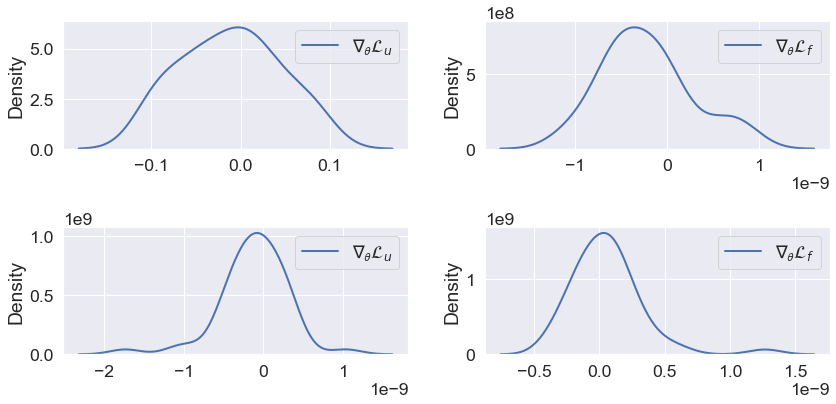

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.kdeplot(PINN_solver.gradients_log[0][1][0].numpy().flatten(), linewidth =2, ax = axs[0][0], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_u$')
axs[0][0].legend()


sns.kdeplot(PINN_solver.gradients_log[0][2][0].numpy().flatten(), linewidth =2, ax = axs[0][1], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_f$')
axs[0][1].legend()


sns.kdeplot(PINN_solver.gradients_log[2][1][0].numpy().flatten(), linewidth =2, ax = axs[1][0], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_u$')
axs[1][0].legend()


sns.kdeplot(PINN_solver.gradients_log[2][2][0].numpy().flatten(), linewidth =2, ax = axs[1][1], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_f$')
axs[1][1].legend()

plt.tight_layout()
plt.legend()

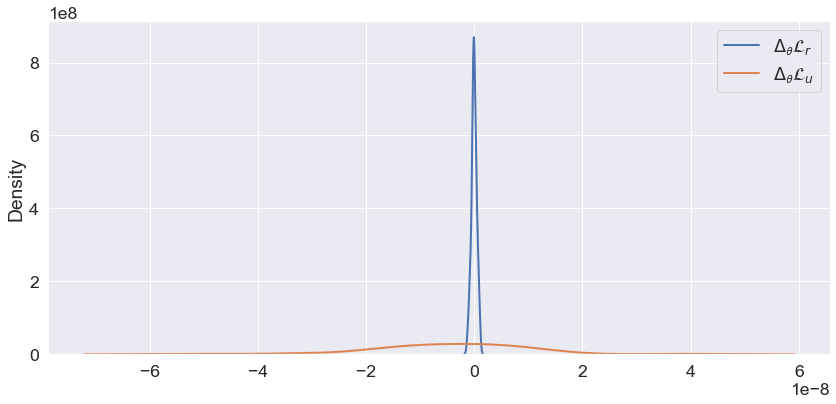

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

sns.kdeplot(PINN_solver.gradients_log[1][2][0].numpy().flatten(), ax = axs, linewidth =2,
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_r$')

sns.kdeplot(PINN_solver.gradients_log[1][1][0].numpy().flatten(), linewidth =2, ax = axs, 
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_u$')

plt.tight_layout()
plt.legend()

### Visualize loss function

In [16]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

#### Loss convergence comparison

In [17]:
iterations_range = np.array(range(len(pinn_pcgrad_loss_log[50000:52000, 1]))) + 50000

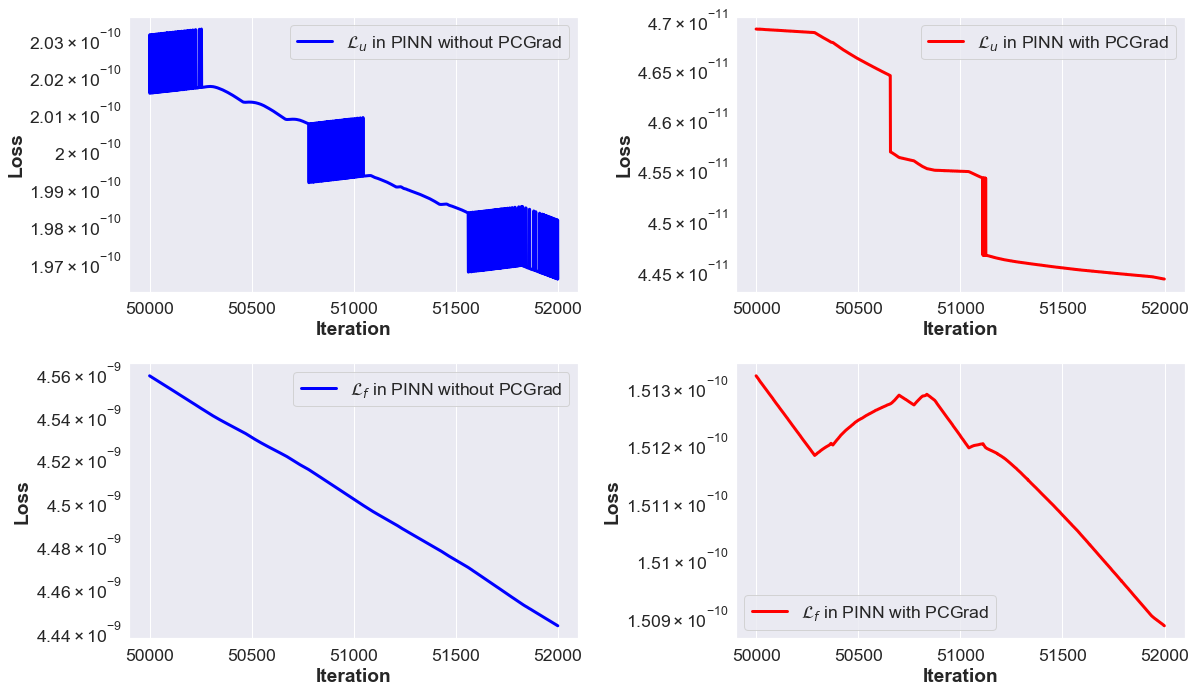

In [18]:
f, ax = plt.subplots(2, 2, figsize=(17, 10))

sns.lineplot(x = iterations_range, y = pinn_loss_log[50000:52000, 0], linewidth = 3, color='blue',
             label=r'$\mathcal{L}_u$ in PINN without PCGrad', ax = ax[0][0])

ax[0][0].set(yscale="log")
ax[0][0].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[0][0].set_ylabel("Loss", fontdict=dict(weight='bold'))


sns.lineplot(x = iterations_range, y = pinn_pcgrad_loss_log[50000:52000, 0], linewidth = 3, color='red', 
             label=r'$\mathcal{L}_u$ in PINN with PCGrad', ax = ax[0][1])

ax[0][1].set(yscale="log")
ax[0][1].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[0][1].set_ylabel("Loss", fontdict=dict(weight='bold'))


sns.lineplot(x = iterations_range, y = pinn_loss_log[50000:52000, 1], linewidth = 3, color='blue',
             label=r'$\mathcal{L}_f$ in PINN without PCGrad', ax = ax[1][0])

ax[1][0].set(yscale="log")
ax[1][0].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[1][0].set_ylabel("Loss", fontdict=dict(weight='bold'))


sns.lineplot(x = iterations_range, y = pinn_pcgrad_loss_log[50000:52000, 1], linewidth = 3, color='red', 
             label=r'$\mathcal{L}_f$ in PINN with PCGrad', ax = ax[1][1])

ax[1][1].set(yscale="log")
ax[1][1].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[1][1].set_ylabel("Loss", fontdict=dict(weight='bold'))


plt.tight_layout()
plt.savefig('loss_convergence_demonstration_small_homo.pdf')

#### Comparison of loss 

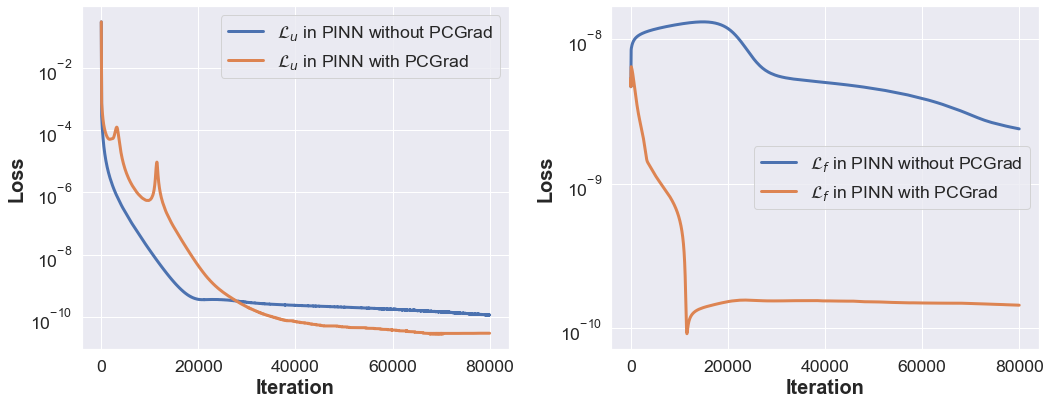

In [19]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN with PCGrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration", fontdict=dict(weight='bold'), fontsize=20)
axes[0].set_ylabel("Loss", fontdict=dict(weight='bold'), fontsize=20)

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = pinn_loss_log[:, 1],  linewidth = 3, 
             label = "$\mathcal{L}_f$ in PINN without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = pinn_pcgrad_loss_log[:, 1],  linewidth = 3, 
             label = "$\mathcal{L}_f$ in PINN with PCGrad", ax = axes[1])
axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration", fontdict=dict(weight='bold'), fontsize=20)
axes[1].set_ylabel("Loss", fontdict=dict(weight='bold'), fontsize=20)

plt.tight_layout()
plt.savefig("performance_comparison_small_homo.pdf")

### Solution quality comparison

#### Load solver solution

In [113]:
matlab_solver_solution_df = pd.read_csv('homo_80000.csv')
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [114]:
matlab_solver_solution_df.head()

,time,state_0,state_1,state_2
0,16,0.99794,0.000894,0.001161
1,32,0.99589,0.001785,0.002321
2,48,0.99385,0.002673,0.003480
3,64,0.99180,0.003557,0.004639
4,80,0.98977,0.004439,0.005796


In [115]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [116]:
matlab_solver_solution_df.head()

,state_0,state_1,state_2
0,0.99794,0.000894,0.001161
1,0.99589,0.001785,0.002321
2,0.99385,0.002673,0.003480
3,0.99180,0.003557,0.004639
4,0.98977,0.004439,0.005796


#### Load MCS solution

In [126]:
MCS_solver_solution_df = pd.read_csv('MCS_homo_80000.csv')
MCS_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [127]:
MCS_solver_solution_df.head()

,time,state_0,state_1,state_2
0,16.0,0.997984,0.000895,0.001121
1,32.0,0.995997,0.001729,0.002274
2,48.0,0.993874,0.002629,0.003497
3,64.0,0.991758,0.003541,0.004701
4,80.0,0.989762,0.004375,0.005863


In [128]:
MCS_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [129]:
MCS_solver_solution_df.head()

,state_0,state_1,state_2
0,0.997984,0.000895,0.001121
1,0.995997,0.001729,0.002274
2,0.993874,0.002629,0.003497
3,0.991758,0.003541,0.004701
4,0.989762,0.004375,0.005863


#### PINN Solver

In [130]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

ub = 80000
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 

In [131]:
y_pred = PINN_solver.predict(x_star)
y_pred_pcgrad = PINN_solver_pcgrad.predict(x_star)

In [132]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = ['state_0', 'state_1', 'state_2'])
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = ['state_0', 'state_1', 'state_2'])

#### Compare PINN predictions with Matlab solver

In [133]:
sns.set_style("white")
plt.rcParams['legend.fontsize'] = 12

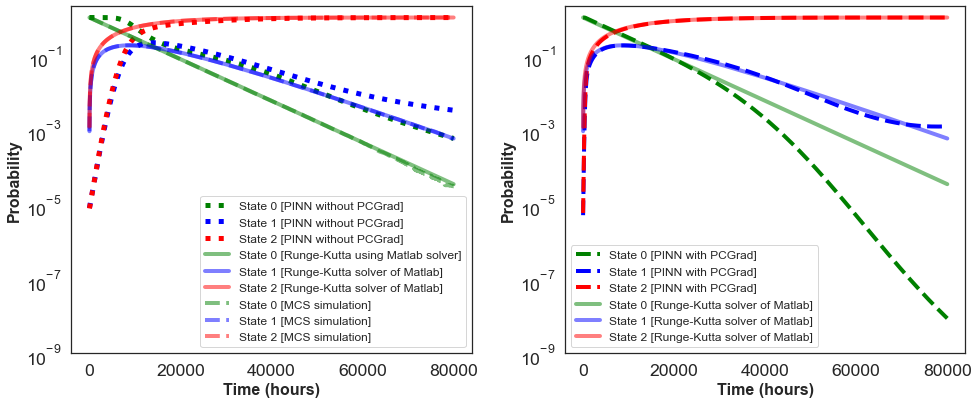

In [142]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0 [PINN without PCGrad]', linewidth = 5, color = 'green', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1 [PINN without PCGrad]', linewidth = 5, color = 'blue', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2 [PINN without PCGrad]', linewidth = 5, color = 'red', 
             linestyle='dotted', ax=ax[0])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta using Matlab solver]', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta solver of Matlab]', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta solver of Matlab]', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])

sns.lineplot(x = x_star.flatten(), y = MCS_solver_solution_df['state_0'], 
             label = 'State 0 [MCS simulation]', color = 'green', linestyle='--',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solver_solution_df['state_1'], 
             label = 'State 1 [MCS simulation]', color = 'blue', linestyle='--',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solver_solution_df['state_2'], 
             label = 'State 2 [MCS simulation]', color = 'red', linestyle='--',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])

ax[0].set_yscale("log")
ax[0].set_ylim([1e-9, 2])
ax[0].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[0].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'State 0 [PINN with PCGrad]', 
             color = 'green', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'State 1 [PINN with PCGrad]', 
             color = 'blue', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'State 2 [PINN with PCGrad]', 
             color = 'red', linestyle='--', linewidth = 4, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta solver of Matlab]', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta solver of Matlab]', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta solver of Matlab]', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[1])

ax[1].set_yscale("log")
ax[1].set_ylim([1e-9, 2])
ax[1].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[1].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout()
plt.savefig("comparison_small_homo.pdf")

In [84]:
y_pred_df.tail()

,state_0,state_1,state_2
4995,0.000576,0.003273,0.996152
4996,0.000575,0.003271,0.996154
4997,0.000574,0.003269,0.996157
4998,0.000574,0.003267,0.996159
4999,0.000573,0.003265,0.996162


In [135]:
y_diff = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad = matlab_solver_solution_df - y_pred_pcgrad_df

In [136]:
y_diff.head()

,state_0,state_1,state_2
0,-0.002045,0.000886,0.001153
1,-0.004094,0.001777,0.002313
2,-0.006134,0.002665,0.003472
3,-0.008183,0.003549,0.004630
4,-0.010213,0.004430,0.005788


#### Generate histogram of prediction difference with respect to each state

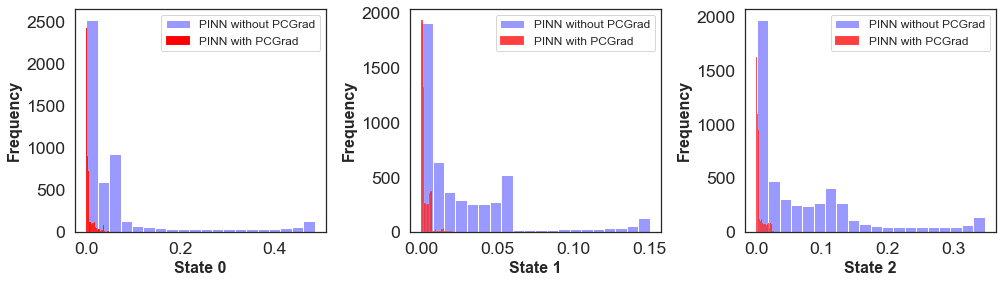

In [137]:
f, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.histplot(np.abs(y_diff['state_0']), bins=20, ax=axes[0], alpha=0.4, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_0']), bins=20, ax=axes[0], alpha=1, color='red', label='PINN with PCGrad')
#plt.axvline(x=np.mean(np.abs(y_diff['state_0'])), linewidth=2, linestyle="--", alpha=0.6, 
#            color='blue', label='Mean of no PCGrad')

axes[0].legend()
axes[0].set_xlabel('State 0', fontdict=dict(weight='bold'), fontsize=16)
axes[0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff['state_1']), bins=20, ax=axes[1], alpha=0.4, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_1']), bins=20, ax=axes[1], color='red', label='PINN with PCGrad')
axes[1].legend()
axes[1].set_xlabel('State 1', fontdict=dict(weight='bold'), fontsize=16)
axes[1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

sns.histplot(np.abs(y_diff['state_2']), bins=20, ax=axes[2], alpha=0.4, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_2']), bins=20, ax=axes[2], color='red', label='PINN with PCGrad')
axes[2].legend()
axes[2].set_xlabel('State 2', fontdict=dict(weight='bold'), fontsize=16)
axes[2].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout(pad=0.5)
plt.savefig("histogram_small_homo.pdf")

#### Compare RMSE

In [138]:
y_diff['mse'] = y_diff.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff['rmse'] = y_diff['mse'].apply(np.sqrt)

y_diff_pcgrad['mse'] = y_diff_pcgrad.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_pcgrad['rmse'] = y_diff_pcgrad['mse'].apply(np.sqrt)

In [139]:
print ('RMSE of PINN without PCGrad is', np.mean(y_diff['rmse']))
print ('RMSE of PINN with PCGrad is', np.mean(y_diff_pcgrad['rmse']))

RMSE of PINN without PCGrad is 0.11113984331990452
RMSE of PINN with PCGrad is 0.008291605013509519


In [140]:
(np.mean(y_diff['rmse']) - np.mean(y_diff_pcgrad['rmse']))/np.mean(y_diff['rmse'])

0.9253948470159078

In [141]:
print ('RMSE of PINN without PCGrad before 60000 is', np.mean(y_diff['rmse'][:3749]))
print ('RMSE of PINN with PCGrad before 60000 is', np.mean(y_diff_pcgrad['rmse'][:3749]))

print ('RMSE of PINN without PCGrad after 60000 is', np.mean(y_diff['rmse'][3749:]))
print ('RMSE of PINN with PCGrad after 60000 is', np.mean(y_diff_pcgrad['rmse'][3749:]))

RMSE of PINN without PCGrad before 60000 is 0.14614707022689108
RMSE of PINN with PCGrad before 60000 is 0.01082606303772342
RMSE of PINN without PCGrad after 60000 is 0.00623009617818525
RMSE of PINN with PCGrad after 60000 is 0.0006963347235191894
